<a href="https://colab.research.google.com/github/williamratcliff/APS-GDS-March-2024-Data-Science-Tutorial/blob/main/BO/BO_IsingModel_APStutorial.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Classical and structured Bayesian optimization**
March, 2024

-- Notebook prepared by **Arpan Biswas** for APS March Meeting 2024 Workshop **Data Science for Physicists II**

-- Gpax package is developed by **Maxim Ziatdinov**



# Install Gpax package

In [1]:
!pip install -q git+https://github.com/ziatdinovmax/gpax.git

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 330.2/330.2 kB 7.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 371.7/371.7 kB 39.6 MB/s eta 0:00:00


In [2]:
import gpax
import numpy as np
import matplotlib.pyplot as plt
from numpy.random import rand

from tqdm import tqdm

gpax.utils.enable_x64()  # enable double precision

from typing import Union, Dict, Callable

import math

import jax.numpy as jnp
from jax import jit
from gpax.kernels import RBFKernel, MaternKernel

import jax
import numpyro

import time


# Test Problem 1

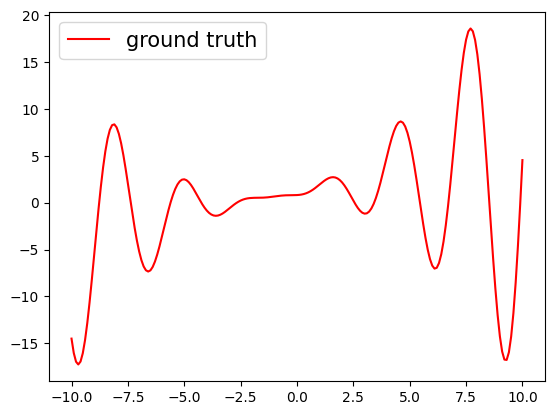

In [3]:
def objective(x):
    # a modification of https://www.sfu.ca/~ssurjano/forretal08.html
    y = -((x + 1) ** 2) * np.sin(2 * x + 2) / 5 + 1 + x / 3
    return y



lb = -10
ub = 10

bounds = np.array((lb, ub), dtype=float)
fidelities = np.array((1, 2))

xs = np.linspace(lb, ub, 201)
xs_norm = (xs-lb)/(ub-lb)

ys = objective(xs)

plt.plot(xs, ys, label="ground truth", c="r")

plt.legend(fontsize=15);

# Initial Samples

- Let choose 25 samples randomly

In [4]:
n = 25

np.random.seed(10)
train_x = bounds[0] + (bounds[1] - bounds[0]) * np.random.rand(n, 1)
train_x

array([[ 5.42641287],
       [-9.58496101],
       [ 2.6729647 ],
       [ 4.97607765],
       [-0.02985975],
       [-5.50406709],
       [-6.0387427 ],
       [ 5.21061424],
       [-6.61778327],
       [-8.23320372],
       [ 3.70719637],
       [ 9.06786692],
       [-9.92103467],
       [ 0.24384527],
       [ 6.25241923],
       [ 2.25052134],
       [ 4.43510635],
       [-4.16247864],
       [ 8.35548245],
       [ 4.29151567],
       [ 0.85088736],
       [-7.15659905],
       [-2.5331848 ],
       [ 3.4826723 ],
       [-1.16333651]])

In [5]:
train_y = objective(train_x)
train_y

array([[  0.47498059],
       [-16.84808023],
       [ -0.4663544 ],
       [  6.77515555],
       [  0.81451556],
       [  0.8072842 ],
       [ -4.09685422],
       [  3.85262089],
       [ -7.33692538],
       [  8.15741373],
       [  2.18971041],
       [-15.43418551],
       [-15.76469002],
       [  0.89305901],
       [ -6.73232454],
       [  1.29343548],
       [  8.34008148],
       [ -0.30396262],
       [  6.20343919],
       [  7.56071412],
       [  1.64768064],
       [ -3.2843316 ],
       [  0.19093642],
       [  0.37876178],
       [  0.61393338]])

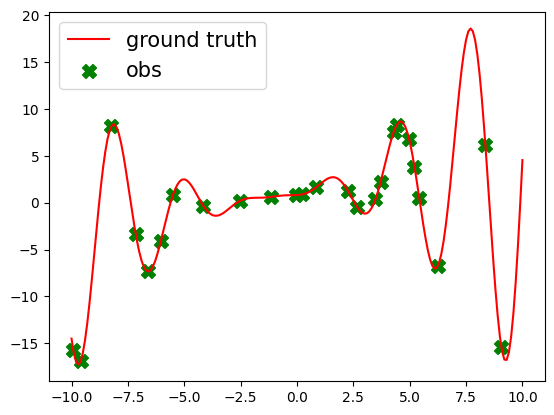

In [6]:
plt.plot(xs, ys, label="ground truth", c="r")
plt.scatter(train_x, train_y, c="g", marker="X", label="obs", s=100)

plt.legend(fontsize=15);

# Define GP hyperparater prior distribution

In [17]:
def kernel_prior() -> Dict[str, jnp.ndarray]:
    length = numpyro.sample("k_length", numpyro.distributions.LogNormal(0, 1))
    scale = numpyro.sample("k_scale", numpyro.distributions.LogNormal(0, 1))
    return {"k_length": length, "k_scale": scale}

# Run GP

In [11]:
X_test =xs


/usr/local/lib/python3.10/dist-packages/gpax/models/gp.py:109: FutureWarning: `noise_prior` is deprecated and will be removed in a future version. Please use `noise_prior_dist` instead, which accepts an instance of a numpyro.distributions Distribution object, e.g., `dist.HalfNormal(scale=0.1)`, rather than a function that calls `numpyro.sample`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/gpax/models/gp.py:117: UserWarning: `kernel_prior` will remain available for complex priors. However, for modifying only the lengthscales, it is recommended to use `lengthscale_prior_dist` instead. `lengthscale_prior_dist` accepts an instance of a numpyro.distributions Distribution object, e.g., `dist.Gamma(2, 5)`, rather than a function that calls `numpyro.sample`.
  warnings.warn(
sample: 100%|██████████| 1000/1000 [00:23<00:00, 43.06it/s, 3 steps of size 5.30e-01. acc. prob=0.93]



                mean       std    median      5.0%     95.0%     n_eff     r_hat
  k_length      0.69      0.15      0.68      0.48      0.98    320.00      1.00
   k_scale     39.33     13.02     37.22     20.33     55.59    300.88      1.00
     noise      0.74      0.64      0.53      0.06      1.54    255.03      1.00



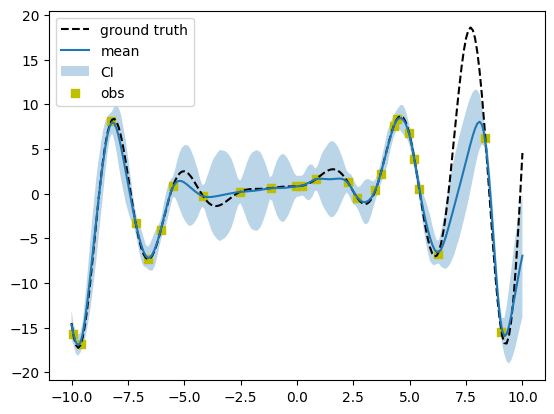

In [18]:
# Get random number generator keys for training and prediction
rng_key, rng_key_predict = gpax.utils.get_keys()
# Initialize model
gp_model = gpax.ExactGP(1, kernel='Matern', kernel_prior = kernel_prior, noise_prior = lambda: numpyro.sample("noise", numpyro.distributions.LogNormal(0,1)))
# Run Hamiltonian Monte Carlo to obtain posterior samples for kernel parameters and model noise
gp_model.fit(rng_key, train_x, train_y, num_warmup=500, num_samples=500, num_chains=1)

y_pred, y_sampled = gp_model.predict(rng_key_predict, X_test)
plt.plot(xs, ys, "k--", label="ground truth")
pred_lower = y_pred - y_sampled.std(axis=(0,1))
pred_upper = y_pred + y_sampled.std(axis=(0,1))
plt.plot(xs, y_pred, label="mean")
plt.fill_between(
    xs.flatten(),
    pred_lower,
    pred_upper,
    alpha=0.3,
    label="CI",
)
plt.scatter(train_x, train_y, c="y", marker="s", label="obs")

plt.legend(loc="best")
plt.show()

# Initial Samples

- Let choose 10 samples randomly

- Then we explore next 15 samples autonomously

In [20]:
n = 10

np.random.seed(100)
train_x = bounds[0] + (bounds[1] - bounds[0]) * np.random.rand(n, 1)
train_x

array([[ 0.86809884],
       [-4.4326123 ],
       [-1.50964819],
       [ 6.89552265],
       [-9.90562288],
       [-7.56861758],
       [ 3.41498169],
       [ 6.5170551 ],
       [-7.26586821],
       [ 1.50186659]])

In [21]:
train_y = objective(train_x)
train_y

array([[  1.68034988],
       [  0.81793395],
       [  0.54103032],
       [  4.33317096],
       [-15.96776232],
       [  3.14007918],
       [ -0.04616851],
       [ -3.87962853],
       [ -1.6938571 ],
       [  2.69973408]])

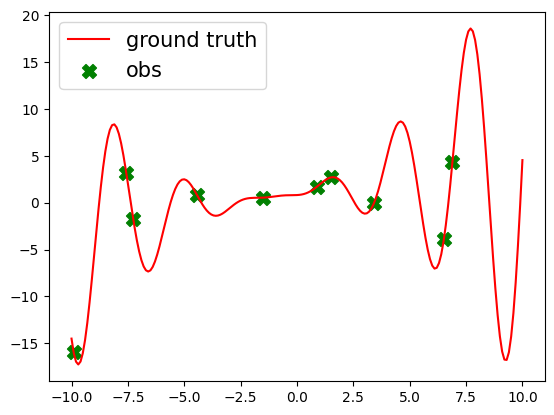

In [22]:
plt.plot(xs, ys, label="ground truth", c="r")
plt.scatter(train_x, train_y, c="g", marker="X", label="obs", s=100)

plt.legend(fontsize=15);

# Define GP hyperparater prior distribution

In [23]:
def kernel_prior() -> Dict[str, jnp.ndarray]:
    length = numpyro.sample("k_length", numpyro.distributions.LogNormal(0, 1))
    scale = numpyro.sample("k_scale", numpyro.distributions.LogNormal(0, 1))
    return {"k_length": length, "k_scale": scale}

# Run BO

Step:1


/usr/local/lib/python3.10/dist-packages/gpax/models/gp.py:117: UserWarning: `kernel_prior` will remain available for complex priors. However, for modifying only the lengthscales, it is recommended to use `lengthscale_prior_dist` instead. `lengthscale_prior_dist` accepts an instance of a numpyro.distributions Distribution object, e.g., `dist.Gamma(2, 5)`, rather than a function that calls `numpyro.sample`.
  warnings.warn(
sample: 100%|██████████| 1000/1000 [00:09<00:00, 102.41it/s, 7 steps of size 5.81e-01. acc. prob=0.86]



                mean       std    median      5.0%     95.0%     n_eff     r_hat
  k_length      1.25      1.42      0.79      0.05      2.98    274.66      1.00
   k_scale      4.37      6.65      1.69      0.09     13.27     44.89      1.00
     noise     17.46      9.20     16.90      0.51     29.07     71.36      1.01



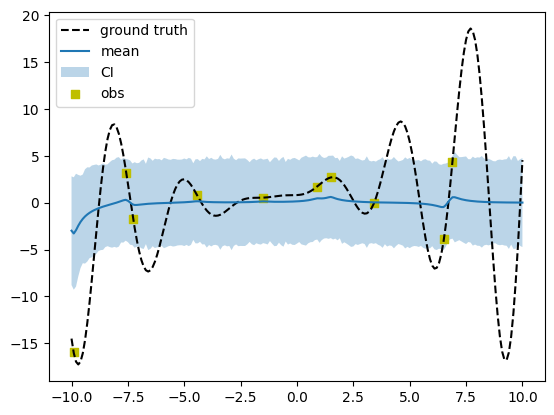

125


<ipython-input-24-83428f2a3aeb>:43: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  idx = int(idx)


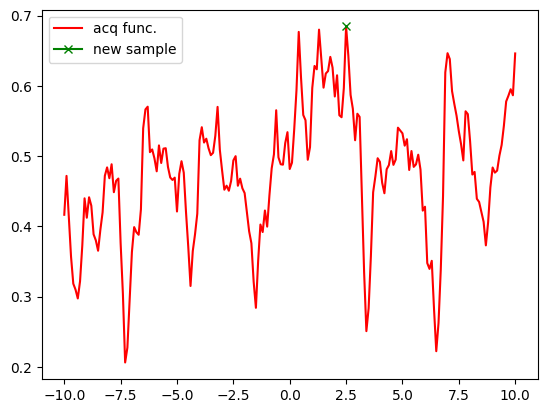

Step:2


/usr/local/lib/python3.10/dist-packages/gpax/models/gp.py:117: UserWarning: `kernel_prior` will remain available for complex priors. However, for modifying only the lengthscales, it is recommended to use `lengthscale_prior_dist` instead. `lengthscale_prior_dist` accepts an instance of a numpyro.distributions Distribution object, e.g., `dist.Gamma(2, 5)`, rather than a function that calls `numpyro.sample`.
  warnings.warn(
sample: 100%|██████████| 1000/1000 [00:12<00:00, 79.81it/s, 7 steps of size 3.07e-01. acc. prob=0.94] 



                mean       std    median      5.0%     95.0%     n_eff     r_hat
  k_length      1.19      1.42      0.77      0.06      2.46    201.72      1.01
   k_scale      4.84      6.85      1.79      0.03     14.46    160.01      1.00
     noise     15.85      8.38     15.34      0.01     26.13    208.99      1.00



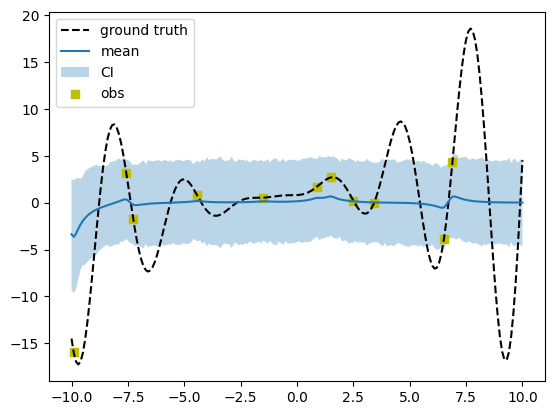

[125 112]


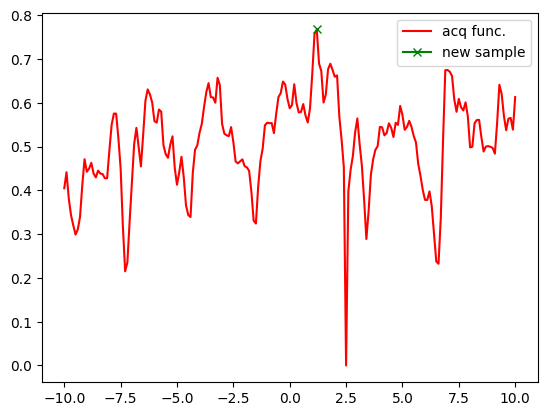

Step:3


/usr/local/lib/python3.10/dist-packages/gpax/models/gp.py:117: UserWarning: `kernel_prior` will remain available for complex priors. However, for modifying only the lengthscales, it is recommended to use `lengthscale_prior_dist` instead. `lengthscale_prior_dist` accepts an instance of a numpyro.distributions Distribution object, e.g., `dist.Gamma(2, 5)`, rather than a function that calls `numpyro.sample`.
  warnings.warn(
sample: 100%|██████████| 1000/1000 [00:15<00:00, 66.53it/s, 3 steps of size 2.37e-01. acc. prob=0.93]



                mean       std    median      5.0%     95.0%     n_eff     r_hat
  k_length      1.06      1.18      0.69      0.05      2.32    184.36      1.00
   k_scale      5.42      7.68      1.76      0.03     17.72     91.33      1.00
     noise     14.77      8.79     15.10      0.06     24.81    139.37      1.00



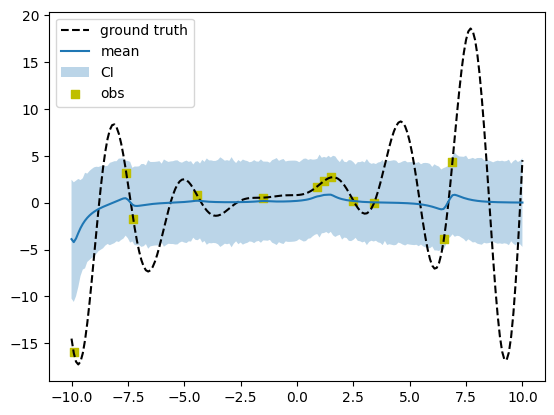

[125 112 172]


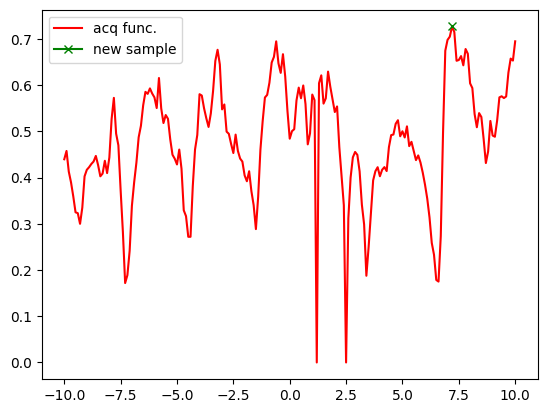

Step:4


/usr/local/lib/python3.10/dist-packages/gpax/models/gp.py:117: UserWarning: `kernel_prior` will remain available for complex priors. However, for modifying only the lengthscales, it is recommended to use `lengthscale_prior_dist` instead. `lengthscale_prior_dist` accepts an instance of a numpyro.distributions Distribution object, e.g., `dist.Gamma(2, 5)`, rather than a function that calls `numpyro.sample`.
  warnings.warn(
sample: 100%|██████████| 1000/1000 [00:17<00:00, 56.67it/s, 15 steps of size 1.75e-01. acc. prob=0.95]



                mean       std    median      5.0%     95.0%     n_eff     r_hat
  k_length      1.10      1.39      0.62      0.07      2.43    121.73      1.00
   k_scale     12.02     14.47      4.27      0.11     32.65     61.58      1.00
     noise     15.47     12.28     16.54      0.11     31.16     61.94      1.00



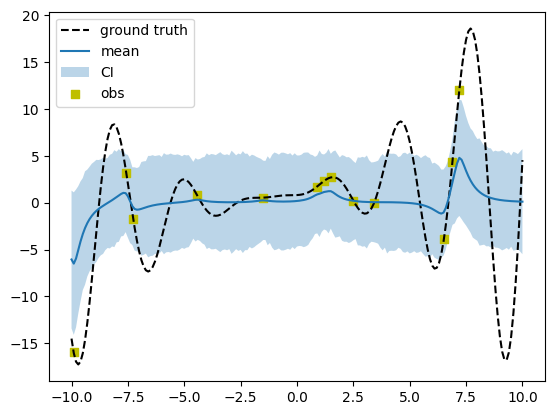

[125 112 172 173]


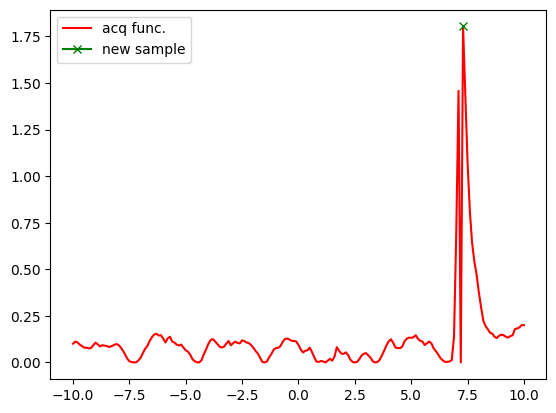

Step:5


/usr/local/lib/python3.10/dist-packages/gpax/models/gp.py:117: UserWarning: `kernel_prior` will remain available for complex priors. However, for modifying only the lengthscales, it is recommended to use `lengthscale_prior_dist` instead. `lengthscale_prior_dist` accepts an instance of a numpyro.distributions Distribution object, e.g., `dist.Gamma(2, 5)`, rather than a function that calls `numpyro.sample`.
  warnings.warn(
sample: 100%|██████████| 1000/1000 [00:12<00:00, 82.36it/s, 3 steps of size 5.46e-01. acc. prob=0.93]



                mean       std    median      5.0%     95.0%     n_eff     r_hat
  k_length      0.55      0.22      0.53      0.21      0.89    233.44      1.00
   k_scale     32.93     14.81     29.32     13.61     49.85    174.24      1.00
     noise      1.43      1.65      0.87      0.05      3.23    265.83      1.00



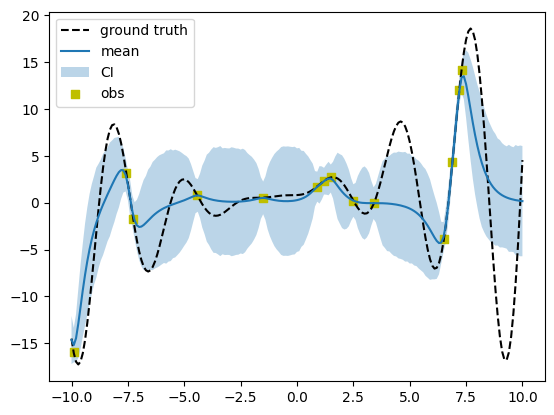

[125 112 172 173 175]


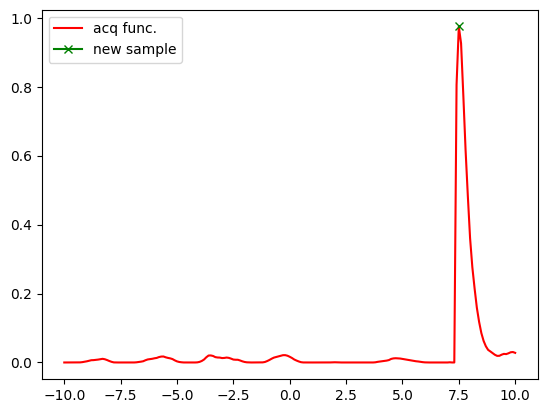

Step:6


/usr/local/lib/python3.10/dist-packages/gpax/models/gp.py:117: UserWarning: `kernel_prior` will remain available for complex priors. However, for modifying only the lengthscales, it is recommended to use `lengthscale_prior_dist` instead. `lengthscale_prior_dist` accepts an instance of a numpyro.distributions Distribution object, e.g., `dist.Gamma(2, 5)`, rather than a function that calls `numpyro.sample`.
  warnings.warn(
sample: 100%|██████████| 1000/1000 [00:12<00:00, 78.36it/s, 3 steps of size 5.82e-01. acc. prob=0.92]



                mean       std    median      5.0%     95.0%     n_eff     r_hat
  k_length      0.70      0.21      0.69      0.34      1.01    228.05      1.00
   k_scale     38.59     14.54     35.69     20.01     59.96    196.17      1.00
     noise      0.88      0.98      0.56      0.03      1.87    297.67      1.00



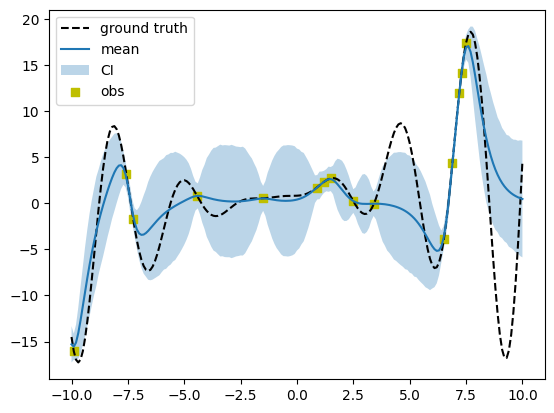

[125 112 172 173 175 178]


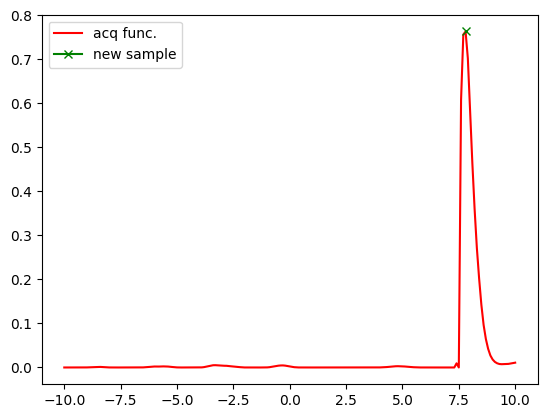

Step:7


/usr/local/lib/python3.10/dist-packages/gpax/models/gp.py:117: UserWarning: `kernel_prior` will remain available for complex priors. However, for modifying only the lengthscales, it is recommended to use `lengthscale_prior_dist` instead. `lengthscale_prior_dist` accepts an instance of a numpyro.distributions Distribution object, e.g., `dist.Gamma(2, 5)`, rather than a function that calls `numpyro.sample`.
  warnings.warn(
sample: 100%|██████████| 1000/1000 [00:07<00:00, 130.35it/s, 7 steps of size 6.63e-01. acc. prob=0.90]



                mean       std    median      5.0%     95.0%     n_eff     r_hat
  k_length      0.84      0.19      0.83      0.52      1.09    244.37      1.00
   k_scale     44.22     15.18     41.45     23.25     66.53    268.87      1.00
     noise      0.66      0.66      0.44      0.03      1.53    303.72      1.00



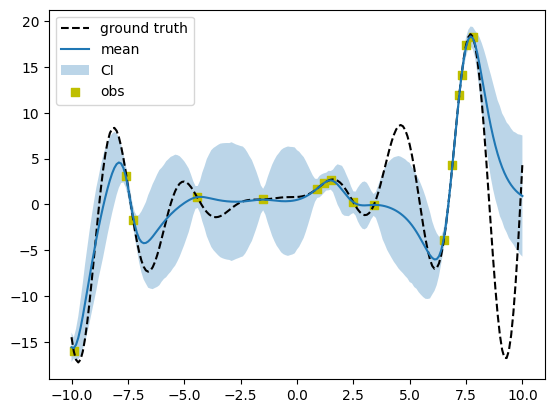

[125 112 172 173 175 178 177]


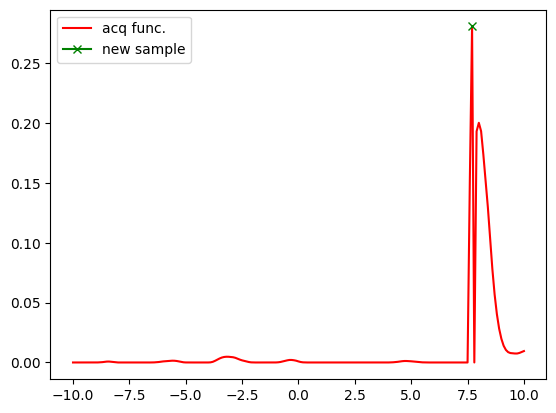

Step:8


/usr/local/lib/python3.10/dist-packages/gpax/models/gp.py:117: UserWarning: `kernel_prior` will remain available for complex priors. However, for modifying only the lengthscales, it is recommended to use `lengthscale_prior_dist` instead. `lengthscale_prior_dist` accepts an instance of a numpyro.distributions Distribution object, e.g., `dist.Gamma(2, 5)`, rather than a function that calls `numpyro.sample`.
  warnings.warn(
sample: 100%|██████████| 1000/1000 [00:14<00:00, 68.68it/s, 7 steps of size 7.34e-01. acc. prob=0.90]



                mean       std    median      5.0%     95.0%     n_eff     r_hat
  k_length      0.86      0.18      0.85      0.59      1.16    375.56      1.00
   k_scale     45.40     16.60     42.19     21.92     72.01    331.80      1.00
     noise      0.46      0.43      0.32      0.02      1.07    273.94      1.00



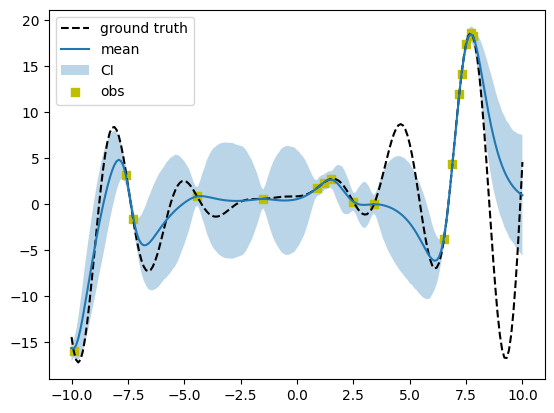

[125 112 172 173 175 178 177 180]


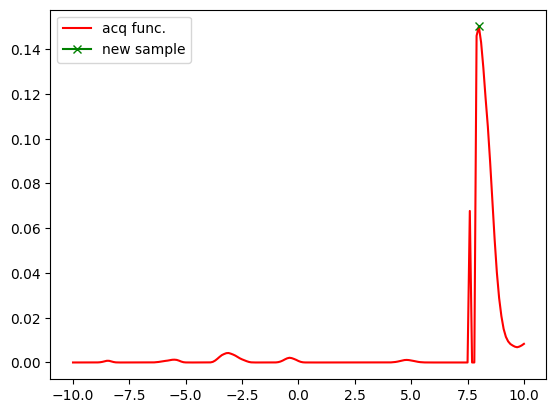

Step:9


/usr/local/lib/python3.10/dist-packages/gpax/models/gp.py:117: UserWarning: `kernel_prior` will remain available for complex priors. However, for modifying only the lengthscales, it is recommended to use `lengthscale_prior_dist` instead. `lengthscale_prior_dist` accepts an instance of a numpyro.distributions Distribution object, e.g., `dist.Gamma(2, 5)`, rather than a function that calls `numpyro.sample`.
  warnings.warn(
sample: 100%|██████████| 1000/1000 [00:15<00:00, 64.63it/s, 7 steps of size 7.10e-01. acc. prob=0.92]



                mean       std    median      5.0%     95.0%     n_eff     r_hat
  k_length      0.83      0.17      0.82      0.55      1.09    173.93      1.00
   k_scale     42.65     14.83     39.82     21.64     62.42    198.98      1.00
     noise      0.40      0.40      0.27      0.03      0.94    258.07      1.00



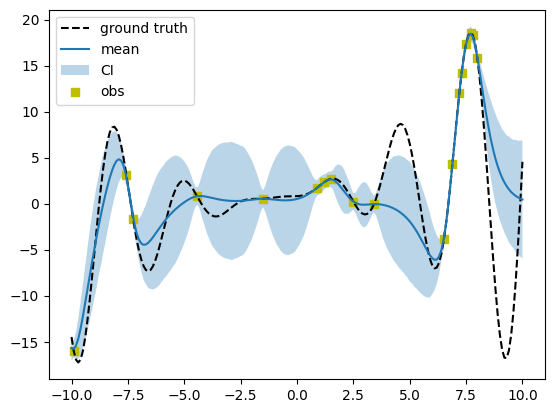

[125 112 172 173 175 178 177 180 176]


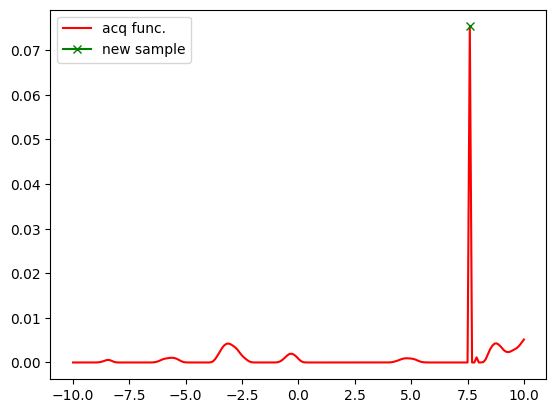

Step:10


/usr/local/lib/python3.10/dist-packages/gpax/models/gp.py:117: UserWarning: `kernel_prior` will remain available for complex priors. However, for modifying only the lengthscales, it is recommended to use `lengthscale_prior_dist` instead. `lengthscale_prior_dist` accepts an instance of a numpyro.distributions Distribution object, e.g., `dist.Gamma(2, 5)`, rather than a function that calls `numpyro.sample`.
  warnings.warn(
sample: 100%|██████████| 1000/1000 [00:16<00:00, 61.95it/s, 5 steps of size 6.59e-01. acc. prob=0.92]



                mean       std    median      5.0%     95.0%     n_eff     r_hat
  k_length      0.83      0.16      0.83      0.60      1.11    197.17      1.00
   k_scale     41.21     13.28     38.60     22.74     60.68    213.87      1.00
     noise      0.28      0.27      0.21      0.01      0.62    314.29      1.00



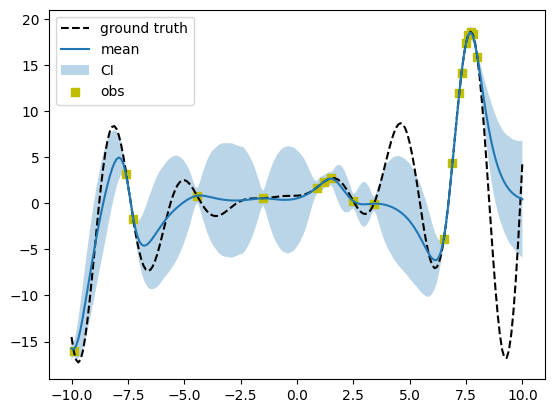

[125 112 172 173 175 178 177 180 176 200]


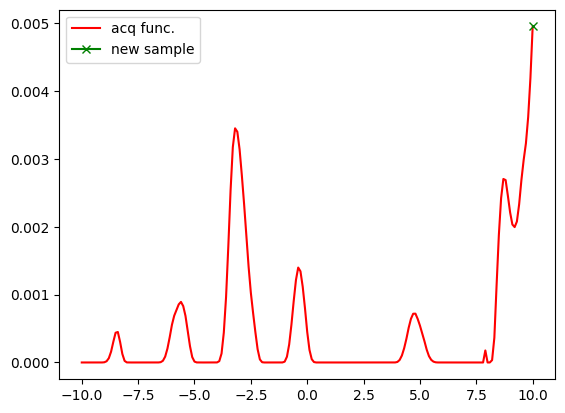

Step:11


/usr/local/lib/python3.10/dist-packages/gpax/models/gp.py:117: UserWarning: `kernel_prior` will remain available for complex priors. However, for modifying only the lengthscales, it is recommended to use `lengthscale_prior_dist` instead. `lengthscale_prior_dist` accepts an instance of a numpyro.distributions Distribution object, e.g., `dist.Gamma(2, 5)`, rather than a function that calls `numpyro.sample`.
  warnings.warn(
sample: 100%|██████████| 1000/1000 [00:16<00:00, 60.69it/s, 7 steps of size 7.28e-01. acc. prob=0.90]



                mean       std    median      5.0%     95.0%     n_eff     r_hat
  k_length      0.86      0.15      0.85      0.62      1.08    398.26      1.00
   k_scale     42.63     13.94     39.98     20.29     61.77    320.45      1.00
     noise      0.29      0.29      0.19      0.01      0.65    266.45      1.00



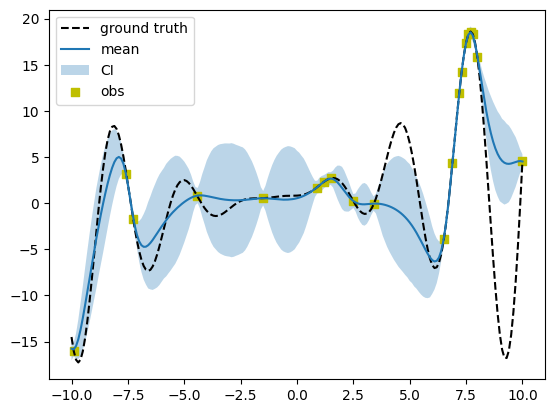

[125 112 172 173 175 178 177 180 176 200 187]


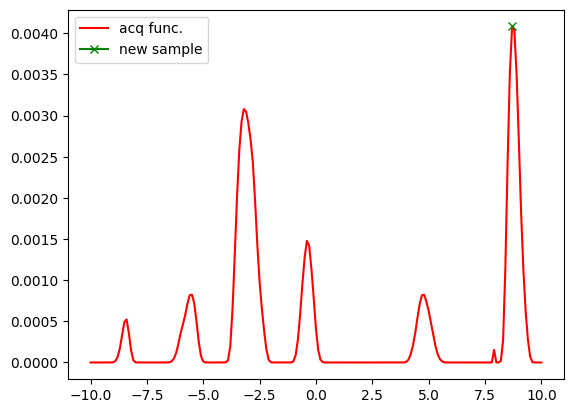

Step:12


/usr/local/lib/python3.10/dist-packages/gpax/models/gp.py:117: UserWarning: `kernel_prior` will remain available for complex priors. However, for modifying only the lengthscales, it is recommended to use `lengthscale_prior_dist` instead. `lengthscale_prior_dist` accepts an instance of a numpyro.distributions Distribution object, e.g., `dist.Gamma(2, 5)`, rather than a function that calls `numpyro.sample`.
  warnings.warn(
sample: 100%|██████████| 1000/1000 [00:17<00:00, 56.11it/s, 7 steps of size 6.49e-01. acc. prob=0.91]



                mean       std    median      5.0%     95.0%     n_eff     r_hat
  k_length      0.67      0.13      0.67      0.47      0.89    296.54      1.00
   k_scale     43.42     14.47     40.62     23.29     63.51    289.49      1.00
     noise      0.37      0.39      0.24      0.02      0.90    303.85      1.00



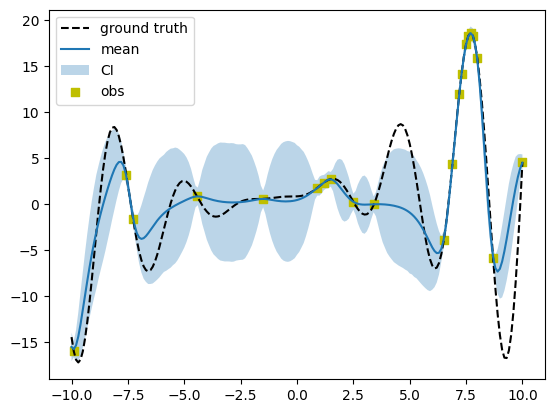

[125 112 172 173 175 178 177 180 176 200 187  96]


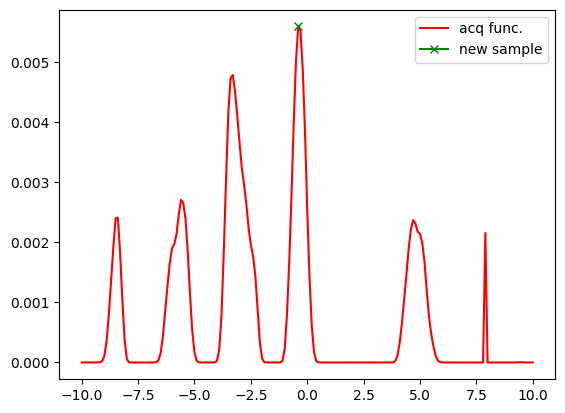

Step:13


/usr/local/lib/python3.10/dist-packages/gpax/models/gp.py:117: UserWarning: `kernel_prior` will remain available for complex priors. However, for modifying only the lengthscales, it is recommended to use `lengthscale_prior_dist` instead. `lengthscale_prior_dist` accepts an instance of a numpyro.distributions Distribution object, e.g., `dist.Gamma(2, 5)`, rather than a function that calls `numpyro.sample`.
  warnings.warn(
sample: 100%|██████████| 1000/1000 [00:18<00:00, 53.31it/s, 7 steps of size 6.52e-01. acc. prob=0.92]



                mean       std    median      5.0%     95.0%     n_eff     r_hat
  k_length      0.67      0.14      0.66      0.45      0.89    237.05      1.00
   k_scale     40.98     14.29     38.48     21.78     60.33    165.58      1.00
     noise      0.37      0.40      0.24      0.02      0.76    318.20      1.00



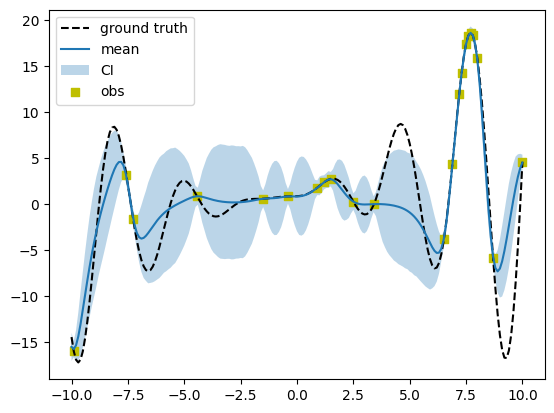

[125 112 172 173 175 178 177 180 176 200 187  96  66]


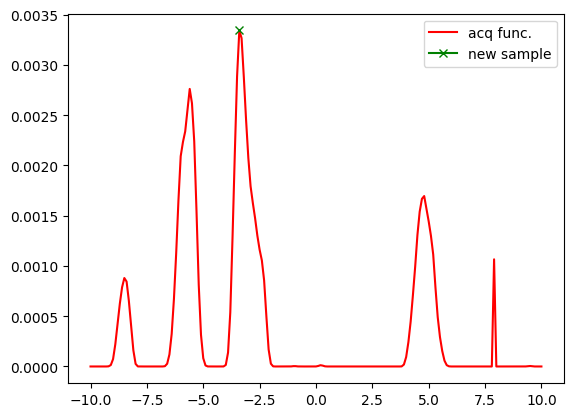

Step:14


/usr/local/lib/python3.10/dist-packages/gpax/models/gp.py:117: UserWarning: `kernel_prior` will remain available for complex priors. However, for modifying only the lengthscales, it is recommended to use `lengthscale_prior_dist` instead. `lengthscale_prior_dist` accepts an instance of a numpyro.distributions Distribution object, e.g., `dist.Gamma(2, 5)`, rather than a function that calls `numpyro.sample`.
  warnings.warn(
sample: 100%|██████████| 1000/1000 [00:19<00:00, 50.74it/s, 3 steps of size 6.36e-01. acc. prob=0.92]



                mean       std    median      5.0%     95.0%     n_eff     r_hat
  k_length      0.67      0.14      0.66      0.46      0.89    219.32      1.00
   k_scale     40.05     13.06     37.50     21.60     58.58    207.47      1.00
     noise      0.34      0.31      0.23      0.02      0.75    264.21      1.00



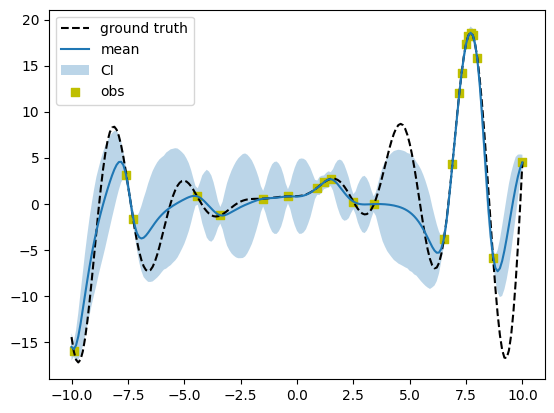

[125 112 172 173 175 178 177 180 176 200 187  96  66  44]


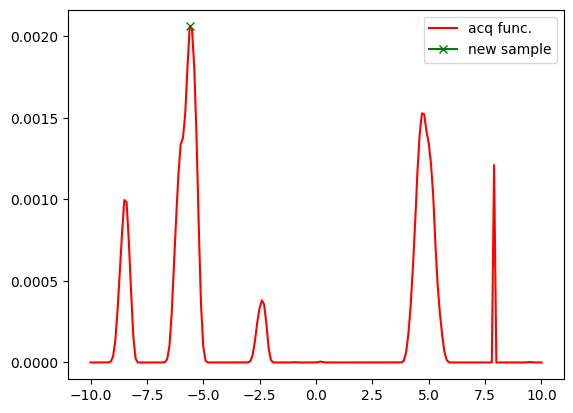

Step:15


/usr/local/lib/python3.10/dist-packages/gpax/models/gp.py:117: UserWarning: `kernel_prior` will remain available for complex priors. However, for modifying only the lengthscales, it is recommended to use `lengthscale_prior_dist` instead. `lengthscale_prior_dist` accepts an instance of a numpyro.distributions Distribution object, e.g., `dist.Gamma(2, 5)`, rather than a function that calls `numpyro.sample`.
  warnings.warn(
sample: 100%|██████████| 1000/1000 [00:20<00:00, 47.81it/s, 3 steps of size 6.59e-01. acc. prob=0.91]



                mean       std    median      5.0%     95.0%     n_eff     r_hat
  k_length      0.66      0.13      0.65      0.46      0.87    305.09      1.00
   k_scale     38.44     11.90     36.32     22.62     57.23    227.44      1.00
     noise      0.36      0.33      0.25      0.01      0.84    270.06      1.00



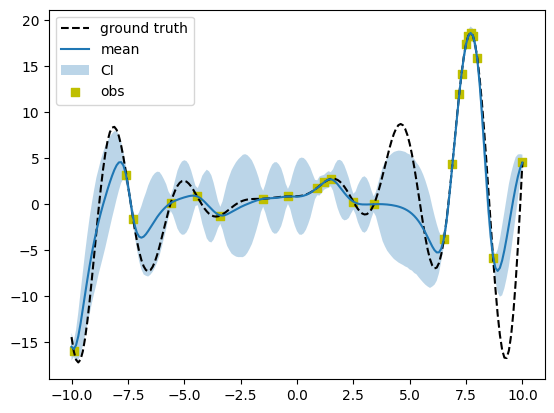

[125 112 172 173 175 178 177 180 176 200 187  96  66  44 179]


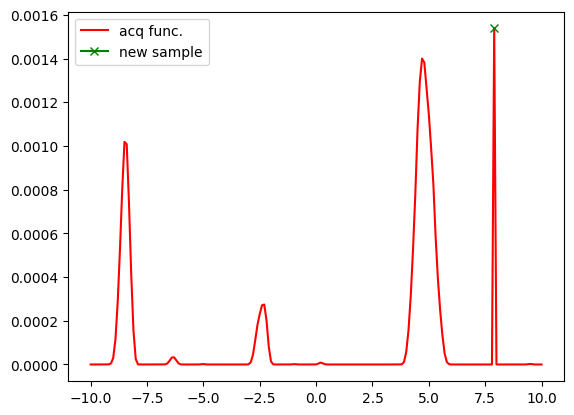

In [24]:
N = 15
X_test =xs
X_test_full = xs


# Get random number generator keys for training and prediction
rng_key, rng_key_predict = gpax.utils.get_keys()
idx = []
for i in range(1, N+1):
    print("Step:"+str(i))


    # Initialize model
    gp_model = gpax.ExactGP(1, kernel='Matern', kernel_prior = kernel_prior)
    # Run Hamiltonian Monte Carlo to obtain posterior samples for kernel parameters and model noise
    gp_model.fit(rng_key, train_x, train_y, num_warmup=500, num_samples=500, num_chains=1)

    y_pred, y_sampled = gp_model.predict(rng_key_predict, X_test)
    plt.plot(xs, ys, "k--", label="ground truth")
    pred_lower = y_pred - y_sampled.std(axis=(0,1))
    pred_upper = y_pred + y_sampled.std(axis=(0,1))
    plt.plot(xs, y_pred, label="mean")
    plt.fill_between(
        xs.flatten(),
        pred_lower,
        pred_upper,
        alpha=0.3,
        label="CI",
    )
    plt.scatter(train_x, train_y, c="y", marker="s", label="obs")

    plt.legend(loc="best")
    plt.show()
    # Compute the EI acq function
    acq = gpax.acquisition.EI(rng_key_predict, gp_model, X_test, maximize=True, noiseless=True)
    acq = np.array(acq)
    acq[idx] = 0
    next_point_val = acq.max()
    next_point_idx = acq.argmax()
    idx = np.hstack((idx, next_point_idx))

    if len(idx) == 1:
        idx = int(idx)
        print(idx)
    else:
        idx = idx
        print(idx)


    if next_point_val == 0:
        print("Model sufficiently learned")
        break
    else:
      # Data Augmentation
        next_point = X_test[next_point_idx]
        train_x = np.vstack((train_x, next_point))
        train_y = objective(train_x)

    #Plot acquistion function
    plt.plot(xs, acq, "r", label="acq func.")
    plt.plot(next_point, next_point_val, c="g", marker="x", label="new sample")
    plt.legend(loc="best")
    plt.show()


Reached the global optimal point at iteration 8 (total 18 samples)

# In case of Minimization

- Choosing the same initial point to start with

In [ ]:
n = 10

np.random.seed(1000)
train_x = bounds[0] + (bounds[1] - bounds[0]) * np.random.rand(n, 1)
train_x

array([[ 3.07179171],
       [-7.69986114],
       [ 9.00565729],
       [-0.35617197],
       [ 7.4494907 ],
       [-5.75334638],
       [-9.1858075 ],
       [-2.05611077],
       [-5.33735605],
       [ 6.83481449]])

In [ ]:
train_y = objective(train_x)
train_y

array([[ -1.15388528],
       [  5.07852259],
       [-14.36896225],
       [  0.80167406],
       [ 16.74453478],
       [ -1.28752985],
       [-10.3172209 ],
       [  0.50579859],
       [  1.78574992],
       [  2.80776181]])

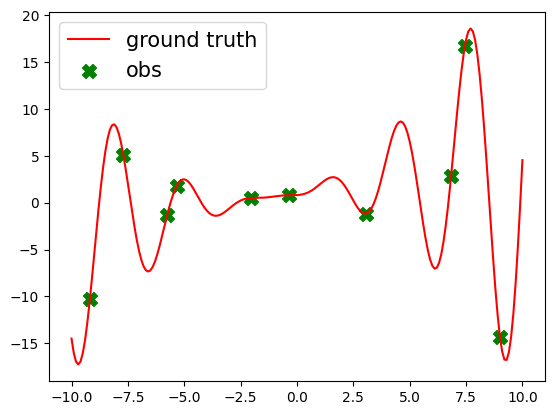

In [ ]:
plt.plot(xs, ys, label="ground truth", c="r")
plt.scatter(train_x, train_y, c="g", marker="X", label="obs", s=100)

plt.legend(fontsize=15);

# Run BO
-Here we are looking for minima point

In [ ]:
def kernel_prior() -> Dict[str, jnp.ndarray]:
    length = numpyro.sample("k_length", numpyro.distributions.LogNormal(0, 1))
    scale = numpyro.sample("k_scale", numpyro.distributions.LogNormal(0, 1))
    return {"k_length": length, "k_scale": scale}

Step:1


/usr/local/lib/python3.10/dist-packages/gpax/models/gp.py:119: UserWarning: `kernel_prior` will remain available for complex priors. However, for modifying only the lengthscales, it is recommended to use `lengthscale_prior_dist` instead. `lengthscale_prior_dist` accepts an instance of a numpyro.distributions Distribution object, e.g., `dist.Gamma(2, 5)`, rather than a function that calls `numpyro.sample`.
  warnings.warn(
sample: 100%|██████████| 1000/1000 [00:14<00:00, 67.84it/s, 7 steps of size 1.95e-01. acc. prob=0.92]



                mean       std    median      5.0%     95.0%     n_eff     r_hat
  k_length      1.03      1.28      0.56      0.03      2.45    129.69      1.03
   k_scale     13.58     19.49      2.32      0.05     43.73     29.05      1.21
     noise     27.37     20.68     29.98      0.02     53.35     34.61      1.15



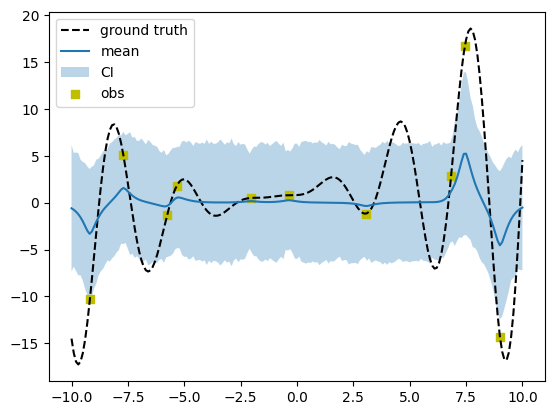

190


<ipython-input-65-d643e5944fc7>:43: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  idx = int(idx)


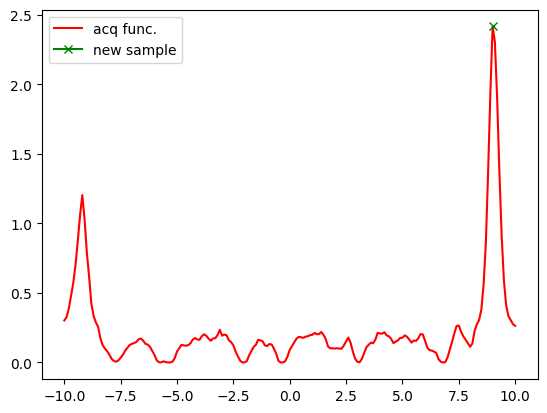

Step:2


/usr/local/lib/python3.10/dist-packages/gpax/models/gp.py:119: UserWarning: `kernel_prior` will remain available for complex priors. However, for modifying only the lengthscales, it is recommended to use `lengthscale_prior_dist` instead. `lengthscale_prior_dist` accepts an instance of a numpyro.distributions Distribution object, e.g., `dist.Gamma(2, 5)`, rather than a function that calls `numpyro.sample`.
  warnings.warn(
sample: 100%|██████████| 1000/1000 [00:11<00:00, 86.72it/s, 7 steps of size 6.58e-01. acc. prob=0.90]



                mean       std    median      5.0%     95.0%     n_eff     r_hat
  k_length      0.37      0.16      0.37      0.11      0.61    323.91      1.00
   k_scale     40.80     14.84     38.16     21.01     63.30    296.49      1.00
     noise      1.14      1.47      0.65      0.07      2.54    259.47      1.00



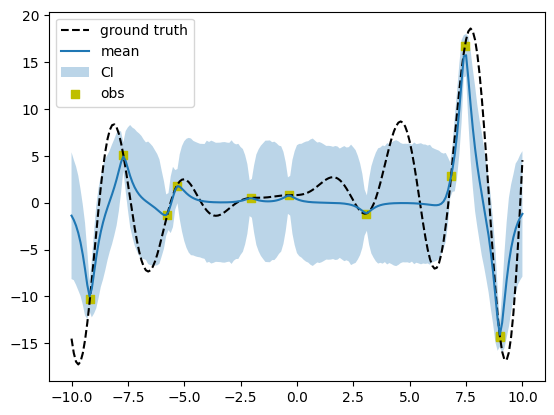

[190 191]


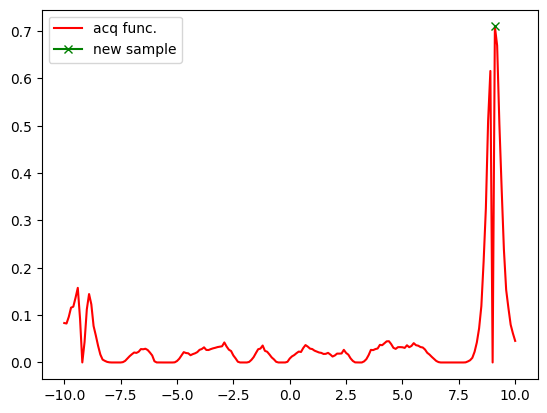

Step:3


/usr/local/lib/python3.10/dist-packages/gpax/models/gp.py:119: UserWarning: `kernel_prior` will remain available for complex priors. However, for modifying only the lengthscales, it is recommended to use `lengthscale_prior_dist` instead. `lengthscale_prior_dist` accepts an instance of a numpyro.distributions Distribution object, e.g., `dist.Gamma(2, 5)`, rather than a function that calls `numpyro.sample`.
  warnings.warn(
sample: 100%|██████████| 1000/1000 [00:10<00:00, 91.81it/s, 3 steps of size 7.97e-01. acc. prob=0.87]



                mean       std    median      5.0%     95.0%     n_eff     r_hat
  k_length      0.45      0.16      0.44      0.20      0.70    459.78      1.00
   k_scale     42.49     14.43     40.53     20.16     63.73    420.70      1.00
     noise      1.00      1.10      0.62      0.07      2.37    388.81      1.00



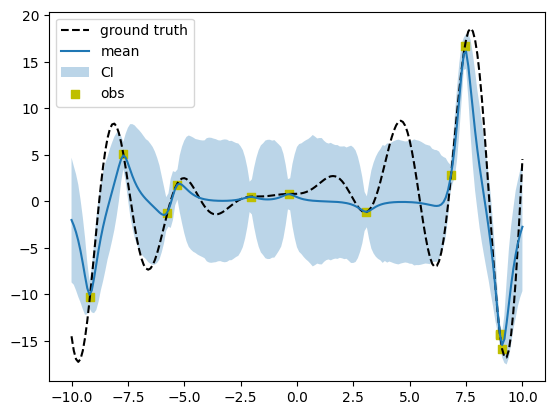

[190 191 193]


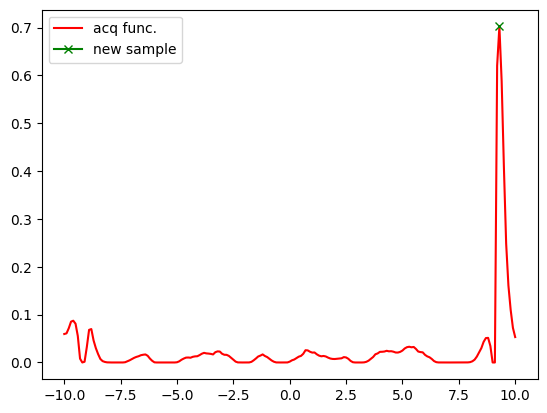

Step:4


/usr/local/lib/python3.10/dist-packages/gpax/models/gp.py:119: UserWarning: `kernel_prior` will remain available for complex priors. However, for modifying only the lengthscales, it is recommended to use `lengthscale_prior_dist` instead. `lengthscale_prior_dist` accepts an instance of a numpyro.distributions Distribution object, e.g., `dist.Gamma(2, 5)`, rather than a function that calls `numpyro.sample`.
  warnings.warn(
sample: 100%|██████████| 1000/1000 [00:11<00:00, 85.15it/s, 3 steps of size 6.95e-01. acc. prob=0.93]



                mean       std    median      5.0%     95.0%     n_eff     r_hat
  k_length      0.54      0.15      0.53      0.25      0.74    291.62      1.00
   k_scale     45.22     15.74     42.25     22.77     66.63    213.31      1.00
     noise      0.76      0.78      0.48      0.06      1.67    240.74      1.00



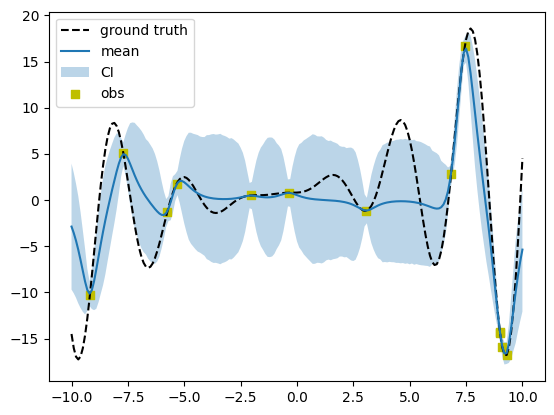

[190 191 193 192]


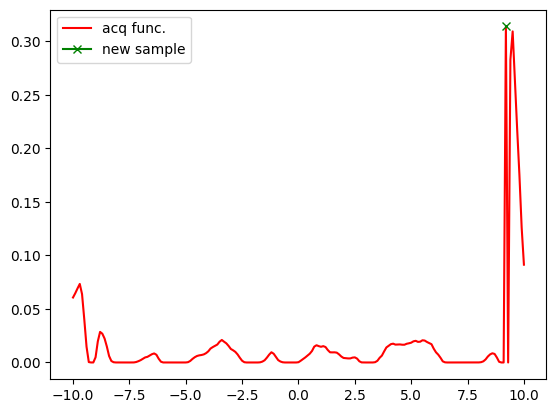

Step:5


/usr/local/lib/python3.10/dist-packages/gpax/models/gp.py:119: UserWarning: `kernel_prior` will remain available for complex priors. However, for modifying only the lengthscales, it is recommended to use `lengthscale_prior_dist` instead. `lengthscale_prior_dist` accepts an instance of a numpyro.distributions Distribution object, e.g., `dist.Gamma(2, 5)`, rather than a function that calls `numpyro.sample`.
  warnings.warn(
sample: 100%|██████████| 1000/1000 [00:13<00:00, 74.44it/s, 7 steps of size 5.64e-01. acc. prob=0.95]



                mean       std    median      5.0%     95.0%     n_eff     r_hat
  k_length      0.55      0.15      0.55      0.30      0.77    270.94      1.00
   k_scale     45.01     16.85     41.12     22.93     68.11    294.84      1.00
     noise      0.52      0.55      0.36      0.01      1.16    365.47      1.00



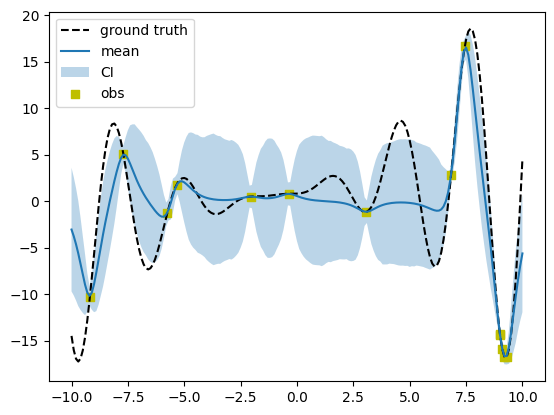

[190 191 193 192 195]


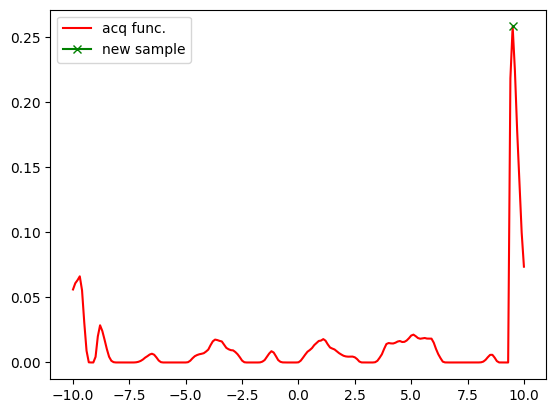

Step:6


/usr/local/lib/python3.10/dist-packages/gpax/models/gp.py:119: UserWarning: `kernel_prior` will remain available for complex priors. However, for modifying only the lengthscales, it is recommended to use `lengthscale_prior_dist` instead. `lengthscale_prior_dist` accepts an instance of a numpyro.distributions Distribution object, e.g., `dist.Gamma(2, 5)`, rather than a function that calls `numpyro.sample`.
  warnings.warn(
sample: 100%|██████████| 1000/1000 [00:12<00:00, 77.22it/s, 7 steps of size 6.65e-01. acc. prob=0.93]



                mean       std    median      5.0%     95.0%     n_eff     r_hat
  k_length      0.57      0.13      0.57      0.33      0.75    291.49      1.00
   k_scale     43.40     14.61     40.46     22.15     64.21    337.81      1.00
     noise      0.43      0.44      0.28      0.04      0.96    233.36      1.00



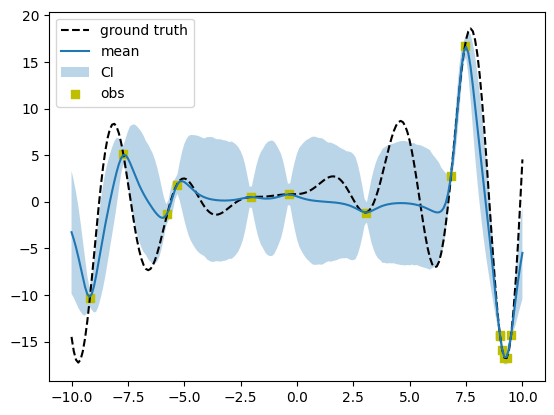

[190 191 193 192 195   2]


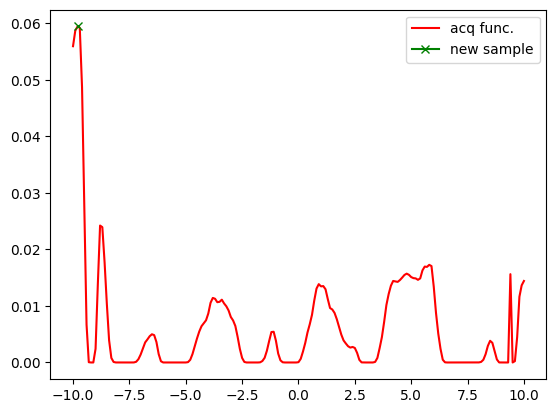

Step:7


/usr/local/lib/python3.10/dist-packages/gpax/models/gp.py:119: UserWarning: `kernel_prior` will remain available for complex priors. However, for modifying only the lengthscales, it is recommended to use `lengthscale_prior_dist` instead. `lengthscale_prior_dist` accepts an instance of a numpyro.distributions Distribution object, e.g., `dist.Gamma(2, 5)`, rather than a function that calls `numpyro.sample`.
  warnings.warn(
sample: 100%|██████████| 1000/1000 [00:08<00:00, 118.75it/s, 7 steps of size 6.64e-01. acc. prob=0.93]



                mean       std    median      5.0%     95.0%     n_eff     r_hat
  k_length      0.64      0.14      0.63      0.41      0.84    254.94      1.00
   k_scale     52.48     16.54     49.61     28.74     77.08    309.94      1.00
     noise      0.44      0.44      0.30      0.03      0.96    229.34      1.00



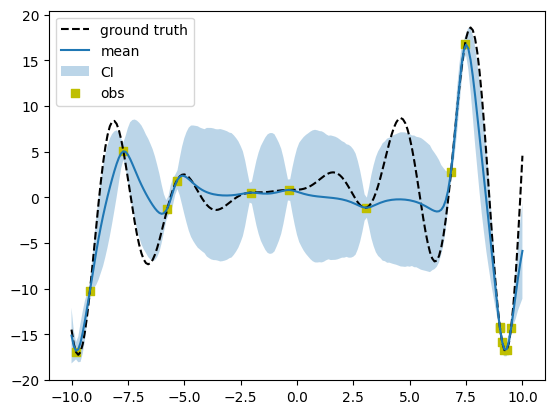

[190 191 193 192 195   2   0]


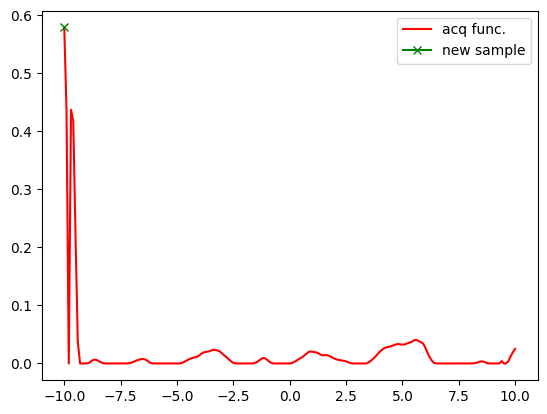

Step:8


/usr/local/lib/python3.10/dist-packages/gpax/models/gp.py:119: UserWarning: `kernel_prior` will remain available for complex priors. However, for modifying only the lengthscales, it is recommended to use `lengthscale_prior_dist` instead. `lengthscale_prior_dist` accepts an instance of a numpyro.distributions Distribution object, e.g., `dist.Gamma(2, 5)`, rather than a function that calls `numpyro.sample`.
  warnings.warn(
sample: 100%|██████████| 1000/1000 [00:14<00:00, 68.38it/s, 7 steps of size 6.74e-01. acc. prob=0.93]



                mean       std    median      5.0%     95.0%     n_eff     r_hat
  k_length      0.64      0.13      0.63      0.42      0.85    317.05      1.00
   k_scale     50.70     16.41     47.71     26.17     74.43    285.45      1.00
     noise      0.41      0.40      0.28      0.03      0.96    291.91      1.00



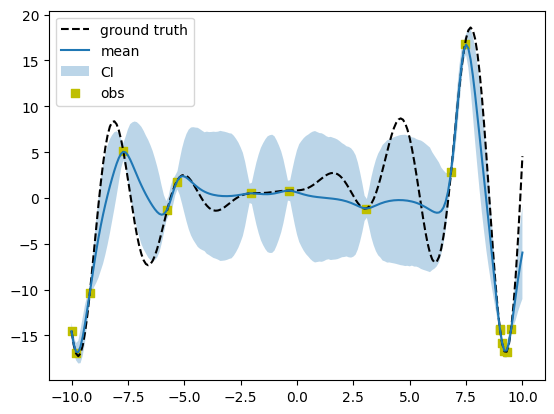

[190 191 193 192 195   2   0   3]


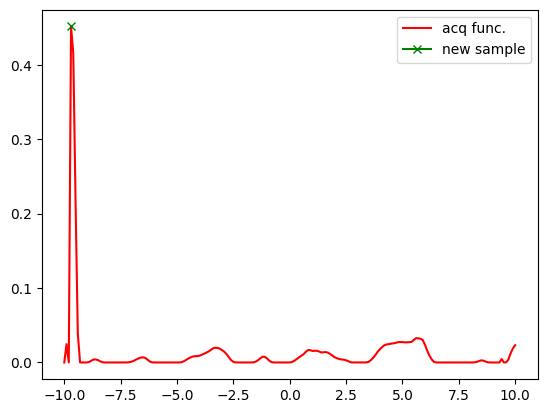

Step:9


/usr/local/lib/python3.10/dist-packages/gpax/models/gp.py:119: UserWarning: `kernel_prior` will remain available for complex priors. However, for modifying only the lengthscales, it is recommended to use `lengthscale_prior_dist` instead. `lengthscale_prior_dist` accepts an instance of a numpyro.distributions Distribution object, e.g., `dist.Gamma(2, 5)`, rather than a function that calls `numpyro.sample`.
  warnings.warn(
sample: 100%|██████████| 1000/1000 [00:16<00:00, 61.43it/s, 7 steps of size 6.36e-01. acc. prob=0.94]



                mean       std    median      5.0%     95.0%     n_eff     r_hat
  k_length      0.65      0.12      0.65      0.44      0.83    333.36      1.00
   k_scale     50.34     17.79     47.25     25.83     72.54    255.65      1.01
     noise      0.34      0.36      0.23      0.01      0.68    416.13      1.00



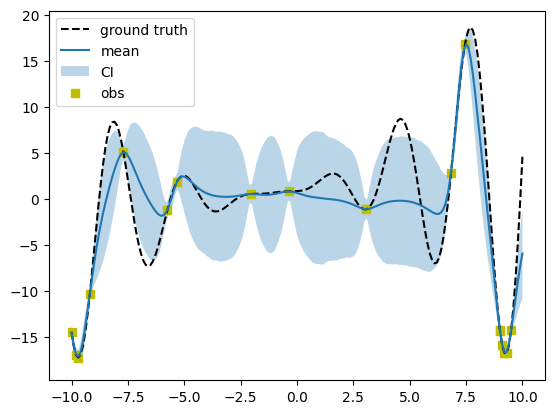

[190 191 193 192 195   2   0   3   4]


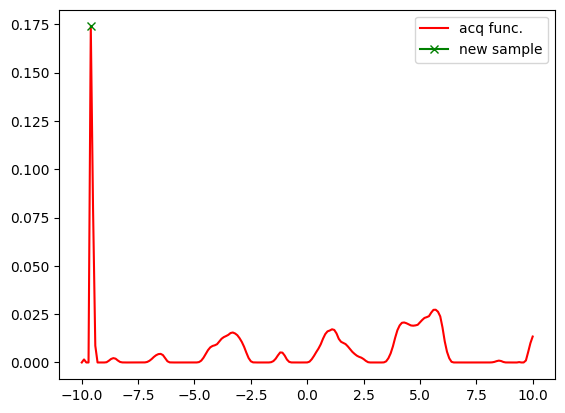

Step:10


/usr/local/lib/python3.10/dist-packages/gpax/models/gp.py:119: UserWarning: `kernel_prior` will remain available for complex priors. However, for modifying only the lengthscales, it is recommended to use `lengthscale_prior_dist` instead. `lengthscale_prior_dist` accepts an instance of a numpyro.distributions Distribution object, e.g., `dist.Gamma(2, 5)`, rather than a function that calls `numpyro.sample`.
  warnings.warn(
sample: 100%|██████████| 1000/1000 [00:16<00:00, 59.69it/s, 5 steps of size 6.46e-01. acc. prob=0.93]



                mean       std    median      5.0%     95.0%     n_eff     r_hat
  k_length      0.68      0.12      0.67      0.47      0.85    259.04      1.00
   k_scale     50.10     16.69     46.43     25.16     73.73    266.17      1.01
     noise      0.25      0.24      0.17      0.01      0.56    239.43      1.00



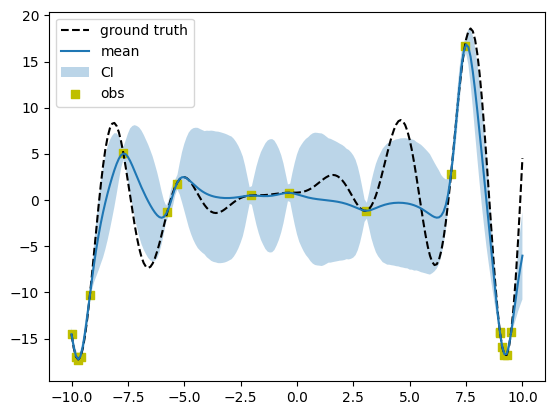

[190 191 193 192 195   2   0   3   4 156]


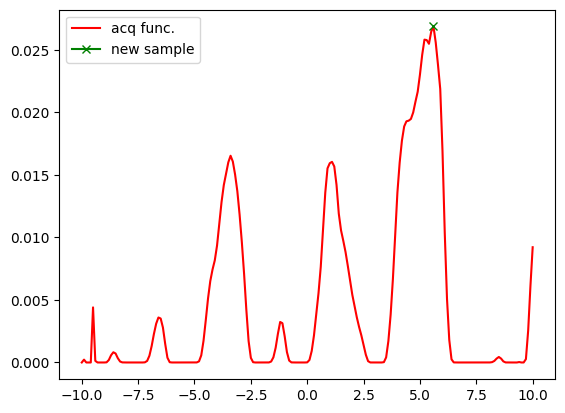

Step:11


/usr/local/lib/python3.10/dist-packages/gpax/models/gp.py:119: UserWarning: `kernel_prior` will remain available for complex priors. However, for modifying only the lengthscales, it is recommended to use `lengthscale_prior_dist` instead. `lengthscale_prior_dist` accepts an instance of a numpyro.distributions Distribution object, e.g., `dist.Gamma(2, 5)`, rather than a function that calls `numpyro.sample`.
  warnings.warn(
sample: 100%|██████████| 1000/1000 [00:17<00:00, 57.31it/s, 5 steps of size 6.83e-01. acc. prob=0.92]



                mean       std    median      5.0%     95.0%     n_eff     r_hat
  k_length      0.68      0.12      0.68      0.49      0.87    275.37      1.00
   k_scale     47.88     15.03     44.93     26.68     69.42    372.75      1.00
     noise      0.25      0.23      0.17      0.03      0.57    277.35      1.01



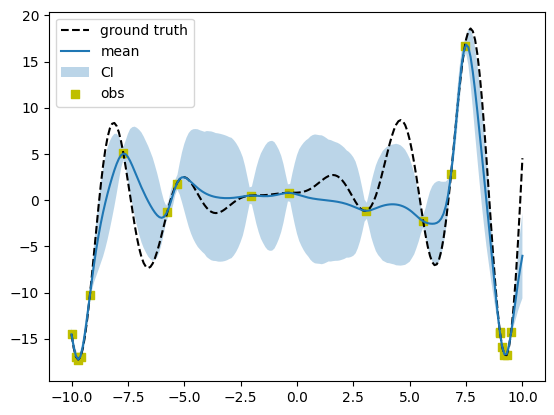

[190 191 193 192 195   2   0   3   4 156 144]


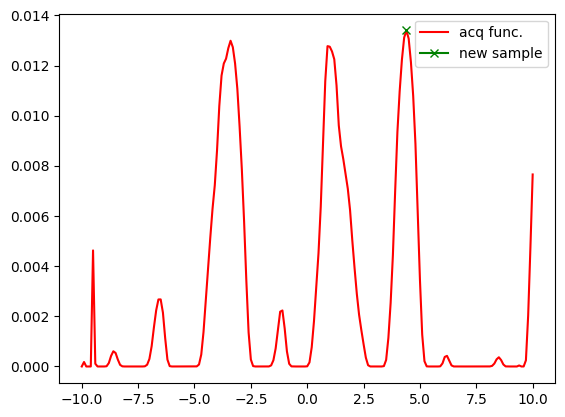

Step:12


/usr/local/lib/python3.10/dist-packages/gpax/models/gp.py:119: UserWarning: `kernel_prior` will remain available for complex priors. However, for modifying only the lengthscales, it is recommended to use `lengthscale_prior_dist` instead. `lengthscale_prior_dist` accepts an instance of a numpyro.distributions Distribution object, e.g., `dist.Gamma(2, 5)`, rather than a function that calls `numpyro.sample`.
  warnings.warn(
sample: 100%|██████████| 1000/1000 [00:18<00:00, 53.59it/s, 7 steps of size 6.02e-01. acc. prob=0.94]



                mean       std    median      5.0%     95.0%     n_eff     r_hat
  k_length      0.67      0.12      0.67      0.48      0.85    371.77      1.00
   k_scale     48.75     15.26     46.63     26.06     69.29    281.60      1.01
     noise      0.26      0.25      0.19      0.01      0.58    266.29      1.00



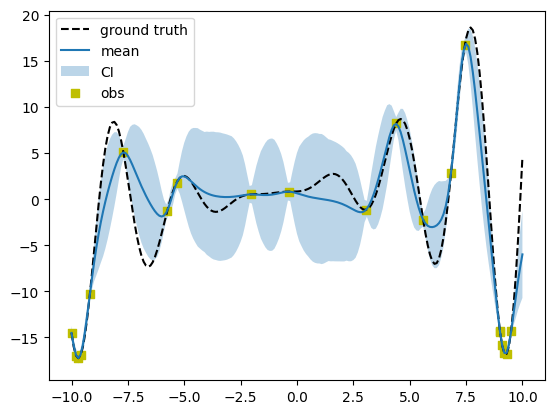

[190 191 193 192 195   2   0   3   4 156 144 111]


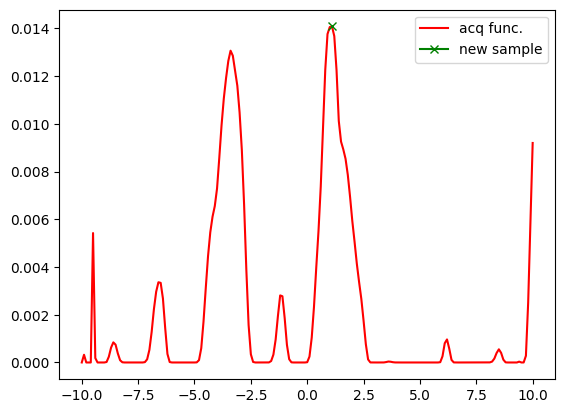

Step:13


/usr/local/lib/python3.10/dist-packages/gpax/models/gp.py:119: UserWarning: `kernel_prior` will remain available for complex priors. However, for modifying only the lengthscales, it is recommended to use `lengthscale_prior_dist` instead. `lengthscale_prior_dist` accepts an instance of a numpyro.distributions Distribution object, e.g., `dist.Gamma(2, 5)`, rather than a function that calls `numpyro.sample`.
  warnings.warn(
sample: 100%|██████████| 1000/1000 [00:18<00:00, 53.16it/s, 3 steps of size 8.13e-01. acc. prob=0.89]



                mean       std    median      5.0%     95.0%     n_eff     r_hat
  k_length      0.67      0.12      0.67      0.47      0.86    367.12      1.00
   k_scale     48.48     15.42     45.02     27.88     71.64    271.35      1.00
     noise      0.25      0.24      0.17      0.01      0.53    281.65      1.00



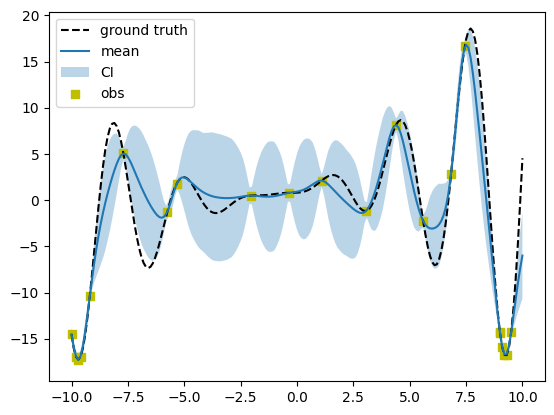

[190 191 193 192 195   2   0   3   4 156 144 111  66]


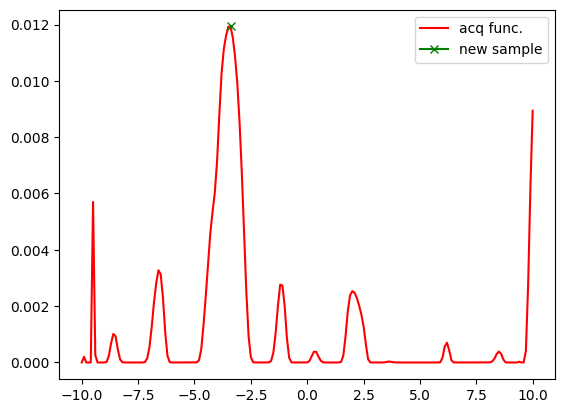

Step:14


/usr/local/lib/python3.10/dist-packages/gpax/models/gp.py:119: UserWarning: `kernel_prior` will remain available for complex priors. However, for modifying only the lengthscales, it is recommended to use `lengthscale_prior_dist` instead. `lengthscale_prior_dist` accepts an instance of a numpyro.distributions Distribution object, e.g., `dist.Gamma(2, 5)`, rather than a function that calls `numpyro.sample`.
  warnings.warn(
sample: 100%|██████████| 1000/1000 [00:19<00:00, 50.18it/s, 7 steps of size 6.65e-01. acc. prob=0.93]



                mean       std    median      5.0%     95.0%     n_eff     r_hat
  k_length      0.67      0.11      0.67      0.50      0.86    286.97      1.00
   k_scale     45.59     13.52     42.70     27.42     66.42    348.61      1.00
     noise      0.24      0.24      0.17      0.01      0.54    269.86      1.00



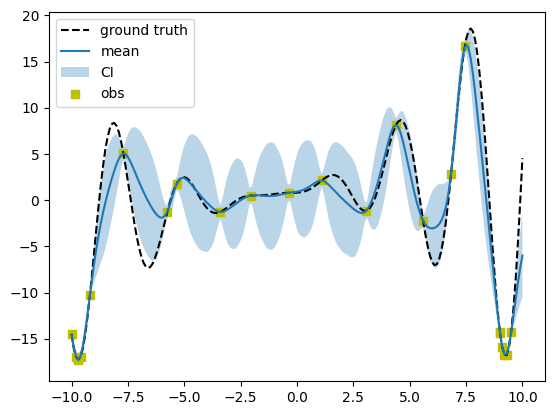

[190 191 193 192 195   2   0   3   4 156 144 111  66 200]


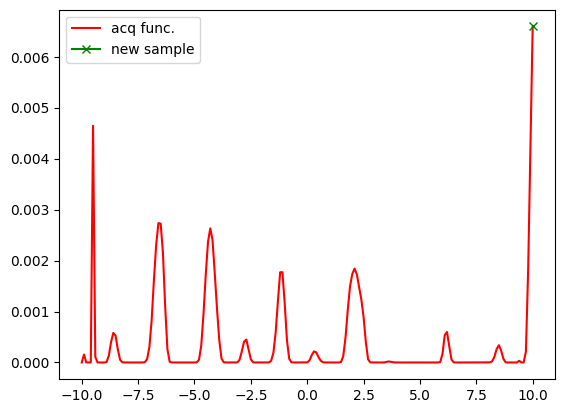

Step:15


/usr/local/lib/python3.10/dist-packages/gpax/models/gp.py:119: UserWarning: `kernel_prior` will remain available for complex priors. However, for modifying only the lengthscales, it is recommended to use `lengthscale_prior_dist` instead. `lengthscale_prior_dist` accepts an instance of a numpyro.distributions Distribution object, e.g., `dist.Gamma(2, 5)`, rather than a function that calls `numpyro.sample`.
  warnings.warn(
sample: 100%|██████████| 1000/1000 [00:20<00:00, 48.92it/s, 7 steps of size 7.22e-01. acc. prob=0.91]



                mean       std    median      5.0%     95.0%     n_eff     r_hat
  k_length      0.59      0.11      0.59      0.42      0.77    222.75      1.00
   k_scale     49.97     15.77     47.26     27.81     77.61    206.91      1.00
     noise      0.27      0.25      0.18      0.03      0.62    373.10      1.00



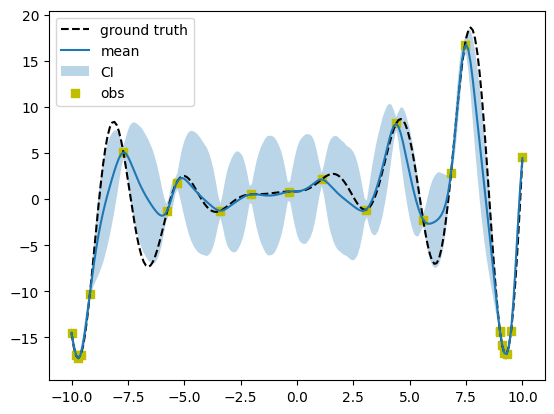

[190 191 193 192 195   2   0   3   4 156 144 111  66 200   5]


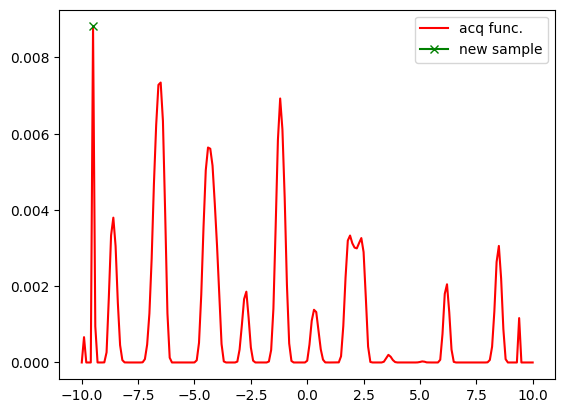

In [ ]:
N = 15
X_test =xs
X_test_full = xs


# Get random number generator keys for training and prediction
rng_key, rng_key_predict = gpax.utils.get_keys()
idx = []
for i in range(1, N+1):
    print("Step:"+str(i))


    # Initialize model
    gp_model = gpax.ExactGP(1, kernel='Matern', kernel_prior = kernel_prior)
    # Run Hamiltonian Monte Carlo to obtain posterior samples for kernel parameters and model noise
    gp_model.fit(rng_key, train_x, train_y, num_warmup=500, num_samples=500, num_chains=1)

    y_pred, y_sampled = gp_model.predict(rng_key_predict, X_test)
    plt.plot(xs, ys, "k--", label="ground truth")
    pred_lower = y_pred - y_sampled.std(axis=(0,1))
    pred_upper = y_pred + y_sampled.std(axis=(0,1))
    plt.plot(xs, y_pred, label="mean")
    plt.fill_between(
        xs.flatten(),
        pred_lower,
        pred_upper,
        alpha=0.3,
        label="CI",
    )
    plt.scatter(train_x, train_y, c="y", marker="s", label="obs")

    plt.legend(loc="best")
    plt.show()
    # Compute the EI acq function
    acq = gpax.acquisition.EI(rng_key_predict, gp_model, X_test, maximize=False, noiseless=True)
    acq = np.array(acq)
    acq[idx] = 0
    next_point_val = acq.max()
    next_point_idx = acq.argmax()
    idx = np.hstack((idx, next_point_idx))

    if len(idx) == 1:
        idx = int(idx)
        print(idx)
    else:
        idx = idx
        print(idx)


    if next_point_val == 0:
        print("Model sufficiently learned")
        break
    else:
      # Data Augmentation
        next_point = X_test[next_point_idx]
        train_x = np.vstack((train_x, next_point))
        train_y = objective(train_x)

    #Plot acquistion function
    plt.plot(xs, acq, "r", label="acq func.")
    plt.plot(next_point, next_point_val, c="g", marker="x", label="new sample")
    plt.legend(loc="best")
    plt.show()


Reached both the global optimal points at iteration 7 (total 17 samples)

In [ ]:
#@title Problem 2: Ising model
class IsingSim():

  """This class performs Ising model simulations on a 2D grid. Interaction parameters are given by a matrix at each lattice site.
  Field dependence is not supported at this time but will be in due course. The simulator outputs configurations after equlibrium
  as well as the trajectories, if specifically requested.
  Inputs:
    - N : (integer) - Size of lattice will be N^2. Only 2D square lattice is supported at this stage.
    - J_mat: (numpy matrix of shape(5,5)) - entries being floats for interaction parameters. Self-interaction (middle element of matrix)=0.
    - T: (float) - Reduced temperature for simulation
    - save_trajectories: (Boolean) - whether to save trajectories, or only final state. Default False.
    - eqSteps: (integer) number of Monte-Carlo steps for equlibration before simulation starts. Default 750. AKA 'burn-in'.
    - mcSteps: (integer) number of Monte-Carlo for simulation. Default 750.
  Outputs: Several outputs are available, including trajectories (if called), configurations (i.e., the 2D states) and configurations histograms.
  These can be obtained by calling methods self.configurations(), self.histograms() and self.trajectories()"""

  def __init__(self, N = 40, J_mat = None, T = 2.7, save_trajectories = False,
               eqSteps = 750, mcSteps = 750):
    self.N = N

    #If no J matrix is provided we default to isotropic J interaction with NN with value 0.5
    if np.array(J_mat).all() == None:
      J_mat = np.zeros((5,5))
      J_mat[1,2] = J_mat[2,1] = J_mat[2,3] = J_mat[3,2] = 0.5 #Defaulting to 0.5 for NN, all others zeroed out.

    self.J_mat = J_mat

    self.save_trajectories = save_trajectories
    self.eqSteps = eqSteps
    self.mcSteps = mcSteps
    self.config = self.initialState(random = False)
    self.T = T

  def initialState(self, random = False):
    ''' Generates a lattice with spin configurations drawn randomly [-1 or 1] if random=True
    Else, the lattice is generated with all sites = 1 '''

    if random==True: state = 2*np.random.randint(2, size=(self.N,self.N))-1
    else: state = np.ones([self.N,self.N])

    return state

  def mcmove(self, config):
    '''Monte Carlo move using Metropolis algorithm '''

    M = 5 #neighborhood size (M^2). Do not change!
    beta = 1.0/self.T

    for i in range(self.N):
      for j in range(self.N):
        J_mat = self.J_mat
        cost = 0.0
        s =  np.copy(config[i, j])

        for p in range(-int(M/2), int(M/2)+1, 1):
          for q in range(-int(M/2), int(M/2)+1, 1):
            cost += 2 * J_mat[int(M/2)+p, int(M/2)+q] * config[(i+p)%self.N,(j+q)%self.N] * config[i,j]

        if cost < 0:
          s *= -1
        elif rand() < np.exp(-cost*beta):
          s *= -1
        config[i, j] = s
    return config


  def calcEnergy(self, config):
    '''Returns the energy of the current configuration'''
    M = 5
    energy = 0.0
    for i in range(len(config)):
      for j in range(len(config)):
        J_mat = self.J_mat #otherwise, no

        s = config[i,j]
        for p in range(-int(M/2), int(M/2)+1, 1):
          for q in range(-int(M/2), int(M/2)+1, 1):
            energy += -J_mat[int(M/2)+p, int(M/2)+q] * config[(i+p)%self.N,(j+q)%self.N] * config[i,j]

    return energy/4.0


  def calcMag(self, config):
    '''Magnetization of a given configuration'''
    return np.sum(config)

  def calcAbsMag(self, config):
    ''' Absolute Magnetization of a given configuration'''
    return (np.abs(np.sum(config)))*1.0

  def performIsingSim(self):

    E1, M1, E2, M2 = 0.0,0.0,0.0,0.0    #These are all the average properties of all MC steps used
    E_traj, M_traj = np.zeros(self.mcSteps), np.zeros(self.mcSteps)

    config = np.copy(self.config)
    T = self.T
    if self.save_trajectories: config_mat = np.zeros([self.mcSteps,self.N,self.N])   #Saving all the configurations


    print('\n---Performing Equlibration---\n')
    for i in tqdm(range(self.eqSteps)):
        config = self.mcmove(config)

    print('\n---Finished...\n----Performing MC Moves----\n')
    for j in tqdm(range(self.mcSteps)):
        config = self.mcmove(config)
        Ene, Mag = self.calcEnergy(config), self.calcAbsMag(config)
        E_traj[j] = self.calcEnergy(config)/(self.N*self.N)
        M_traj[j] = self.calcAbsMag(config)/(self.N*self.N)

        E1 = E1 + Ene
        M1 = M1 + Mag
        M2 = M2 + Mag * Mag
        E2 = E2 + Ene * Ene

        if self.save_trajectories: config_mat[j] = config

    print('Completed. Saving')
    Energy = E1 / (self.mcSteps * self.N * self.N)
    Magnetization = M1 / (self.mcSteps * self.N * self.N)
    n1, n2  = 1.0/(self.mcSteps*self.N*self.N), 1.0/(self.mcSteps*self.mcSteps*self.N*self.N)
    iT = 1.0/self.T
    iT2 = iT*iT
    SpecificHeat = (n1*E2 - n2*E1*E1)*iT2
    Susceptibility = (n1*M2 - n2*M1*M1)*iT
    # SpecificHeat = (E2 / self.mcSteps - E1 * E1 / (self.mcSteps * self.mcSteps)) / (self.N * self.T * self.T)
    # Susceptibility = (M2 / self.mcSteps - M1 * M1 / (self.mcSteps * self.mcSteps)) / (self.N * self.T)

    self.config = config


    if self.save_trajectories:
      results_dict = {'config': config_mat, 'Energy': Energy, 'Magnetization': Magnetization,
      'SpecificHeat': SpecificHeat, 'Susceptibility': Susceptibility, 'E_traj': E_traj,
      'M_traj': M_traj,
      }
    else:
      results_dict = {'Energy': Energy, 'Magnetization': Magnetization,
      'SpecificHeat': SpecificHeat, 'Susceptibility': Susceptibility,
      'E_traj': E_traj, 'M_traj': M_traj,}

    self.results = results_dict

    return 'Completed simulation'

# Defining parameter space and grid points

In [25]:
lb = 0
ub = 3
N_total = 201
bounds = np.array((lb, ub), dtype=float)
fidelities = np.array((0.95, 1.0))

xs = np.linspace(lb, ub, N_total)
xs_norm = (xs-lb)/(ub-lb)

# Load Groung truth data

- 20x20 Ising model simulation

In [26]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
#results_dict_square = np.load("/content/gdrive/MyDrive/Colab Notebooks/sMFBO/results_dict_square.npy", allow_pickle=True)
#results_dict_square = dict(enumerate(results_dict_square.flatten(), 1))


In [27]:
!gdown https://drive.google.com/uc?id=15WdrsmIsAOSD5SaU5OMmdZAhucisKQHF
results_dict_square = np.load("results_dict_square.npy", allow_pickle=True)
results_dict_square = dict(enumerate(results_dict_square.flatten(), 1))



Downloading...
From (original): https://drive.google.com/uc?id=15WdrsmIsAOSD5SaU5OMmdZAhucisKQHF
From (redirected): https://drive.google.com/uc?id=15WdrsmIsAOSD5SaU5OMmdZAhucisKQHF&confirm=t&uuid=9652cc58-a499-487b-abdb-93591920cc81
To: /content/results_dict_square.npy
100% 323M/323M [00:03<00:00, 81.7MB/s]


In [28]:
true_ys_sq = np.zeros(xs.shape[0])
for i in range(0, xs.shape[0]):
    true_ys_sq[i] = results_dict_square[1][i]['sim']['SpecificHeat']


# Plot ground truth - Ising model with lattice size 20

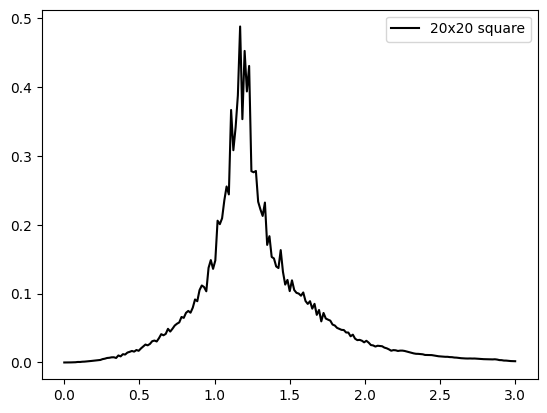

In [29]:

plt.plot(xs, true_ys_sq, "k", label="20x20 square")
plt.legend(loc="best")

In [30]:
np.argmax(true_ys_sq)
xs[np.argmax(true_ys_sq)]

1.17

# Bayesian Optimization

- Maximize the heat capacity

Initial Sampling- 10 samples

In [ ]:
n = 5

np.random.seed(10)
train_x = bounds[0] + (bounds[1] - bounds[0]) * np.random.rand(n, 1)
train_x_norm = (train_x-bounds[0])/(bounds[1]-bounds[0])
train_x_full = train_x
train_x_full_norm = train_x_norm
train_x_full, train_x_full_norm

(array([[2.31396193],
        [0.06225585],
        [1.9009447 ],
        [2.24641165],
        [1.49552104]]),
 array([[0.77132064],
        [0.02075195],
        [0.63364823],
        [0.74880388],
        [0.49850701]]))

Evaluation 1 of 5

---Performing Equlibration---



100%|██████████| 500/500 [00:06<00:00, 73.00it/s]



---Finished...
----Performing MC Moves----



100%|██████████| 500/500 [00:17<00:00, 28.65it/s]


Completed. Saving
Time (s) to complete simulation 1: 24.31067967414856


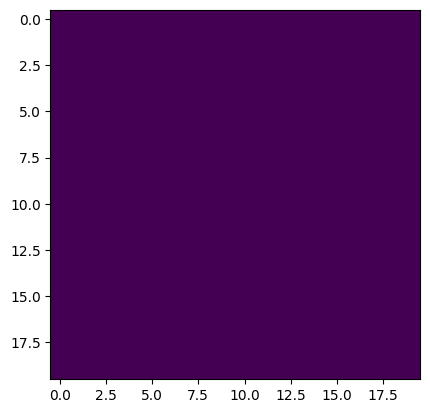

Evaluation 2 of 5

---Performing Equlibration---



100%|██████████| 500/500 [00:08<00:00, 61.78it/s]



---Finished...
----Performing MC Moves----



100%|██████████| 500/500 [00:18<00:00, 27.28it/s]


Completed. Saving
Time (s) to complete simulation 2: 26.43848156929016


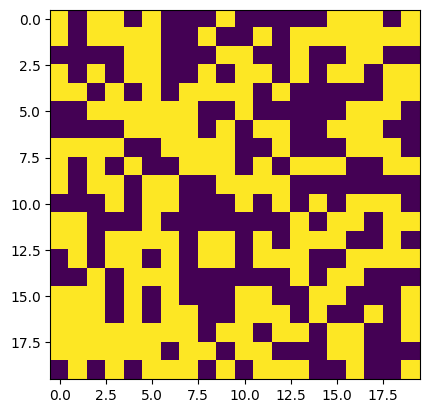

Evaluation 3 of 5

---Performing Equlibration---



100%|██████████| 500/500 [00:06<00:00, 74.10it/s]



---Finished...
----Performing MC Moves----



100%|██████████| 500/500 [00:17<00:00, 28.74it/s]


Completed. Saving
Time (s) to complete simulation 3: 24.15605592727661


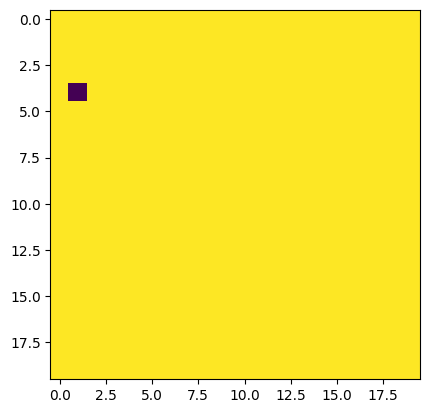

Evaluation 4 of 5

---Performing Equlibration---



100%|██████████| 500/500 [00:06<00:00, 75.12it/s]



---Finished...
----Performing MC Moves----



100%|██████████| 500/500 [00:16<00:00, 29.76it/s]


Completed. Saving
Time (s) to complete simulation 4: 23.464351892471313


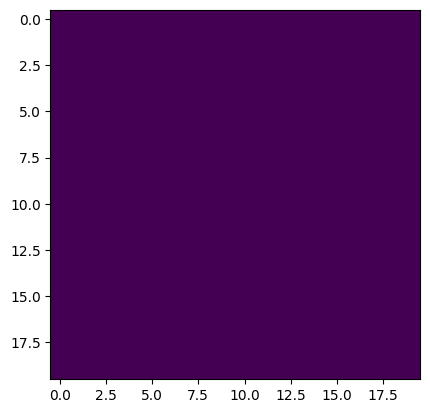

Evaluation 5 of 5

---Performing Equlibration---



100%|██████████| 500/500 [00:06<00:00, 74.72it/s]



---Finished...
----Performing MC Moves----



100%|██████████| 500/500 [00:17<00:00, 28.52it/s]


Completed. Saving
Time (s) to complete simulation 5: 24.236021041870117


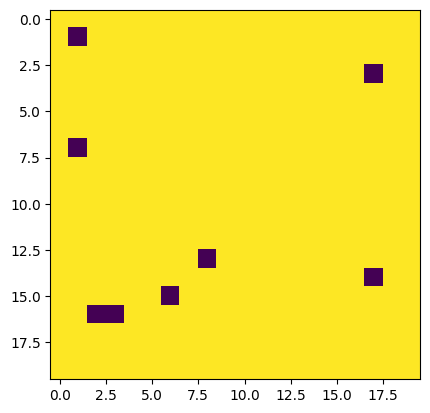

In [ ]:
train_y = np.zeros(train_x.shape)
Jx=train_x
resultsBO_dict = {}
for i in range(0, train_x.shape[0]):
    J_mat = np.array([[0,0,0,0,0],
                      [0,0,Jx[i, 0],0,0],
                      [0,Jx[i, 0],0,Jx[i, 0],0],
                      [0,0,Jx[i, 0],0,0],
                      [0,0,0,0,0]])
    print("Evaluation " +str (i+1) +" of " +str(n))
    start_time = time.time()
    np.random.seed(0)
    sq_sim = IsingSim(N = 20, J_mat = J_mat, T = 2.7, save_trajectories=True, eqSteps = 500, mcSteps = 500)  # Intializing the object

    sq_sim.performIsingSim()   # Running the sim
    end_time = time.time()
    #time_eval[i]= end_time-start_time
    print("Time (s) to complete simulation " +str(i+1)+ ": " +str(end_time-start_time))
    resultsBO_dict[i] = {'sim': sq_sim.results,}
    train_y[i] = resultsBO_dict[i]['sim']['SpecificHeat']
    plt.imshow(resultsBO_dict[i]['sim']['config'][-1])
    plt.show()

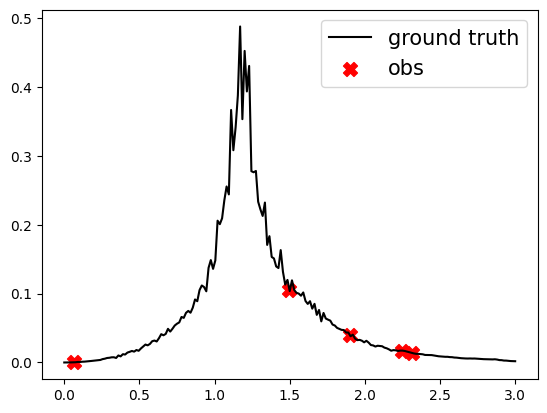

In [ ]:
plt.plot(xs, true_ys_sq, "k", label="ground truth")

plt.scatter(train_x, train_y, c="r", marker="X", label="obs", s=100)

plt.legend(fontsize=15);

In [ ]:
#train_x_full = train_x_full[0:n]
#train_x_full_norm = train_x_full_norm[0:n]
#train_y = train_y[0:n]
#train_x_full, train_x_full_norm, train_y

# Define GP prior distribution

In [ ]:
def kernel_prior() -> Dict[str, jnp.ndarray]:
    length = numpyro.sample("k_length", numpyro.distributions.Uniform(0.01, 1))
    scale = numpyro.sample("k_scale", numpyro.distributions.Uniform(0.01, 1))
    return {"k_length": length, "k_scale": scale}

In [ ]:
train_x_full = train_x_full[0:n]
train_x_full_norm = train_x_full_norm[0:n]
train_y = train_y[0:n]
train_x_full, train_x_full_norm, train_y

(array([[2.31396193],
        [0.06225585],
        [1.9009447 ],
        [2.24641165],
        [1.49552104]]),
 array([[0.77132064],
        [0.02075195],
        [0.63364823],
        [0.74880388],
        [0.49850701]]),
 array([[0.01413402],
        [0.00039374],
        [0.03967774],
        [0.01734454],
        [0.10521883]]))

# Run BO

Step:1


/usr/local/lib/python3.10/dist-packages/gpax/models/gp.py:111: FutureWarning: `noise_prior` is deprecated and will be removed in a future version. Please use `noise_prior_dist` instead, which accepts an instance of a numpyro.distributions Distribution object, e.g., `dist.HalfNormal(scale=0.1)`, rather than a function that calls `numpyro.sample`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/gpax/models/gp.py:119: UserWarning: `kernel_prior` will remain available for complex priors. However, for modifying only the lengthscales, it is recommended to use `lengthscale_prior_dist` instead. `lengthscale_prior_dist` accepts an instance of a numpyro.distributions Distribution object, e.g., `dist.Gamma(2, 5)`, rather than a function that calls `numpyro.sample`.
  warnings.warn(
sample: 100%|██████████| 1000/1000 [00:08<00:00, 124.61it/s, 7 steps of size 5.13e-01. acc. prob=0.90]



                mean       std    median      5.0%     95.0%     n_eff     r_hat
  k_length      0.64      0.24      0.68      0.28      0.98    421.27      1.00
   k_scale      0.17      0.21      0.08      0.01      0.46    280.73      1.00
     noise      0.01      0.01      0.00      0.00      0.02    339.35      1.00



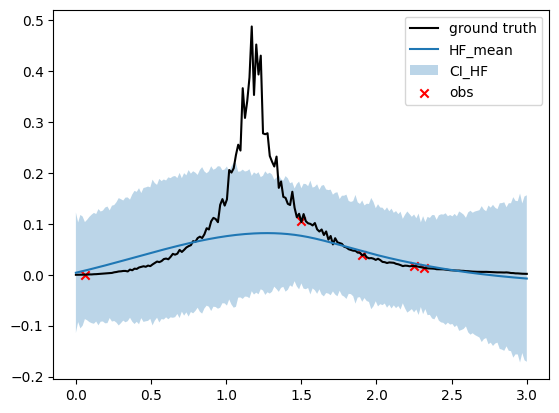

60


<ipython-input-84-27af92f9428f>:46: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  idx = int(idx)


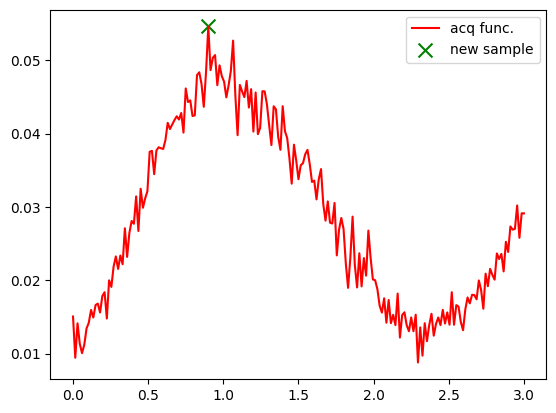

0.8999999999999999 0.8999999999999999
Evaluation 6 of 20

---Performing Equlibration---



100%|██████████| 500/500 [00:06<00:00, 72.46it/s]



---Finished...
----Performing MC Moves----



100%|██████████| 500/500 [00:17<00:00, 29.34it/s]


Completed. Saving
Time (s) to complete simulation 2: 23.955214977264404


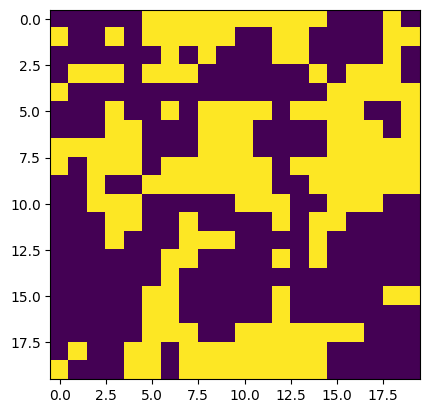

Step:2


/usr/local/lib/python3.10/dist-packages/gpax/models/gp.py:111: FutureWarning: `noise_prior` is deprecated and will be removed in a future version. Please use `noise_prior_dist` instead, which accepts an instance of a numpyro.distributions Distribution object, e.g., `dist.HalfNormal(scale=0.1)`, rather than a function that calls `numpyro.sample`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/gpax/models/gp.py:119: UserWarning: `kernel_prior` will remain available for complex priors. However, for modifying only the lengthscales, it is recommended to use `lengthscale_prior_dist` instead. `lengthscale_prior_dist` accepts an instance of a numpyro.distributions Distribution object, e.g., `dist.Gamma(2, 5)`, rather than a function that calls `numpyro.sample`.
  warnings.warn(
sample: 100%|██████████| 1000/1000 [00:08<00:00, 119.65it/s, 7 steps of size 4.89e-01. acc. prob=0.92]



                mean       std    median      5.0%     95.0%     n_eff     r_hat
  k_length      0.67      0.20      0.69      0.35      0.97    357.23      1.00
   k_scale      0.13      0.16      0.07      0.01      0.35    297.50      1.00
     noise      0.00      0.01      0.00      0.00      0.01    332.60      1.00



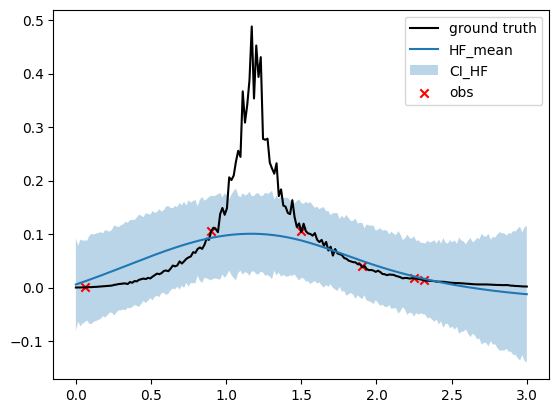

[60 71]


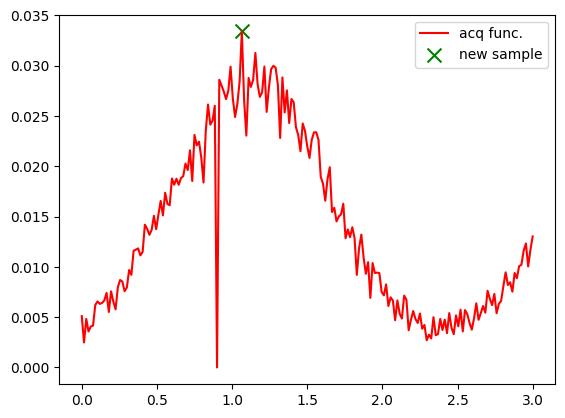

1.065 1.065
Evaluation 7 of 20

---Performing Equlibration---



100%|██████████| 500/500 [00:06<00:00, 72.56it/s]



---Finished...
----Performing MC Moves----



100%|██████████| 500/500 [00:16<00:00, 29.78it/s]


Completed. Saving
Time (s) to complete simulation 3: 23.69040846824646


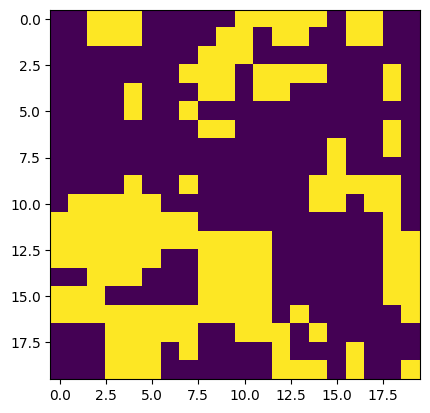

Step:3


/usr/local/lib/python3.10/dist-packages/gpax/models/gp.py:111: FutureWarning: `noise_prior` is deprecated and will be removed in a future version. Please use `noise_prior_dist` instead, which accepts an instance of a numpyro.distributions Distribution object, e.g., `dist.HalfNormal(scale=0.1)`, rather than a function that calls `numpyro.sample`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/gpax/models/gp.py:119: UserWarning: `kernel_prior` will remain available for complex priors. However, for modifying only the lengthscales, it is recommended to use `lengthscale_prior_dist` instead. `lengthscale_prior_dist` accepts an instance of a numpyro.distributions Distribution object, e.g., `dist.Gamma(2, 5)`, rather than a function that calls `numpyro.sample`.
  warnings.warn(
sample: 100%|██████████| 1000/1000 [00:08<00:00, 122.72it/s, 7 steps of size 5.59e-01. acc. prob=0.90]



                mean       std    median      5.0%     95.0%     n_eff     r_hat
  k_length      0.63      0.24      0.65      0.28      1.00    353.93      1.00
   k_scale      0.18      0.20      0.11      0.01      0.47    396.64      1.00
     noise      0.01      0.01      0.01      0.00      0.02    261.69      1.00



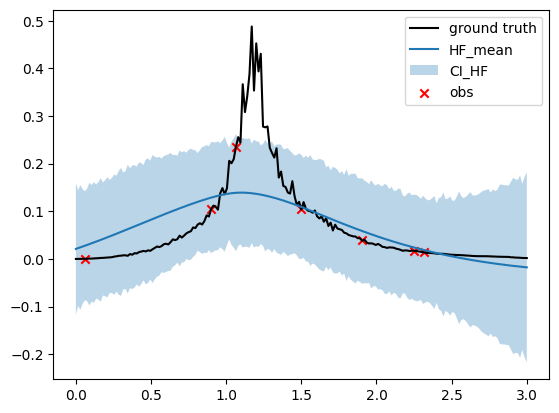

[60 71 74]


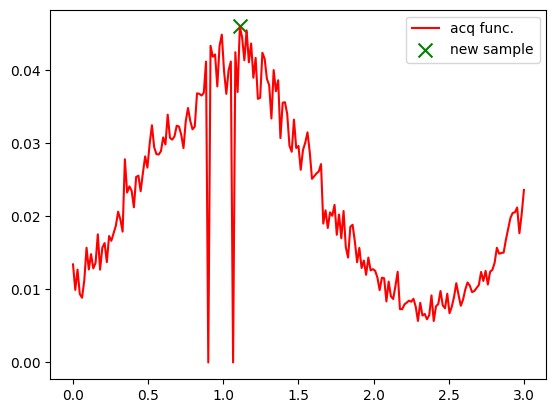

1.1099999999999999 1.1099999999999999
Evaluation 8 of 20

---Performing Equlibration---



100%|██████████| 500/500 [00:06<00:00, 74.44it/s]



---Finished...
----Performing MC Moves----



100%|██████████| 500/500 [00:17<00:00, 29.07it/s]


Completed. Saving
Time (s) to complete simulation 4: 23.927536487579346


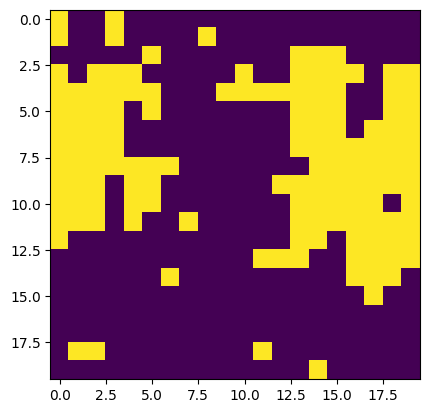

Step:4


/usr/local/lib/python3.10/dist-packages/gpax/models/gp.py:111: FutureWarning: `noise_prior` is deprecated and will be removed in a future version. Please use `noise_prior_dist` instead, which accepts an instance of a numpyro.distributions Distribution object, e.g., `dist.HalfNormal(scale=0.1)`, rather than a function that calls `numpyro.sample`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/gpax/models/gp.py:119: UserWarning: `kernel_prior` will remain available for complex priors. However, for modifying only the lengthscales, it is recommended to use `lengthscale_prior_dist` instead. `lengthscale_prior_dist` accepts an instance of a numpyro.distributions Distribution object, e.g., `dist.Gamma(2, 5)`, rather than a function that calls `numpyro.sample`.
  warnings.warn(
sample: 100%|██████████| 1000/1000 [00:07<00:00, 129.63it/s, 3 steps of size 5.48e-01. acc. prob=0.90]



                mean       std    median      5.0%     95.0%     n_eff     r_hat
  k_length      0.59      0.25      0.62      0.23      1.00    298.94      1.00
   k_scale      0.22      0.22      0.13      0.01      0.60    259.32      1.00
     noise      0.02      0.01      0.01      0.00      0.03    338.36      1.00



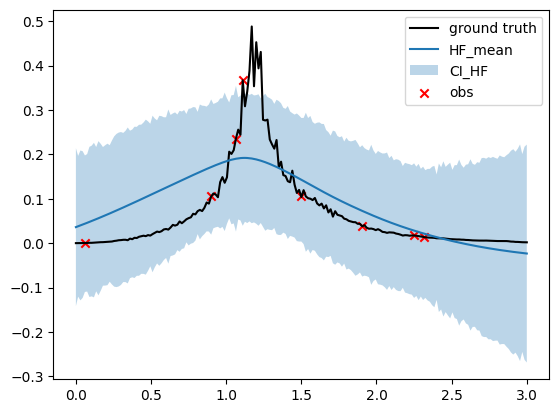

[60 71 74 78]


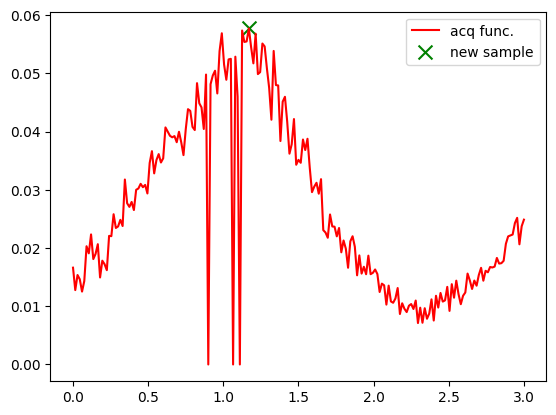

1.17 1.17
Evaluation 9 of 20

---Performing Equlibration---



100%|██████████| 500/500 [00:06<00:00, 75.45it/s]



---Finished...
----Performing MC Moves----



100%|██████████| 500/500 [00:17<00:00, 28.59it/s]


Completed. Saving
Time (s) to complete simulation 5: 24.131162643432617


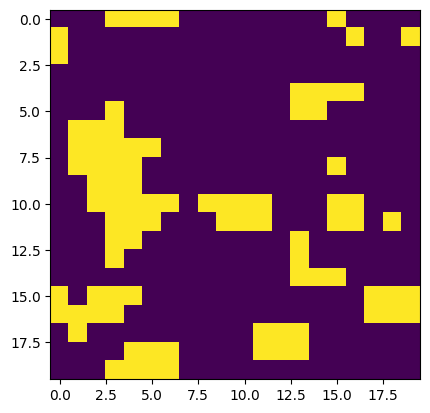

Step:5


/usr/local/lib/python3.10/dist-packages/gpax/models/gp.py:111: FutureWarning: `noise_prior` is deprecated and will be removed in a future version. Please use `noise_prior_dist` instead, which accepts an instance of a numpyro.distributions Distribution object, e.g., `dist.HalfNormal(scale=0.1)`, rather than a function that calls `numpyro.sample`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/gpax/models/gp.py:119: UserWarning: `kernel_prior` will remain available for complex priors. However, for modifying only the lengthscales, it is recommended to use `lengthscale_prior_dist` instead. `lengthscale_prior_dist` accepts an instance of a numpyro.distributions Distribution object, e.g., `dist.Gamma(2, 5)`, rather than a function that calls `numpyro.sample`.
  warnings.warn(
sample: 100%|██████████| 1000/1000 [00:09<00:00, 102.71it/s, 7 steps of size 6.07e-01. acc. prob=0.84]



                mean       std    median      5.0%     95.0%     n_eff     r_hat
  k_length      0.48      0.26      0.48      0.06      0.86    321.33      1.00
   k_scale      0.26      0.24      0.16      0.01      0.65    242.31      1.00
     noise      0.02      0.01      0.02      0.00      0.04    332.37      1.01



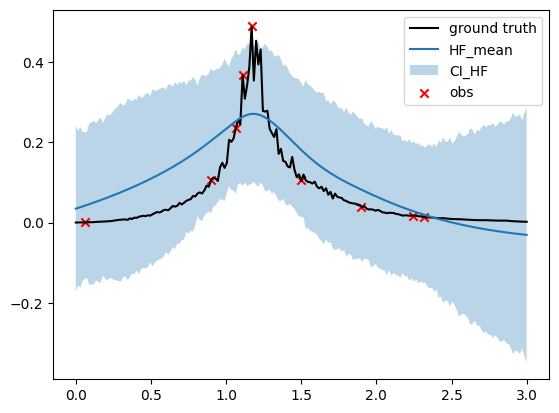

[60 71 74 78 81]


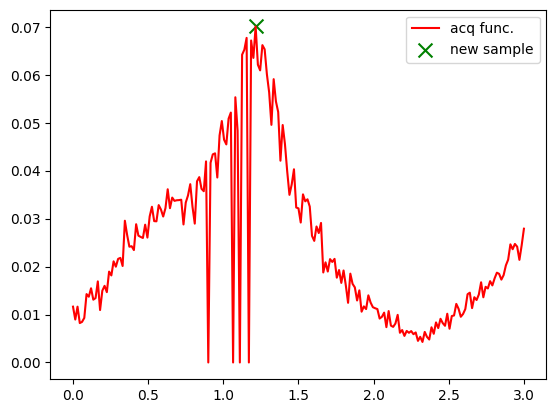

1.2149999999999999 1.2149999999999999
Evaluation 10 of 20

---Performing Equlibration---



100%|██████████| 500/500 [00:06<00:00, 74.01it/s]



---Finished...
----Performing MC Moves----



100%|██████████| 500/500 [00:18<00:00, 27.64it/s]


Completed. Saving
Time (s) to complete simulation 6: 24.856995582580566


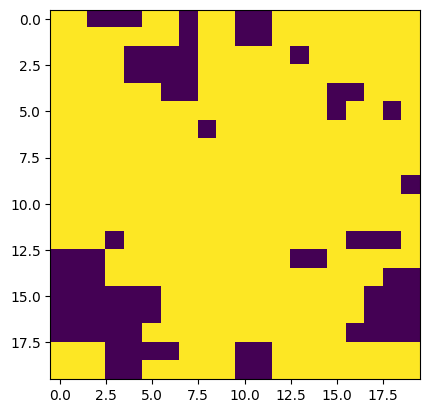

Step:6


/usr/local/lib/python3.10/dist-packages/gpax/models/gp.py:111: FutureWarning: `noise_prior` is deprecated and will be removed in a future version. Please use `noise_prior_dist` instead, which accepts an instance of a numpyro.distributions Distribution object, e.g., `dist.HalfNormal(scale=0.1)`, rather than a function that calls `numpyro.sample`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/gpax/models/gp.py:119: UserWarning: `kernel_prior` will remain available for complex priors. However, for modifying only the lengthscales, it is recommended to use `lengthscale_prior_dist` instead. `lengthscale_prior_dist` accepts an instance of a numpyro.distributions Distribution object, e.g., `dist.Gamma(2, 5)`, rather than a function that calls `numpyro.sample`.
  warnings.warn(
sample: 100%|██████████| 1000/1000 [00:11<00:00, 88.80it/s, 7 steps of size 4.78e-01. acc. prob=0.85] 



                mean       std    median      5.0%     95.0%     n_eff     r_hat
  k_length      0.39      0.27      0.32      0.04      0.82    205.83      1.00
   k_scale      0.22      0.20      0.15      0.01      0.55    222.67      1.01
     noise      0.02      0.01      0.02      0.00      0.03    225.64      1.00



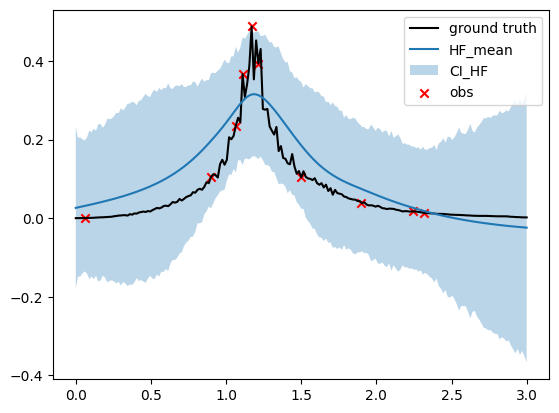

[60 71 74 78 81 79]


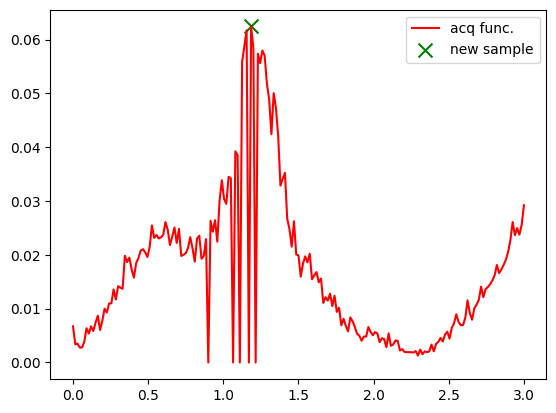

1.185 1.185
Evaluation 11 of 20

---Performing Equlibration---



100%|██████████| 500/500 [00:06<00:00, 72.42it/s]



---Finished...
----Performing MC Moves----



100%|██████████| 500/500 [00:18<00:00, 27.59it/s]


Completed. Saving
Time (s) to complete simulation 7: 25.03281021118164


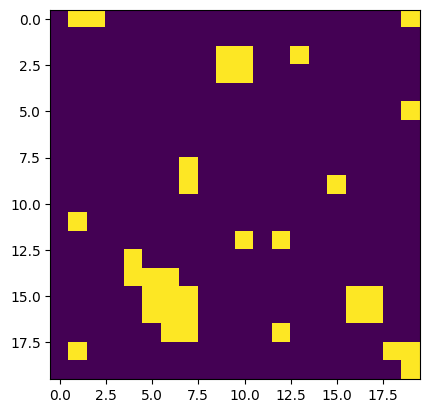

Step:7


/usr/local/lib/python3.10/dist-packages/gpax/models/gp.py:111: FutureWarning: `noise_prior` is deprecated and will be removed in a future version. Please use `noise_prior_dist` instead, which accepts an instance of a numpyro.distributions Distribution object, e.g., `dist.HalfNormal(scale=0.1)`, rather than a function that calls `numpyro.sample`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/gpax/models/gp.py:119: UserWarning: `kernel_prior` will remain available for complex priors. However, for modifying only the lengthscales, it is recommended to use `lengthscale_prior_dist` instead. `lengthscale_prior_dist` accepts an instance of a numpyro.distributions Distribution object, e.g., `dist.Gamma(2, 5)`, rather than a function that calls `numpyro.sample`.
  warnings.warn(
sample: 100%|██████████| 1000/1000 [00:14<00:00, 66.77it/s, 15 steps of size 3.53e-01. acc. prob=0.89]



                mean       std    median      5.0%     95.0%     n_eff     r_hat
  k_length      0.37      0.26      0.29      0.05      0.80    146.48      1.00
   k_scale      0.23      0.23      0.14      0.01      0.61    262.77      1.00
     noise      0.02      0.01      0.01      0.00      0.03    244.78      1.00



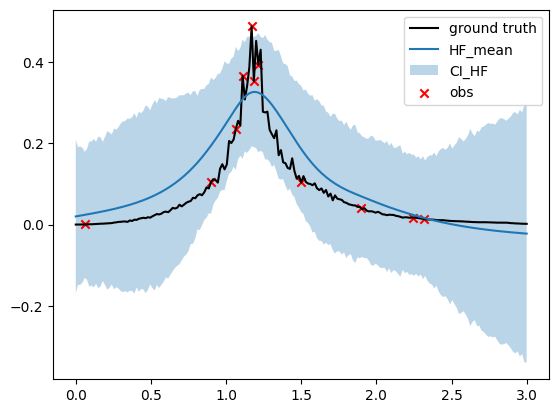

[60 71 74 78 81 79 84]


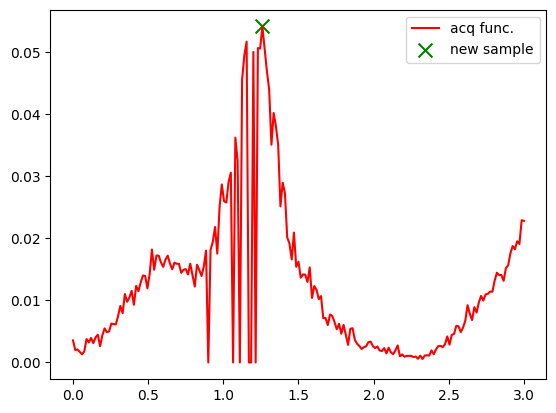

1.26 1.26
Evaluation 12 of 20

---Performing Equlibration---



100%|██████████| 500/500 [00:06<00:00, 73.57it/s]



---Finished...
----Performing MC Moves----



100%|██████████| 500/500 [00:17<00:00, 28.72it/s]


Completed. Saving
Time (s) to complete simulation 8: 24.217061758041382


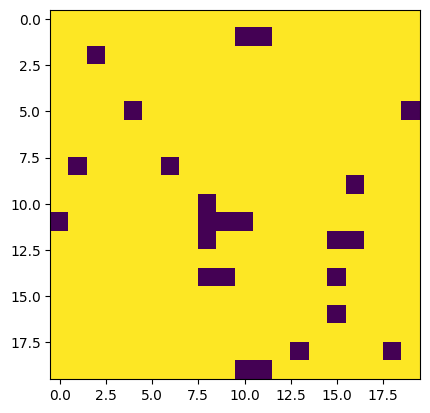

Step:8


/usr/local/lib/python3.10/dist-packages/gpax/models/gp.py:111: FutureWarning: `noise_prior` is deprecated and will be removed in a future version. Please use `noise_prior_dist` instead, which accepts an instance of a numpyro.distributions Distribution object, e.g., `dist.HalfNormal(scale=0.1)`, rather than a function that calls `numpyro.sample`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/gpax/models/gp.py:119: UserWarning: `kernel_prior` will remain available for complex priors. However, for modifying only the lengthscales, it is recommended to use `lengthscale_prior_dist` instead. `lengthscale_prior_dist` accepts an instance of a numpyro.distributions Distribution object, e.g., `dist.Gamma(2, 5)`, rather than a function that calls `numpyro.sample`.
  warnings.warn(
sample: 100%|██████████| 1000/1000 [00:13<00:00, 73.77it/s, 15 steps of size 3.68e-01. acc. prob=0.91]



                mean       std    median      5.0%     95.0%     n_eff     r_hat
  k_length      0.33      0.24      0.26      0.02      0.73    182.56      1.00
   k_scale      0.22      0.21      0.13      0.01      0.57    244.65      1.00
     noise      0.01      0.01      0.01      0.00      0.03    275.62      1.00



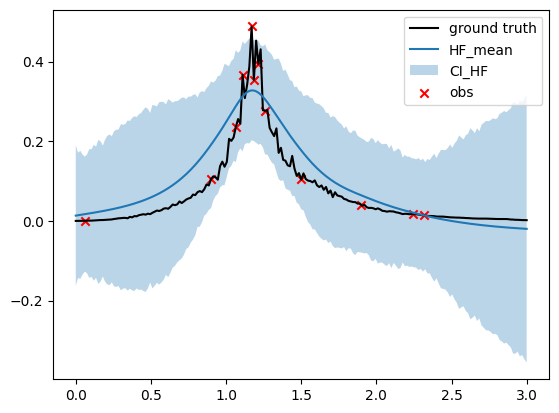

[60 71 74 78 81 79 84 77]


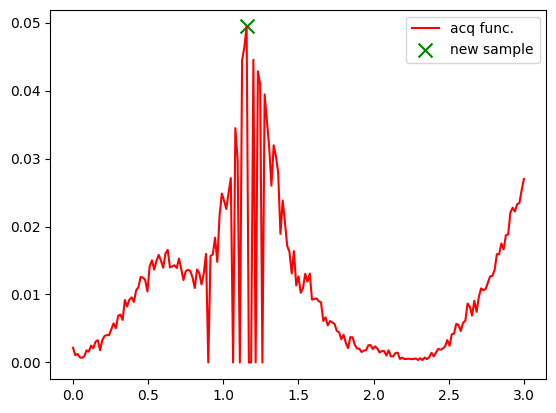

1.155 1.155
Evaluation 13 of 20

---Performing Equlibration---



100%|██████████| 500/500 [00:06<00:00, 72.25it/s]



---Finished...
----Performing MC Moves----



100%|██████████| 500/500 [00:17<00:00, 28.60it/s]


Completed. Saving
Time (s) to complete simulation 9: 24.415642261505127


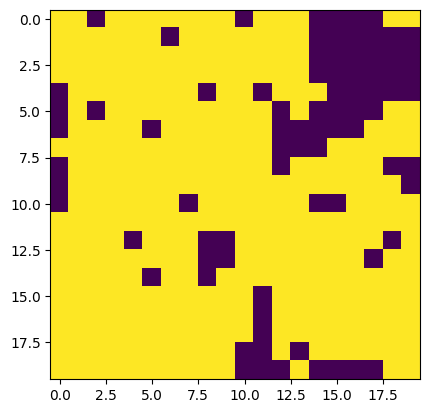

Step:9


/usr/local/lib/python3.10/dist-packages/gpax/models/gp.py:111: FutureWarning: `noise_prior` is deprecated and will be removed in a future version. Please use `noise_prior_dist` instead, which accepts an instance of a numpyro.distributions Distribution object, e.g., `dist.HalfNormal(scale=0.1)`, rather than a function that calls `numpyro.sample`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/gpax/models/gp.py:119: UserWarning: `kernel_prior` will remain available for complex priors. However, for modifying only the lengthscales, it is recommended to use `lengthscale_prior_dist` instead. `lengthscale_prior_dist` accepts an instance of a numpyro.distributions Distribution object, e.g., `dist.Gamma(2, 5)`, rather than a function that calls `numpyro.sample`.
  warnings.warn(
sample: 100%|██████████| 1000/1000 [00:15<00:00, 66.15it/s, 15 steps of size 3.56e-01. acc. prob=0.87]



                mean       std    median      5.0%     95.0%     n_eff     r_hat
  k_length      0.25      0.21      0.18      0.03      0.57    205.31      1.00
   k_scale      0.19      0.21      0.10      0.01      0.54    204.48      1.02
     noise      0.01      0.01      0.01      0.00      0.02    251.12      1.00



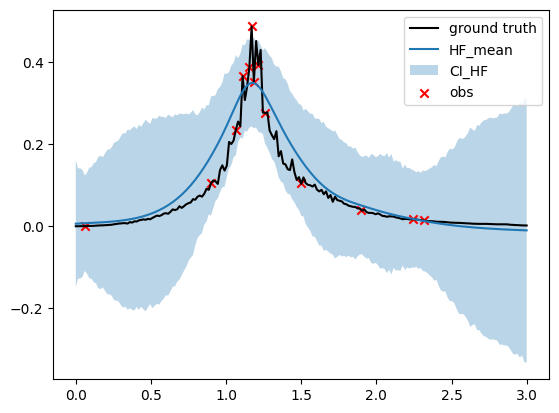

[60 71 74 78 81 79 84 77 76]


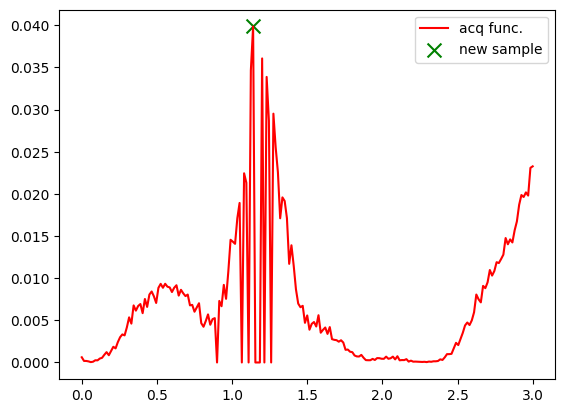

1.14 1.14
Evaluation 14 of 20

---Performing Equlibration---



100%|██████████| 500/500 [00:06<00:00, 73.96it/s]



---Finished...
----Performing MC Moves----



100%|██████████| 500/500 [00:17<00:00, 28.66it/s]


Completed. Saving
Time (s) to complete simulation 10: 24.216792106628418


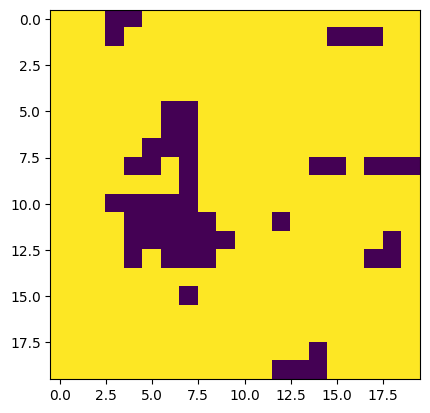

Step:10


/usr/local/lib/python3.10/dist-packages/gpax/models/gp.py:111: FutureWarning: `noise_prior` is deprecated and will be removed in a future version. Please use `noise_prior_dist` instead, which accepts an instance of a numpyro.distributions Distribution object, e.g., `dist.HalfNormal(scale=0.1)`, rather than a function that calls `numpyro.sample`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/gpax/models/gp.py:119: UserWarning: `kernel_prior` will remain available for complex priors. However, for modifying only the lengthscales, it is recommended to use `lengthscale_prior_dist` instead. `lengthscale_prior_dist` accepts an instance of a numpyro.distributions Distribution object, e.g., `dist.Gamma(2, 5)`, rather than a function that calls `numpyro.sample`.
  warnings.warn(
sample: 100%|██████████| 1000/1000 [00:16<00:00, 61.83it/s, 7 steps of size 2.82e-01. acc. prob=0.92]



                mean       std    median      5.0%     95.0%     n_eff     r_hat
  k_length      0.24      0.20      0.17      0.03      0.50    124.34      1.00
   k_scale      0.18      0.20      0.09      0.01      0.45    181.51      1.01
     noise      0.01      0.01      0.01      0.00      0.02    161.00      1.00



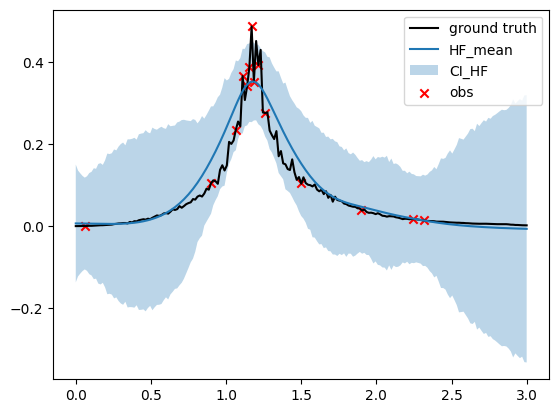

[60 71 74 78 81 79 84 77 76 80]


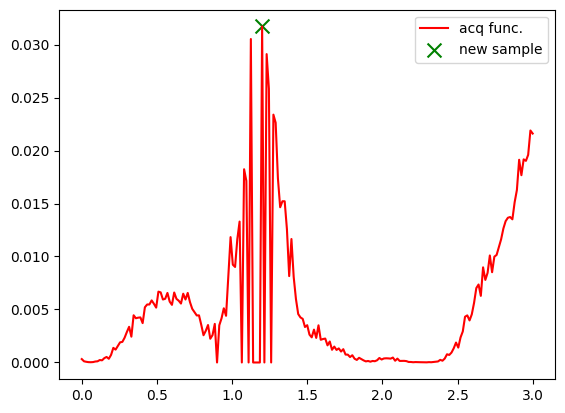

1.2 1.2
Evaluation 15 of 20

---Performing Equlibration---



100%|██████████| 500/500 [00:06<00:00, 74.18it/s]



---Finished...
----Performing MC Moves----



100%|██████████| 500/500 [00:16<00:00, 29.50it/s]


Completed. Saving
Time (s) to complete simulation 11: 23.70116949081421


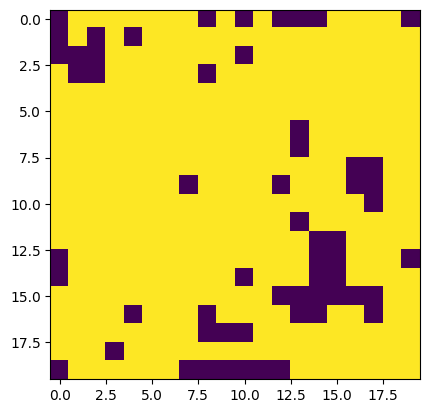

Step:11


/usr/local/lib/python3.10/dist-packages/gpax/models/gp.py:111: FutureWarning: `noise_prior` is deprecated and will be removed in a future version. Please use `noise_prior_dist` instead, which accepts an instance of a numpyro.distributions Distribution object, e.g., `dist.HalfNormal(scale=0.1)`, rather than a function that calls `numpyro.sample`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/gpax/models/gp.py:119: UserWarning: `kernel_prior` will remain available for complex priors. However, for modifying only the lengthscales, it is recommended to use `lengthscale_prior_dist` instead. `lengthscale_prior_dist` accepts an instance of a numpyro.distributions Distribution object, e.g., `dist.Gamma(2, 5)`, rather than a function that calls `numpyro.sample`.
  warnings.warn(
sample: 100%|██████████| 1000/1000 [00:15<00:00, 64.55it/s, 15 steps of size 4.18e-01. acc. prob=0.90]



                mean       std    median      5.0%     95.0%     n_eff     r_hat
  k_length      0.18      0.15      0.14      0.04      0.39    169.06      1.00
   k_scale      0.16      0.18      0.08      0.01      0.41    171.05      1.01
     noise      0.01      0.01      0.01      0.00      0.01    238.39      1.00



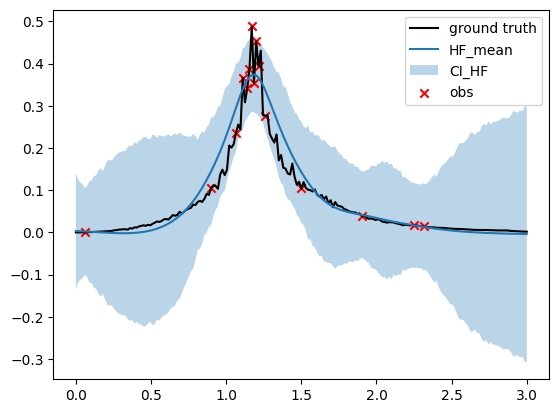

[60 71 74 78 81 79 84 77 76 80 82]


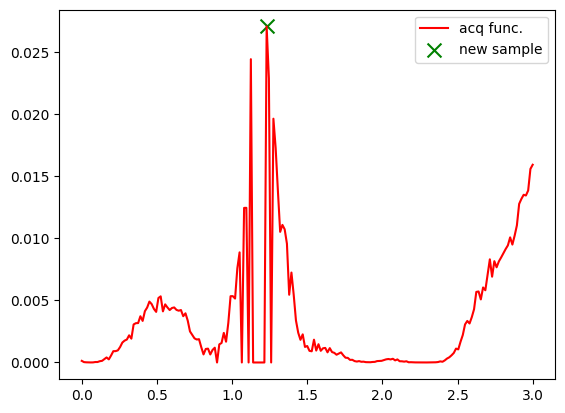

1.23 1.23
Evaluation 16 of 20

---Performing Equlibration---



100%|██████████| 500/500 [00:06<00:00, 73.19it/s]



---Finished...
----Performing MC Moves----



100%|██████████| 500/500 [00:17<00:00, 29.09it/s]


Completed. Saving
Time (s) to complete simulation 12: 24.027241706848145


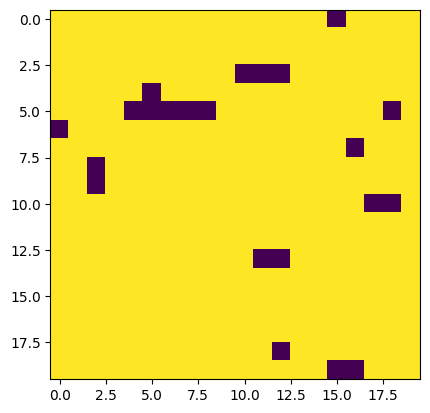

Step:12


/usr/local/lib/python3.10/dist-packages/gpax/models/gp.py:111: FutureWarning: `noise_prior` is deprecated and will be removed in a future version. Please use `noise_prior_dist` instead, which accepts an instance of a numpyro.distributions Distribution object, e.g., `dist.HalfNormal(scale=0.1)`, rather than a function that calls `numpyro.sample`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/gpax/models/gp.py:119: UserWarning: `kernel_prior` will remain available for complex priors. However, for modifying only the lengthscales, it is recommended to use `lengthscale_prior_dist` instead. `lengthscale_prior_dist` accepts an instance of a numpyro.distributions Distribution object, e.g., `dist.Gamma(2, 5)`, rather than a function that calls `numpyro.sample`.
  warnings.warn(
sample: 100%|██████████| 1000/1000 [00:08<00:00, 113.19it/s, 7 steps of size 4.30e-01. acc. prob=0.90]



                mean       std    median      5.0%     95.0%     n_eff     r_hat
  k_length      0.17      0.12      0.13      0.03      0.31    195.50      1.00
   k_scale      0.16      0.19      0.08      0.01      0.42    215.41      1.00
     noise      0.01      0.00      0.00      0.00      0.01    275.87      1.00



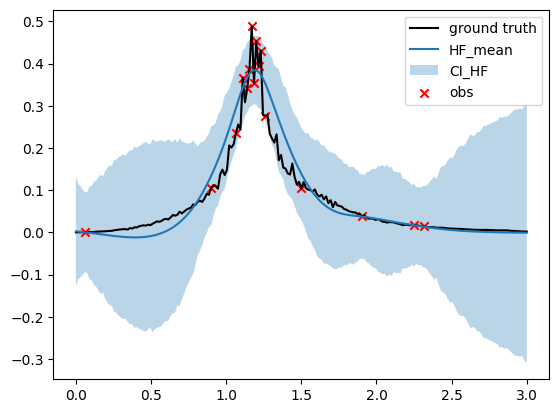

[60 71 74 78 81 79 84 77 76 80 82 83]


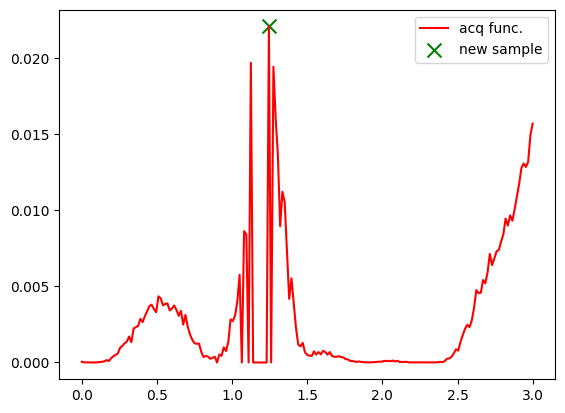

1.2449999999999999 1.2449999999999999
Evaluation 17 of 20

---Performing Equlibration---



100%|██████████| 500/500 [00:06<00:00, 72.50it/s]



---Finished...
----Performing MC Moves----



100%|██████████| 500/500 [00:17<00:00, 29.02it/s]


Completed. Saving
Time (s) to complete simulation 13: 24.13746213912964


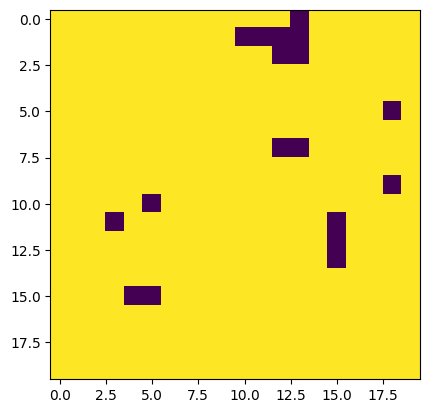

Step:13


/usr/local/lib/python3.10/dist-packages/gpax/models/gp.py:111: FutureWarning: `noise_prior` is deprecated and will be removed in a future version. Please use `noise_prior_dist` instead, which accepts an instance of a numpyro.distributions Distribution object, e.g., `dist.HalfNormal(scale=0.1)`, rather than a function that calls `numpyro.sample`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/gpax/models/gp.py:119: UserWarning: `kernel_prior` will remain available for complex priors. However, for modifying only the lengthscales, it is recommended to use `lengthscale_prior_dist` instead. `lengthscale_prior_dist` accepts an instance of a numpyro.distributions Distribution object, e.g., `dist.Gamma(2, 5)`, rather than a function that calls `numpyro.sample`.
  warnings.warn(
sample: 100%|██████████| 1000/1000 [00:18<00:00, 55.28it/s, 13 steps of size 3.08e-01. acc. prob=0.91]



                mean       std    median      5.0%     95.0%     n_eff     r_hat
  k_length      0.18      0.17      0.12      0.03      0.37    107.78      1.00
   k_scale      0.15      0.18      0.07      0.01      0.36    189.10      1.00
     noise      0.01      0.00      0.01      0.00      0.01    143.95      1.01



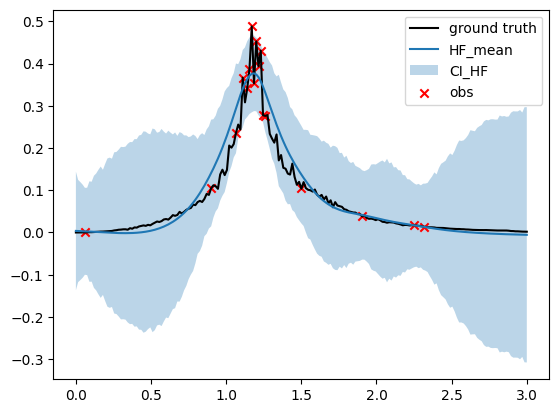

[60 71 74 78 81 79 84 77 76 80 82 83 75]


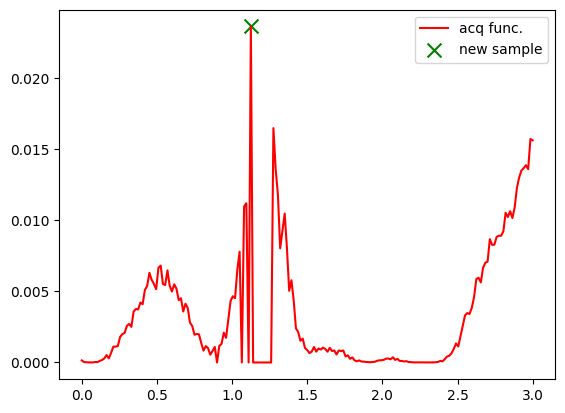

1.125 1.125
Evaluation 18 of 20

---Performing Equlibration---



100%|██████████| 500/500 [00:06<00:00, 72.95it/s]



---Finished...
----Performing MC Moves----



100%|██████████| 500/500 [00:17<00:00, 29.15it/s]


Completed. Saving
Time (s) to complete simulation 14: 24.018455505371094


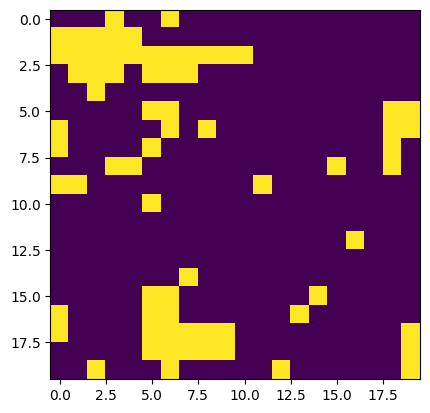

Step:14


/usr/local/lib/python3.10/dist-packages/gpax/models/gp.py:111: FutureWarning: `noise_prior` is deprecated and will be removed in a future version. Please use `noise_prior_dist` instead, which accepts an instance of a numpyro.distributions Distribution object, e.g., `dist.HalfNormal(scale=0.1)`, rather than a function that calls `numpyro.sample`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/gpax/models/gp.py:119: UserWarning: `kernel_prior` will remain available for complex priors. However, for modifying only the lengthscales, it is recommended to use `lengthscale_prior_dist` instead. `lengthscale_prior_dist` accepts an instance of a numpyro.distributions Distribution object, e.g., `dist.Gamma(2, 5)`, rather than a function that calls `numpyro.sample`.
  warnings.warn(
sample: 100%|██████████| 1000/1000 [00:18<00:00, 53.64it/s, 13 steps of size 3.79e-01. acc. prob=0.92]



                mean       std    median      5.0%     95.0%     n_eff     r_hat
  k_length      0.16      0.11      0.12      0.03      0.33    239.27      1.00
   k_scale      0.14      0.17      0.08      0.01      0.38    214.13      1.00
     noise      0.01      0.00      0.00      0.00      0.01    227.02      1.00



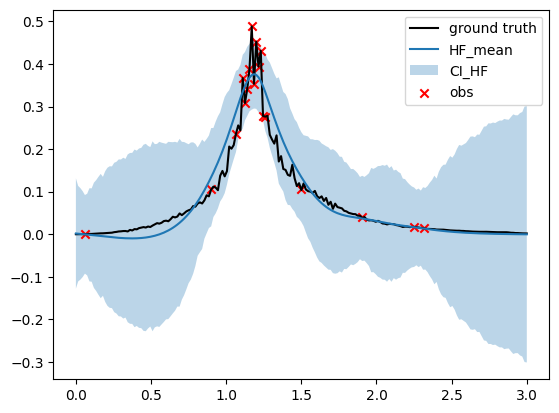

[ 60  71  74  78  81  79  84  77  76  80  82  83  75 200]


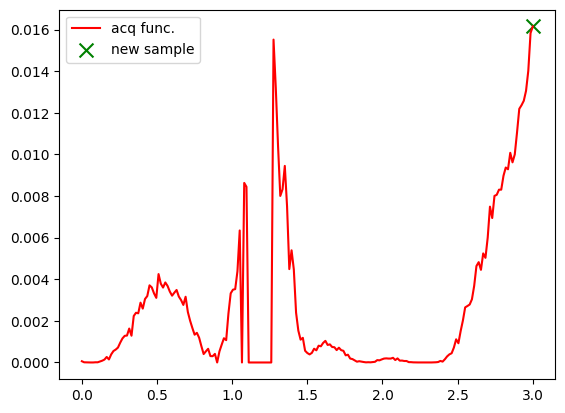

3.0 3.0
Evaluation 19 of 20

---Performing Equlibration---



100%|██████████| 500/500 [00:06<00:00, 78.67it/s]



---Finished...
----Performing MC Moves----



100%|██████████| 500/500 [00:16<00:00, 29.53it/s]


Completed. Saving
Time (s) to complete simulation 15: 23.2995343208313


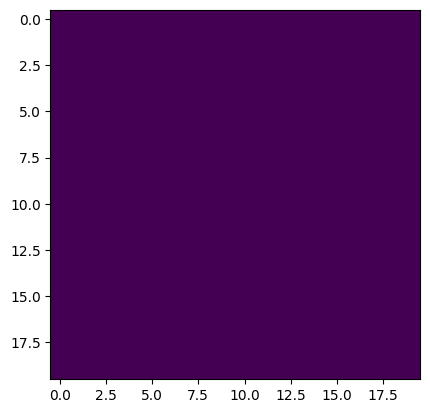

Step:15


/usr/local/lib/python3.10/dist-packages/gpax/models/gp.py:111: FutureWarning: `noise_prior` is deprecated and will be removed in a future version. Please use `noise_prior_dist` instead, which accepts an instance of a numpyro.distributions Distribution object, e.g., `dist.HalfNormal(scale=0.1)`, rather than a function that calls `numpyro.sample`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/gpax/models/gp.py:119: UserWarning: `kernel_prior` will remain available for complex priors. However, for modifying only the lengthscales, it is recommended to use `lengthscale_prior_dist` instead. `lengthscale_prior_dist` accepts an instance of a numpyro.distributions Distribution object, e.g., `dist.Gamma(2, 5)`, rather than a function that calls `numpyro.sample`.
  warnings.warn(
sample: 100%|██████████| 1000/1000 [00:20<00:00, 49.38it/s, 15 steps of size 3.69e-01. acc. prob=0.91]



                mean       std    median      5.0%     95.0%     n_eff     r_hat
  k_length      0.14      0.10      0.10      0.02      0.27    213.01      1.00
   k_scale      0.08      0.11      0.05      0.01      0.19    173.43      1.00
     noise      0.01      0.00      0.00      0.00      0.01    271.82      1.00



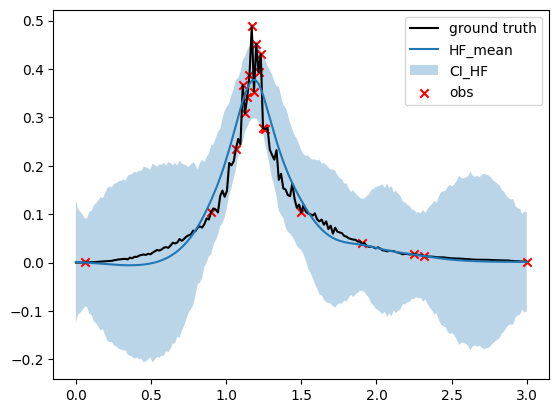

[ 60  71  74  78  81  79  84  77  76  80  82  83  75 200  85]


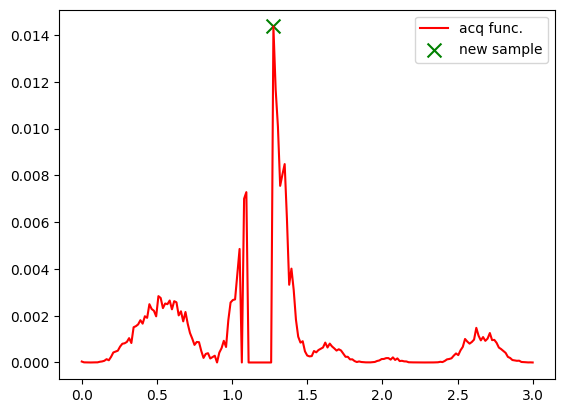

1.275 1.275
Evaluation 20 of 20

---Performing Equlibration---



100%|██████████| 500/500 [00:06<00:00, 74.05it/s]



---Finished...
----Performing MC Moves----



100%|██████████| 500/500 [00:17<00:00, 28.81it/s]


Completed. Saving
Time (s) to complete simulation 16: 24.114989042282104


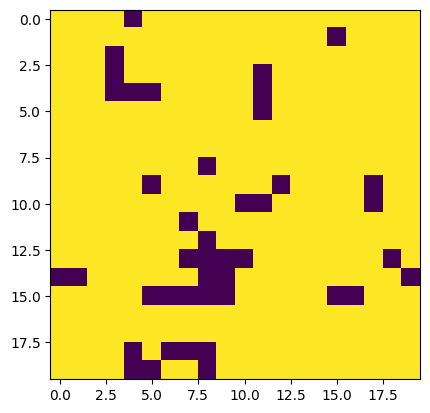

In [ ]:
N = 15
X_test =xs
X_test_full = xs
X_test_norm = (X_test-bounds[0])/(bounds[1]-bounds[0])

# Get random number generator keys for training and prediction
rng_key, rng_key_predict = gpax.utils.get_keys()
idx = []
for i in range(1, N+1):
    print("Step:"+str(i))


    # Initialize model
    gp_model = gpax.ExactGP(1, kernel='Matern', kernel_prior = kernel_prior,
                        noise_prior = lambda: numpyro.sample("noise", numpyro.distributions.HalfNormal(0.03)))
    # Run Hamiltonian Monte Carlo to obtain posterior samples for kernel parameters and model noise
    gp_model.fit(rng_key, train_x_full_norm, train_y, num_warmup=500, num_samples=500, num_chains=1)



    y_pred, y_sampled = gp_model.predict(rng_key_predict, X_test_norm)
    plt.plot(xs, true_ys_sq, "k", label="ground truth")
    pred_lower = y_pred - y_sampled.std(axis=(0,1))
    pred_upper = y_pred + y_sampled.std(axis=(0,1))
    plt.plot(xs, y_pred, label="HF_mean")
    plt.fill_between(
        xs.flatten(),
        pred_lower,
        pred_upper,
        alpha=0.3,
        label="CI_HF",
    )
    plt.scatter(train_x_full, train_y, c="r", marker="x", label="obs")

    plt.legend(loc="best")
    plt.show()
    # Compute the EI acq function
    acq = gpax.acquisition.EI(rng_key_predict, gp_model, X_test_norm, maximize=True, noiseless=False)
    acq = np.array(acq)
    acq[idx] = 0
    next_point_val = acq.max()
    next_point_idx = acq.argmax()
    idx = np.hstack((idx, next_point_idx))

    if len(idx) == 1:
        idx = int(idx)
        print(idx)
    else:
        idx = idx
        print(idx)


    if next_point_val == 0:
        print("Model sufficiently learned")
        break
    else:
        next_point = X_test[next_point_idx]
        next_point_norm = X_test_norm[next_point_idx]
        train_x_full = np.vstack((train_x_full, next_point))
        train_x_full_norm = np.vstack((train_x_full_norm, next_point_norm))

        #Plot acquistion function
        plt.plot(xs, acq, "r", label="acq func.")
        plt.scatter(next_point, next_point_val, c="g", marker="x", label="new sample", s= 100)
        plt.legend(loc="best")
        plt.show()

        Jx=train_x_full[:,0]
        print(next_point, Jx[-1])
        J_mat = np.array([[0,0,0,0,0],
                  [0,0,Jx[-1],0,0],
                  [0,Jx[-1],0,Jx[-1],0],
                  [0,0,Jx[-1],0,0],
                  [0,0,0,0,0]])
        print("Evaluation " +str (n+i) +" of " +str(n+N))
        start_time = time.time()
        np.random.seed(0)
        sq_sim = IsingSim(N = 20, J_mat = J_mat, T = 2.7, save_trajectories=True, eqSteps = 500, mcSteps = 500)  # Intializing the object
        sq_sim.performIsingSim()   # Running the sim
        end_time = time.time()
        #time_eval[i]= end_time-start_time
        print("Time (s) to complete simulation " +str(i+1)+ ": " +str(end_time-start_time))
        resultsBO_dict[n+i] = {'sim': sq_sim.results,}
        new_y = resultsBO_dict[n+i]['sim']['SpecificHeat']
        plt.imshow(resultsBO_dict[n+i]['sim']['config'][-1])
        plt.show()
        train_y = np.vstack((train_y, new_y))





#Final GP prediction

/usr/local/lib/python3.10/dist-packages/gpax/models/gp.py:111: FutureWarning: `noise_prior` is deprecated and will be removed in a future version. Please use `noise_prior_dist` instead, which accepts an instance of a numpyro.distributions Distribution object, e.g., `dist.HalfNormal(scale=0.1)`, rather than a function that calls `numpyro.sample`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/gpax/models/gp.py:119: UserWarning: `kernel_prior` will remain available for complex priors. However, for modifying only the lengthscales, it is recommended to use `lengthscale_prior_dist` instead. `lengthscale_prior_dist` accepts an instance of a numpyro.distributions Distribution object, e.g., `dist.Gamma(2, 5)`, rather than a function that calls `numpyro.sample`.
  warnings.warn(
sample: 100%|██████████| 1000/1000 [00:21<00:00, 45.97it/s, 7 steps of size 3.00e-01. acc. prob=0.94]



                mean       std    median      5.0%     95.0%     n_eff     r_hat
  k_length      0.14      0.11      0.10      0.03      0.29    145.40      1.00
   k_scale      0.09      0.12      0.05      0.01      0.23    171.42      1.00
     noise      0.01      0.00      0.00      0.00      0.01    203.02      1.00



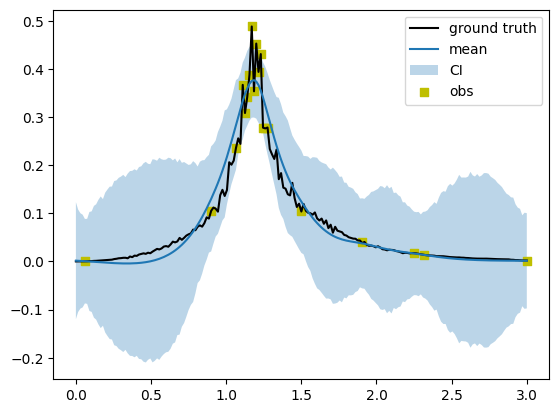

In [ ]:
# Initialize model
gp_model = gpax.ExactGP(1, kernel='Matern', kernel_prior = kernel_prior,
                    noise_prior = lambda: numpyro.sample("noise", numpyro.distributions.HalfNormal(0.03)))
# Run Hamiltonian Monte Carlo to obtain posterior samples for kernel parameters and model noise
gp_model.fit(rng_key, train_x_full_norm, train_y, num_warmup=500, num_samples=500, num_chains=1)


y_pred, y_sampled = gp_model.predict(rng_key_predict, X_test_norm)
plt.plot(xs, true_ys_sq, "k", label="ground truth")
pred_lower = y_pred - y_sampled.std(axis=(0,1))
pred_upper = y_pred + y_sampled.std(axis=(0,1))
plt.plot(xs, y_pred, label="mean")
plt.fill_between(
    xs.flatten(),
    pred_lower,
    pred_upper,
    alpha=0.3,
    label="CI",
)
plt.scatter(train_x_full, train_y, c="y", marker="s", label="obs")

plt.legend(loc="best")
plt.show()

0.000522904451080694


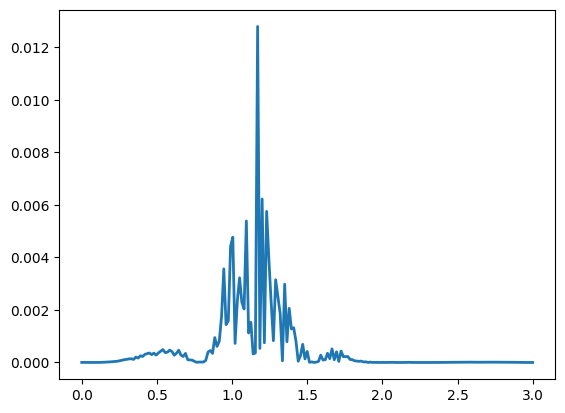

In [ ]:
# Calculate MSE between HF ground truth and prediction values
error2_BO = (true_ys_sq-y_pred)**2
MSE_BO = np.mean(error2_BO)
print(MSE_BO)

plt.plot(xs, error2_BO, linewidth =2)


# BO with structured GP



- Start with same initial samples

In [ ]:
train_x_full = train_x_full[0:n]
train_x_full_norm = train_x_full_norm[0:n]
train_y = train_y[0:n]
train_x_full, train_x_full_norm, train_y

(array([[2.31396193],
        [0.06225585],
        [1.9009447 ],
        [2.24641165],
        [1.49552104]]),
 array([[0.77132064],
        [0.02075195],
        [0.63364823],
        [0.74880388],
        [0.49850701]]),
 array([[0.01413402],
        [0.00039374],
        [0.03967774],
        [0.01734454],
        [0.10521883]]))

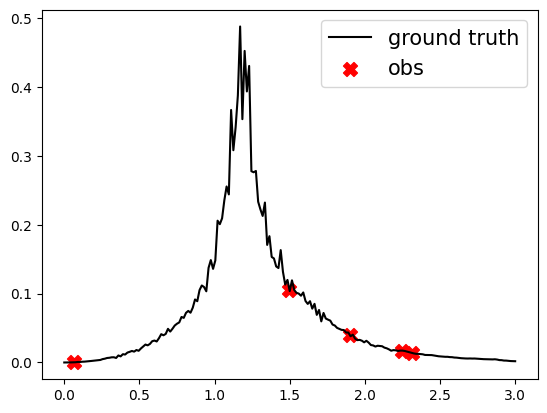

In [ ]:
plt.plot(xs, true_ys_sq, "k", label="ground truth")

plt.scatter(train_x, train_y, c="r", marker="X", label="obs", s=100)

plt.legend(fontsize=15);

# GP mean function
- Prioir information functional form - Single peak function (eg. Gaussian)

In [ ]:
@jit
def mean_func(x, params):

    x_data = x[:,0]
    #jax.debug.print("x_norm: {}", x_data)
    lb = 0
    ub = 3
    x_data = x_data*(ub-lb) + lb
    #jax.debug.print("x: {}", x_data)
    f = params["a"]*jnp.exp((-1/2)*(jnp.square(x_data-params["b"])/jnp.square(params["c"])))

    return  f


def mf_priors():
    a = numpyro.sample("a", numpyro.distributions.HalfNormal(0.5)) #Height of peak
    b = numpyro.sample("b", numpyro.distributions.HalfNormal(1.17)) #Position of peak
    c = numpyro.sample("c", numpyro.distributions.HalfNormal(2)) #Broadness of peak
    return {"a": a, "b": b, "c": c}

In [ ]:
#train_x_full = train_x_full[0:n]
#train_x_full_norm = train_x_full_norm[0:n]
#train_y = train_y[0:n]
#train_x_full, train_x_full_norm, train_y

(array([[2.31396193, 0.95      ],
        [0.06225585, 1.        ],
        [1.9009447 , 0.95      ],
        [2.24641165, 0.95      ],
        [1.49552104, 1.        ],
        [0.67438994, 1.        ],
        [0.59418859, 0.95      ],
        [2.28159214, 0.95      ],
        [0.50733251, 1.        ],
        [0.26501944, 0.95      ]]),
 array([[0.77132064, 0.95      ],
        [0.02075195, 1.        ],
        [0.63364823, 0.95      ],
        [0.74880388, 0.95      ],
        [0.49850701, 1.        ],
        [0.22479665, 1.        ],
        [0.19806286, 0.95      ],
        [0.76053071, 0.95      ],
        [0.16911084, 1.        ],
        [0.08833981, 0.95      ]]),
 array([[0.01413402],
        [0.00025922],
        [0.03967774],
        [0.01734454],
        [0.10503485],
        [0.04375014],
        [0.0321721 ],
        [0.01583695],
        [0.02304033],
        [0.00402616]]))

# Run sBO

Step:1


/usr/local/lib/python3.10/dist-packages/gpax/models/gp.py:111: FutureWarning: `noise_prior` is deprecated and will be removed in a future version. Please use `noise_prior_dist` instead, which accepts an instance of a numpyro.distributions Distribution object, e.g., `dist.HalfNormal(scale=0.1)`, rather than a function that calls `numpyro.sample`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/gpax/models/gp.py:119: UserWarning: `kernel_prior` will remain available for complex priors. However, for modifying only the lengthscales, it is recommended to use `lengthscale_prior_dist` instead. `lengthscale_prior_dist` accepts an instance of a numpyro.distributions Distribution object, e.g., `dist.Gamma(2, 5)`, rather than a function that calls `numpyro.sample`.
  warnings.warn(
sample: 100%|██████████| 1000/1000 [00:15<00:00, 66.01it/s, 7 steps of size 2.78e-01. acc. prob=0.84] 



                mean       std    median      5.0%     95.0%     n_eff     r_hat
         a      0.27      0.22      0.21      0.00      0.56    114.25      1.02
         b      0.92      0.60      0.84      0.00      1.76    315.75      1.00
         c      1.43      1.12      1.14      0.03      2.96    187.93      1.01
  k_length      0.65      0.26      0.70      0.31      1.00    370.49      1.00
   k_scale      0.19      0.23      0.09      0.01      0.56    327.32      1.00
     noise      0.01      0.01      0.00      0.00      0.02    354.30      1.01



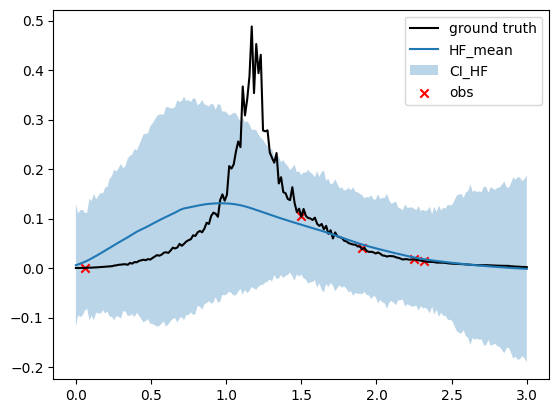

52


<ipython-input-76-4ac7329d7931>:46: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  idx = int(idx)


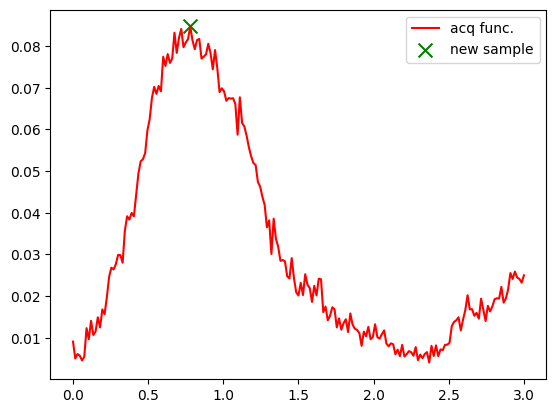

0.78 0.78
Evaluation 6 of 20

---Performing Equlibration---



100%|██████████| 500/500 [00:06<00:00, 72.15it/s]



---Finished...
----Performing MC Moves----



100%|██████████| 500/500 [00:17<00:00, 28.74it/s]


Completed. Saving
Time (s) to complete simulation 2: 24.34099006652832


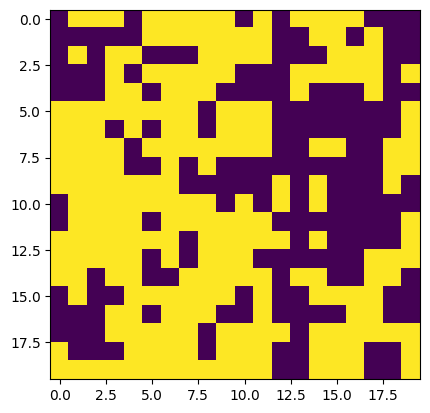

Step:2


/usr/local/lib/python3.10/dist-packages/gpax/models/gp.py:111: FutureWarning: `noise_prior` is deprecated and will be removed in a future version. Please use `noise_prior_dist` instead, which accepts an instance of a numpyro.distributions Distribution object, e.g., `dist.HalfNormal(scale=0.1)`, rather than a function that calls `numpyro.sample`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/gpax/models/gp.py:119: UserWarning: `kernel_prior` will remain available for complex priors. However, for modifying only the lengthscales, it is recommended to use `lengthscale_prior_dist` instead. `lengthscale_prior_dist` accepts an instance of a numpyro.distributions Distribution object, e.g., `dist.Gamma(2, 5)`, rather than a function that calls `numpyro.sample`.
  warnings.warn(
sample: 100%|██████████| 1000/1000 [00:13<00:00, 71.64it/s, 15 steps of size 3.35e-01. acc. prob=0.86] 



                mean       std    median      5.0%     95.0%     n_eff     r_hat
         a      0.21      0.18      0.17      0.00      0.45    256.87      1.00
         b      0.87      0.66      0.76      0.00      1.81    239.23      1.01
         c      1.77      1.10      1.54      0.16      3.36    315.49      1.01
  k_length      0.71      0.21      0.74      0.42      1.00    355.06      1.00
   k_scale      0.18      0.21      0.09      0.01      0.50    199.25      1.00
     noise      0.00      0.01      0.00      0.00      0.01    404.42      1.00



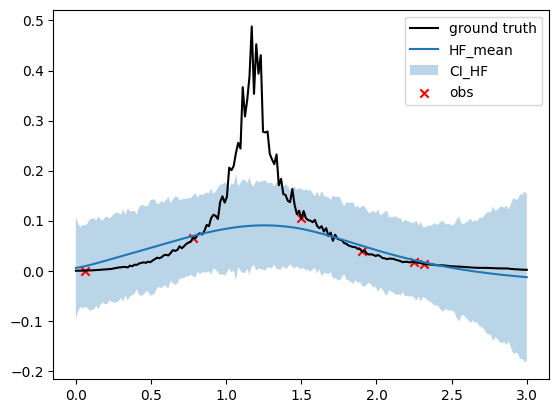

[52 71]


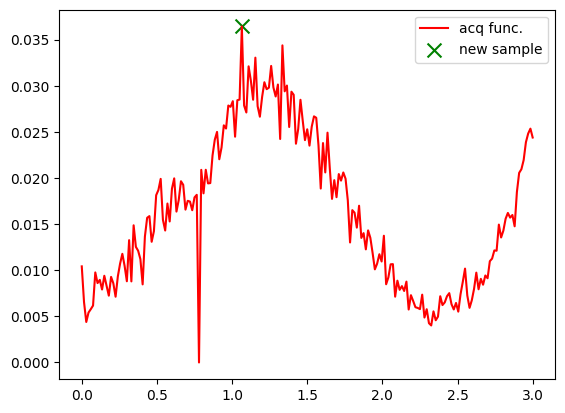

1.065 1.065
Evaluation 7 of 20

---Performing Equlibration---



100%|██████████| 500/500 [00:06<00:00, 72.48it/s]



---Finished...
----Performing MC Moves----



100%|██████████| 500/500 [00:17<00:00, 28.58it/s]


Completed. Saving
Time (s) to complete simulation 3: 24.40333843231201


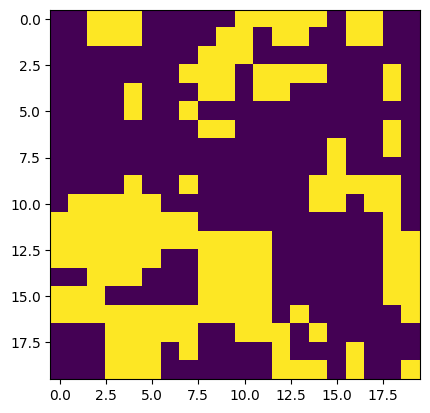

Step:3


/usr/local/lib/python3.10/dist-packages/gpax/models/gp.py:111: FutureWarning: `noise_prior` is deprecated and will be removed in a future version. Please use `noise_prior_dist` instead, which accepts an instance of a numpyro.distributions Distribution object, e.g., `dist.HalfNormal(scale=0.1)`, rather than a function that calls `numpyro.sample`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/gpax/models/gp.py:119: UserWarning: `kernel_prior` will remain available for complex priors. However, for modifying only the lengthscales, it is recommended to use `lengthscale_prior_dist` instead. `lengthscale_prior_dist` accepts an instance of a numpyro.distributions Distribution object, e.g., `dist.Gamma(2, 5)`, rather than a function that calls `numpyro.sample`.
  warnings.warn(
sample: 100%|██████████| 1000/1000 [00:13<00:00, 71.86it/s, 7 steps of size 4.19e-01. acc. prob=0.81] 



                mean       std    median      5.0%     95.0%     n_eff     r_hat
         a      0.25      0.18      0.22      0.00      0.52    178.50      1.00
         b      0.97      0.70      0.84      0.01      1.89    237.15      1.00
         c      1.63      1.12      1.36      0.04      3.24    153.57      1.02
  k_length      0.67      0.25      0.73      0.29      1.00    232.75      1.00
   k_scale      0.20      0.22      0.12      0.01      0.51    395.28      1.00
     noise      0.01      0.01      0.01      0.00      0.02    368.55      1.00



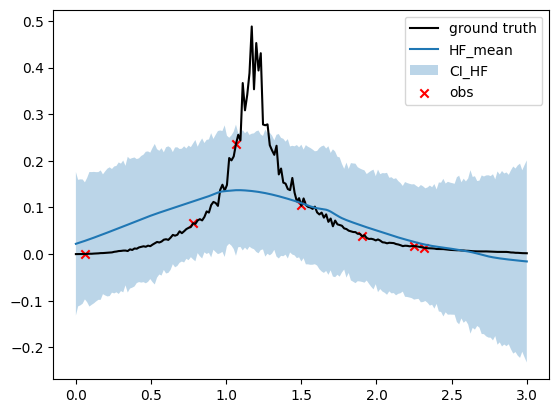

[52 71 66]


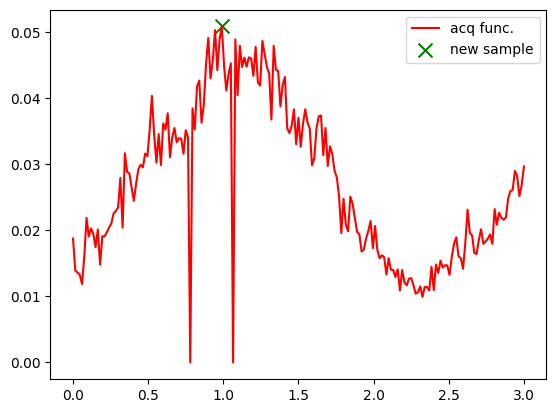

0.99 0.99
Evaluation 8 of 20

---Performing Equlibration---



100%|██████████| 500/500 [00:06<00:00, 72.13it/s]



---Finished...
----Performing MC Moves----



100%|██████████| 500/500 [00:17<00:00, 28.97it/s]


Completed. Saving
Time (s) to complete simulation 4: 24.203216075897217


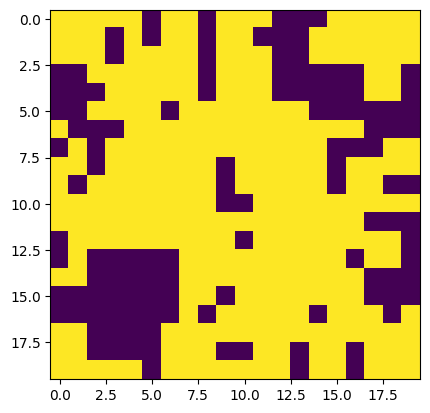

Step:4


/usr/local/lib/python3.10/dist-packages/gpax/models/gp.py:111: FutureWarning: `noise_prior` is deprecated and will be removed in a future version. Please use `noise_prior_dist` instead, which accepts an instance of a numpyro.distributions Distribution object, e.g., `dist.HalfNormal(scale=0.1)`, rather than a function that calls `numpyro.sample`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/gpax/models/gp.py:119: UserWarning: `kernel_prior` will remain available for complex priors. However, for modifying only the lengthscales, it is recommended to use `lengthscale_prior_dist` instead. `lengthscale_prior_dist` accepts an instance of a numpyro.distributions Distribution object, e.g., `dist.Gamma(2, 5)`, rather than a function that calls `numpyro.sample`.
  warnings.warn(
sample: 100%|██████████| 1000/1000 [00:21<00:00, 46.42it/s, 31 steps of size 7.58e-02. acc. prob=0.93]



                mean       std    median      5.0%     95.0%     n_eff     r_hat
         a      0.24      0.17      0.22      0.01      0.47    305.65      1.00
         b      0.97      0.59      0.94      0.02      1.75    137.54      1.00
         c      1.36      1.12      1.15      0.00      2.86    120.76      1.01
  k_length      0.66      0.25      0.69      0.31      1.00    274.70      1.00
   k_scale      0.20      0.22      0.10      0.01      0.53    253.85      1.00
     noise      0.01      0.01      0.00      0.00      0.02    222.36      1.00



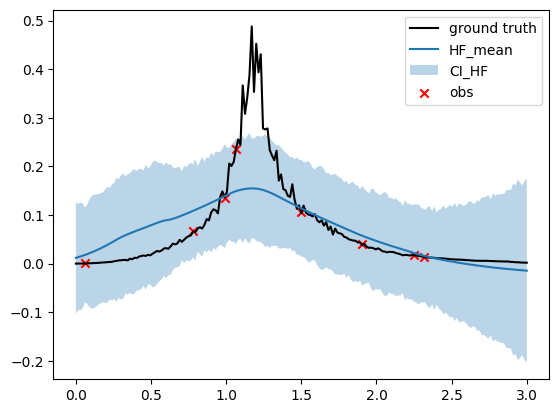

[52 71 66 77]


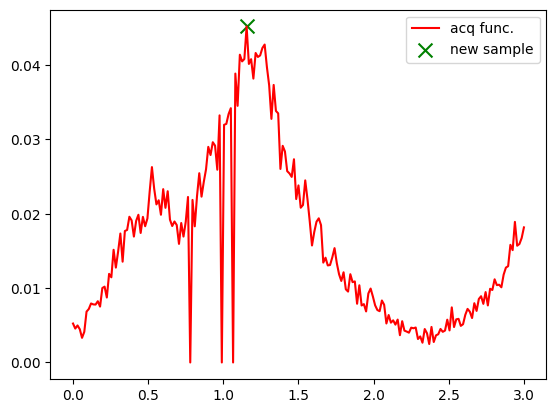

1.155 1.155
Evaluation 9 of 20

---Performing Equlibration---



100%|██████████| 500/500 [00:06<00:00, 72.91it/s]



---Finished...
----Performing MC Moves----



100%|██████████| 500/500 [00:17<00:00, 28.82it/s]


Completed. Saving
Time (s) to complete simulation 5: 24.22024369239807


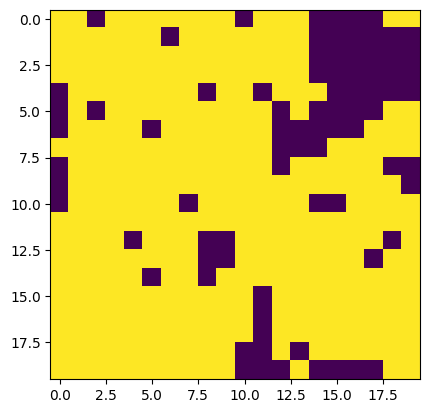

Step:5


/usr/local/lib/python3.10/dist-packages/gpax/models/gp.py:111: FutureWarning: `noise_prior` is deprecated and will be removed in a future version. Please use `noise_prior_dist` instead, which accepts an instance of a numpyro.distributions Distribution object, e.g., `dist.HalfNormal(scale=0.1)`, rather than a function that calls `numpyro.sample`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/gpax/models/gp.py:119: UserWarning: `kernel_prior` will remain available for complex priors. However, for modifying only the lengthscales, it is recommended to use `lengthscale_prior_dist` instead. `lengthscale_prior_dist` accepts an instance of a numpyro.distributions Distribution object, e.g., `dist.Gamma(2, 5)`, rather than a function that calls `numpyro.sample`.
  warnings.warn(
sample: 100%|██████████| 1000/1000 [00:20<00:00, 49.38it/s, 7 steps of size 3.13e-01. acc. prob=0.69]



                mean       std    median      5.0%     95.0%     n_eff     r_hat
         a      0.25      0.18      0.24      0.00      0.47    267.21      1.00
         b      0.97      0.62      1.02      0.04      1.68    113.41      1.00
         c      1.36      1.16      1.13      0.02      2.95     39.14      1.05
  k_length      0.56      0.30      0.62      0.05      0.92     51.22      1.00
   k_scale      0.18      0.23      0.07      0.01      0.52     87.91      1.01
     noise      0.01      0.01      0.01      0.00      0.03     43.46      1.06



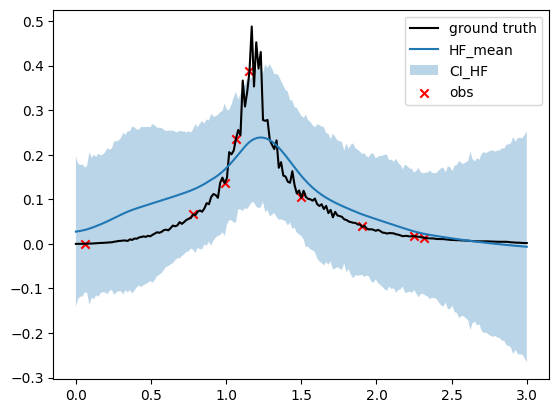

[52 71 66 77 84]


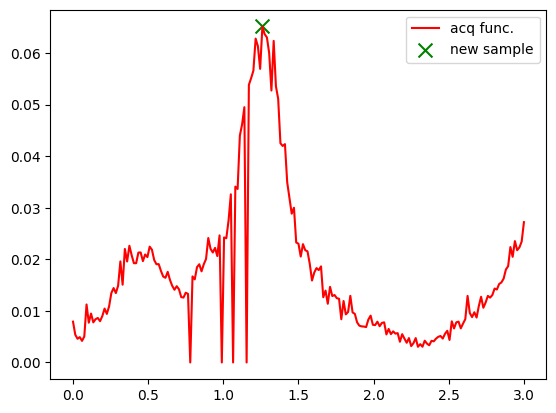

1.26 1.26
Evaluation 10 of 20

---Performing Equlibration---



100%|██████████| 500/500 [00:06<00:00, 74.62it/s]



---Finished...
----Performing MC Moves----



100%|██████████| 500/500 [00:17<00:00, 28.52it/s]


Completed. Saving
Time (s) to complete simulation 6: 24.242086172103882


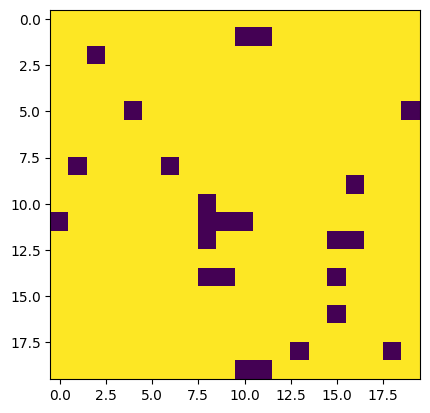

Step:6


/usr/local/lib/python3.10/dist-packages/gpax/models/gp.py:111: FutureWarning: `noise_prior` is deprecated and will be removed in a future version. Please use `noise_prior_dist` instead, which accepts an instance of a numpyro.distributions Distribution object, e.g., `dist.HalfNormal(scale=0.1)`, rather than a function that calls `numpyro.sample`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/gpax/models/gp.py:119: UserWarning: `kernel_prior` will remain available for complex priors. However, for modifying only the lengthscales, it is recommended to use `lengthscale_prior_dist` instead. `lengthscale_prior_dist` accepts an instance of a numpyro.distributions Distribution object, e.g., `dist.Gamma(2, 5)`, rather than a function that calls `numpyro.sample`.
  warnings.warn(
sample: 100%|██████████| 1000/1000 [00:47<00:00, 21.21it/s, 15 steps of size 2.08e-01. acc. prob=0.83]



                mean       std    median      5.0%     95.0%     n_eff     r_hat
         a      0.25      0.17      0.25      0.01      0.45    201.76      1.00
         b      0.83      0.60      0.82      0.00      1.50     78.55      1.00
         c      1.26      1.12      0.97      0.02      2.94    141.84      1.00
  k_length      0.57      0.28      0.62      0.15      0.99    101.90      1.01
   k_scale      0.24      0.25      0.14      0.01      0.63    201.10      1.00
     noise      0.01      0.01      0.01      0.00      0.03     91.97      1.00



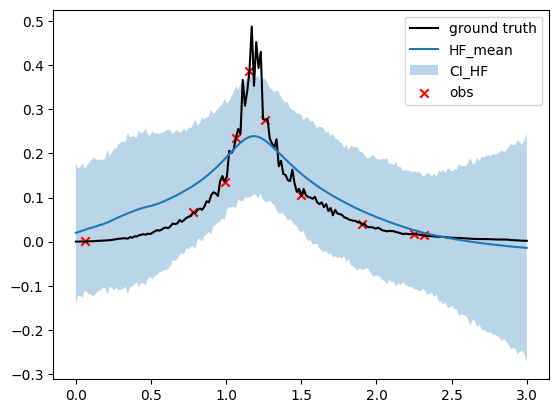

[52 71 66 77 84 81]


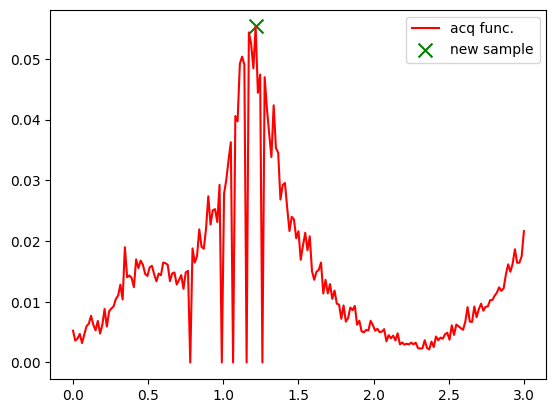

1.2149999999999999 1.2149999999999999
Evaluation 11 of 20

---Performing Equlibration---



100%|██████████| 500/500 [00:06<00:00, 72.83it/s]



---Finished...
----Performing MC Moves----



100%|██████████| 500/500 [00:17<00:00, 29.17it/s]


Completed. Saving
Time (s) to complete simulation 7: 24.01436495780945


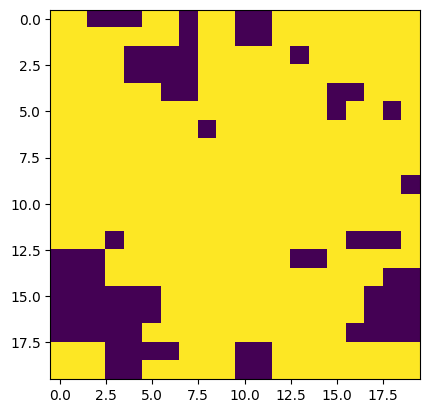

Step:7


/usr/local/lib/python3.10/dist-packages/gpax/models/gp.py:111: FutureWarning: `noise_prior` is deprecated and will be removed in a future version. Please use `noise_prior_dist` instead, which accepts an instance of a numpyro.distributions Distribution object, e.g., `dist.HalfNormal(scale=0.1)`, rather than a function that calls `numpyro.sample`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/gpax/models/gp.py:119: UserWarning: `kernel_prior` will remain available for complex priors. However, for modifying only the lengthscales, it is recommended to use `lengthscale_prior_dist` instead. `lengthscale_prior_dist` accepts an instance of a numpyro.distributions Distribution object, e.g., `dist.Gamma(2, 5)`, rather than a function that calls `numpyro.sample`.
  warnings.warn(
sample: 100%|██████████| 1000/1000 [02:13<00:00,  7.47it/s, 127 steps of size 1.32e-02. acc. prob=0.94]



                mean       std    median      5.0%     95.0%     n_eff     r_hat
         a      0.28      0.12      0.30      0.00      0.38     68.17      1.01
         b      1.14      0.36      1.18      0.44      1.56    161.75      1.00
         c      0.56      0.92      0.12      0.05      1.77     31.27      1.00
  k_length      0.64      0.25      0.68      0.26      1.00    181.12      1.00
   k_scale      0.16      0.21      0.07      0.01      0.47    160.11      1.01
     noise      0.01      0.01      0.00      0.00      0.02     35.14      1.00



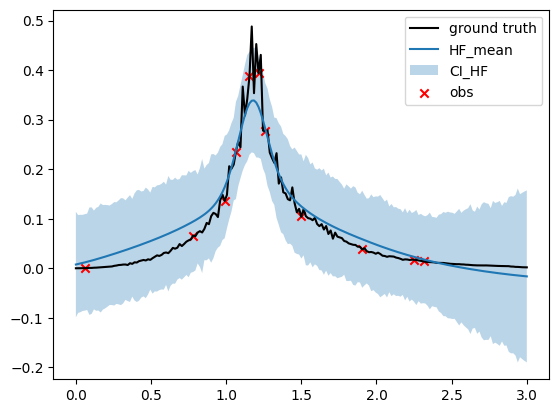

[52 71 66 77 84 81 79]


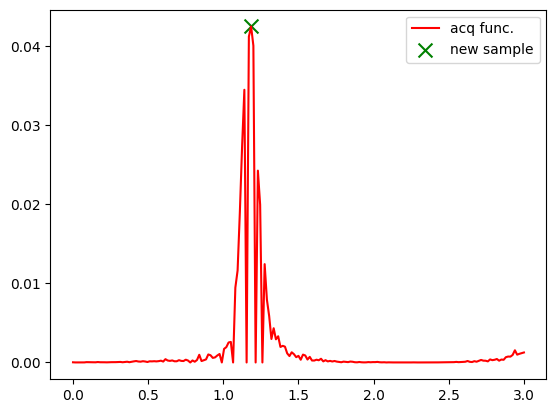

1.185 1.185
Evaluation 12 of 20

---Performing Equlibration---



100%|██████████| 500/500 [00:06<00:00, 72.46it/s]



---Finished...
----Performing MC Moves----



100%|██████████| 500/500 [00:17<00:00, 29.18it/s]


Completed. Saving
Time (s) to complete simulation 8: 24.048852920532227


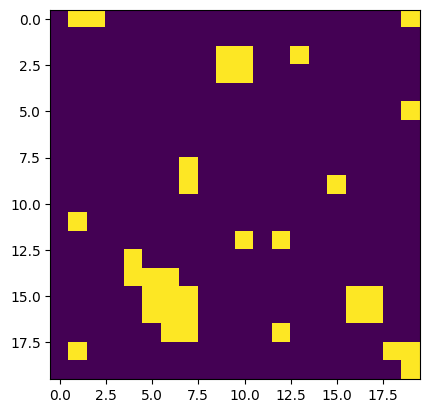

Step:8


/usr/local/lib/python3.10/dist-packages/gpax/models/gp.py:111: FutureWarning: `noise_prior` is deprecated and will be removed in a future version. Please use `noise_prior_dist` instead, which accepts an instance of a numpyro.distributions Distribution object, e.g., `dist.HalfNormal(scale=0.1)`, rather than a function that calls `numpyro.sample`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/gpax/models/gp.py:119: UserWarning: `kernel_prior` will remain available for complex priors. However, for modifying only the lengthscales, it is recommended to use `lengthscale_prior_dist` instead. `lengthscale_prior_dist` accepts an instance of a numpyro.distributions Distribution object, e.g., `dist.Gamma(2, 5)`, rather than a function that calls `numpyro.sample`.
  warnings.warn(
sample: 100%|██████████| 1000/1000 [00:32<00:00, 31.03it/s, 7 steps of size 3.20e-01. acc. prob=0.94]



                mean       std    median      5.0%     95.0%     n_eff     r_hat
         a      0.30      0.06      0.30      0.21      0.39    246.08      1.00
         b      1.19      0.06      1.18      1.15      1.24     62.33      1.00
         c      0.14      0.18      0.11      0.06      0.22     91.38      1.00
  k_length      0.68      0.23      0.72      0.35      1.00    326.21      1.00
   k_scale      0.12      0.17      0.05      0.01      0.28    328.87      1.00
     noise      0.00      0.00      0.00      0.00      0.01    111.44      1.00



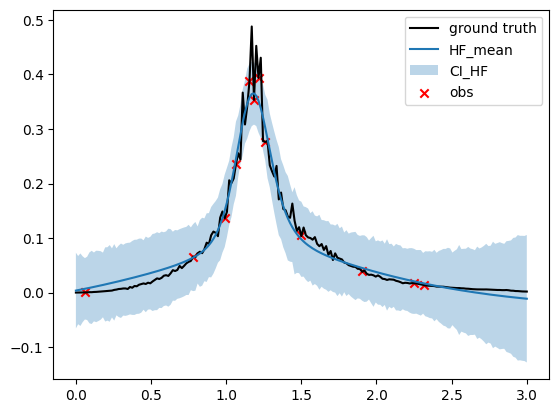

[52 71 66 77 84 81 79 78]


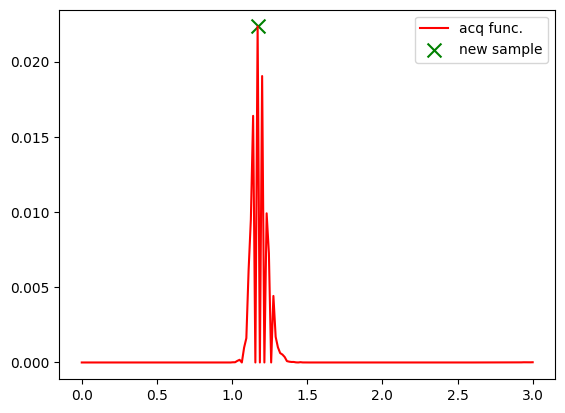

1.17 1.17
Evaluation 13 of 20

---Performing Equlibration---



100%|██████████| 500/500 [00:06<00:00, 74.43it/s]



---Finished...
----Performing MC Moves----



100%|██████████| 500/500 [00:17<00:00, 29.22it/s]


Completed. Saving
Time (s) to complete simulation 9: 23.839577674865723


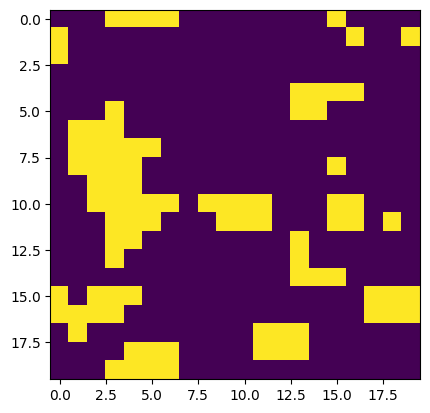

Step:9


/usr/local/lib/python3.10/dist-packages/gpax/models/gp.py:111: FutureWarning: `noise_prior` is deprecated and will be removed in a future version. Please use `noise_prior_dist` instead, which accepts an instance of a numpyro.distributions Distribution object, e.g., `dist.HalfNormal(scale=0.1)`, rather than a function that calls `numpyro.sample`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/gpax/models/gp.py:119: UserWarning: `kernel_prior` will remain available for complex priors. However, for modifying only the lengthscales, it is recommended to use `lengthscale_prior_dist` instead. `lengthscale_prior_dist` accepts an instance of a numpyro.distributions Distribution object, e.g., `dist.Gamma(2, 5)`, rather than a function that calls `numpyro.sample`.
  warnings.warn(
sample: 100%|██████████| 1000/1000 [01:55<00:00,  8.67it/s, 63 steps of size 2.96e-02. acc. prob=0.80]



                mean       std    median      5.0%     95.0%     n_eff     r_hat
         a      0.30      0.13      0.32      0.05      0.44    169.80      1.00
         b      1.11      0.48      1.17      0.10      1.41    321.07      1.00
         c      0.76      1.07      0.19      0.05      2.31     29.49      1.00
  k_length      0.52      0.32      0.55      0.08      1.00     31.64      1.00
   k_scale      0.12      0.18      0.05      0.01      0.37    104.28      1.00
     noise      0.01      0.01      0.01      0.00      0.02    102.32      1.01



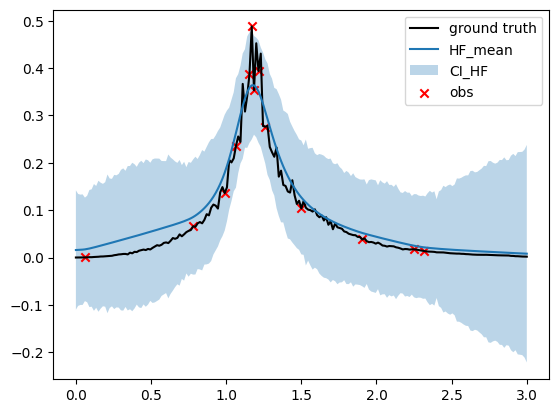

[52 71 66 77 84 81 79 78 76]


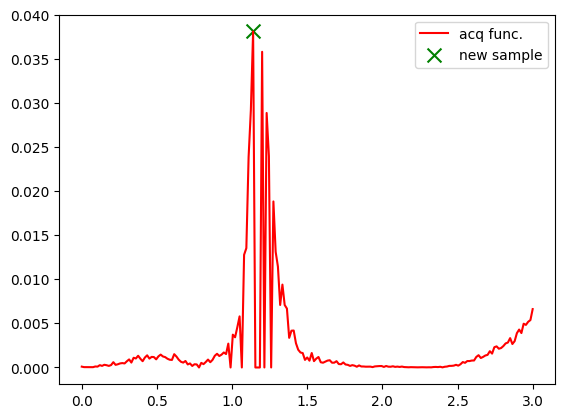

1.14 1.14
Evaluation 14 of 20

---Performing Equlibration---



100%|██████████| 500/500 [00:06<00:00, 74.09it/s]



---Finished...
----Performing MC Moves----



100%|██████████| 500/500 [00:17<00:00, 29.01it/s]


Completed. Saving
Time (s) to complete simulation 10: 23.99284839630127


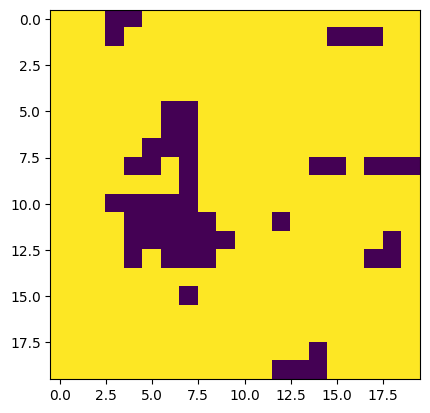

Step:10


/usr/local/lib/python3.10/dist-packages/gpax/models/gp.py:111: FutureWarning: `noise_prior` is deprecated and will be removed in a future version. Please use `noise_prior_dist` instead, which accepts an instance of a numpyro.distributions Distribution object, e.g., `dist.HalfNormal(scale=0.1)`, rather than a function that calls `numpyro.sample`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/gpax/models/gp.py:119: UserWarning: `kernel_prior` will remain available for complex priors. However, for modifying only the lengthscales, it is recommended to use `lengthscale_prior_dist` instead. `lengthscale_prior_dist` accepts an instance of a numpyro.distributions Distribution object, e.g., `dist.Gamma(2, 5)`, rather than a function that calls `numpyro.sample`.
  warnings.warn(
sample: 100%|██████████| 1000/1000 [01:25<00:00, 11.72it/s, 31 steps of size 1.31e-01. acc. prob=0.72]



                mean       std    median      5.0%     95.0%     n_eff     r_hat
         a      0.27      0.15      0.28      0.03      0.48     52.53      1.02
         b      1.01      0.58      1.16      0.00      1.54    112.52      1.01
         c      1.02      1.15      0.51      0.02      2.68     31.72      1.00
  k_length      0.44      0.31      0.41      0.04      0.91     18.27      1.01
   k_scale      0.20      0.24      0.08      0.01      0.60     41.92      1.03
     noise      0.01      0.01      0.01      0.00      0.02    180.06      1.00



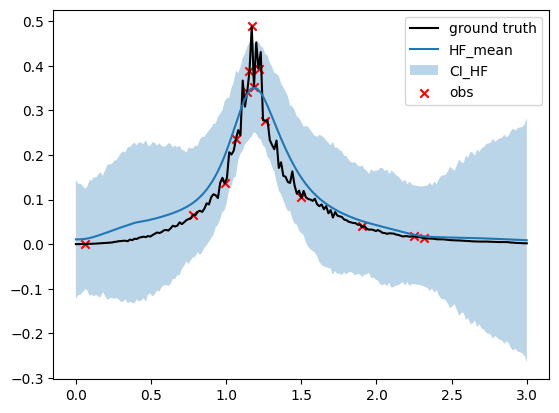

[52 71 66 77 84 81 79 78 76 80]


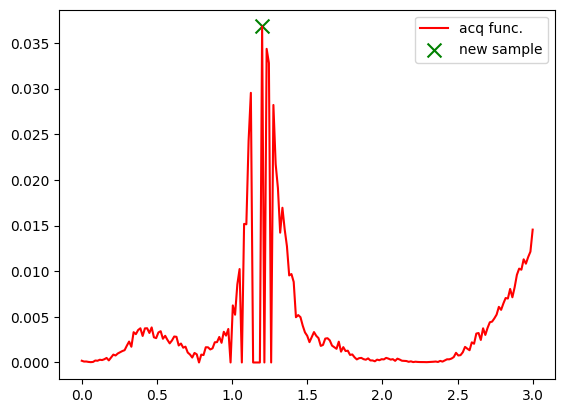

1.2 1.2
Evaluation 15 of 20

---Performing Equlibration---



100%|██████████| 500/500 [00:06<00:00, 74.19it/s]



---Finished...
----Performing MC Moves----



100%|██████████| 500/500 [00:16<00:00, 29.56it/s]


Completed. Saving
Time (s) to complete simulation 11: 23.664531469345093


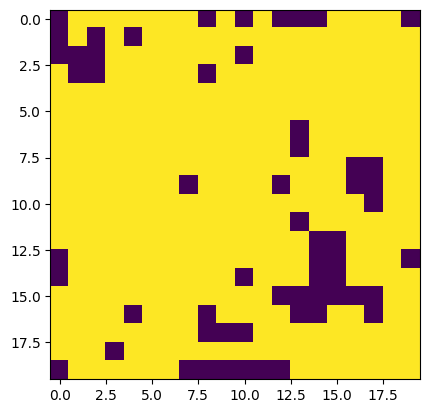

Step:11


/usr/local/lib/python3.10/dist-packages/gpax/models/gp.py:111: FutureWarning: `noise_prior` is deprecated and will be removed in a future version. Please use `noise_prior_dist` instead, which accepts an instance of a numpyro.distributions Distribution object, e.g., `dist.HalfNormal(scale=0.1)`, rather than a function that calls `numpyro.sample`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/gpax/models/gp.py:119: UserWarning: `kernel_prior` will remain available for complex priors. However, for modifying only the lengthscales, it is recommended to use `lengthscale_prior_dist` instead. `lengthscale_prior_dist` accepts an instance of a numpyro.distributions Distribution object, e.g., `dist.Gamma(2, 5)`, rather than a function that calls `numpyro.sample`.
  warnings.warn(
sample: 100%|██████████| 1000/1000 [01:59<00:00,  8.40it/s, 31 steps of size 4.46e-02. acc. prob=0.51]



                mean       std    median      5.0%     95.0%     n_eff     r_hat
         a      0.33      0.11      0.33      0.13      0.43     71.91      1.00
         b      1.11      0.27      1.18      0.57      1.34     24.75      1.08
         c      0.26      0.60      0.10      0.02      0.40     22.42      1.08
  k_length      0.69      0.32      0.82      0.13      1.00      6.68      1.24
   k_scale      0.13      0.19      0.05      0.01      0.47     29.04      1.01
     noise      0.00      0.00      0.00      0.00      0.01     27.45      1.06



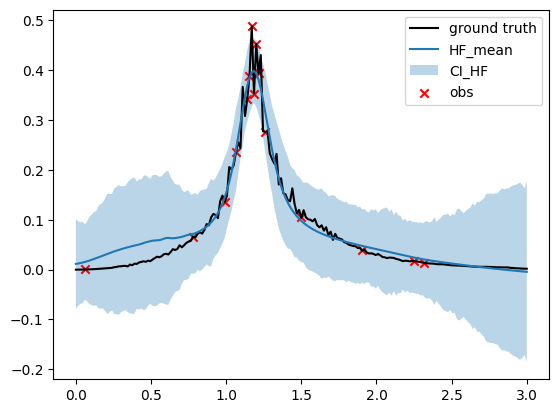

[52 71 66 77 84 81 79 78 76 80 82]


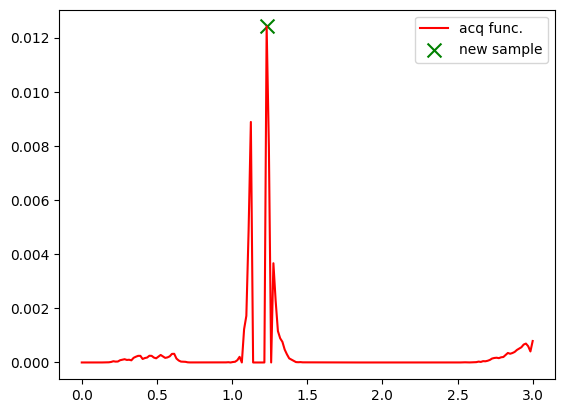

1.23 1.23
Evaluation 16 of 20

---Performing Equlibration---



100%|██████████| 500/500 [00:06<00:00, 75.23it/s]



---Finished...
----Performing MC Moves----



100%|██████████| 500/500 [00:17<00:00, 28.80it/s]


Completed. Saving
Time (s) to complete simulation 12: 24.017849922180176


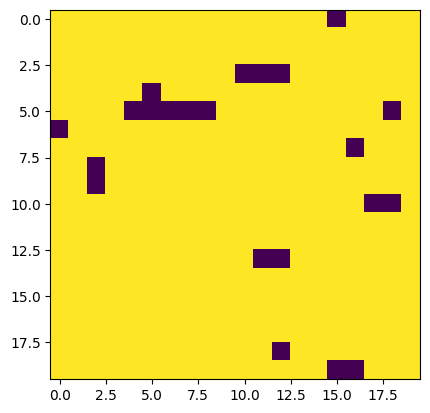

Step:12


/usr/local/lib/python3.10/dist-packages/gpax/models/gp.py:111: FutureWarning: `noise_prior` is deprecated and will be removed in a future version. Please use `noise_prior_dist` instead, which accepts an instance of a numpyro.distributions Distribution object, e.g., `dist.HalfNormal(scale=0.1)`, rather than a function that calls `numpyro.sample`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/gpax/models/gp.py:119: UserWarning: `kernel_prior` will remain available for complex priors. However, for modifying only the lengthscales, it is recommended to use `lengthscale_prior_dist` instead. `lengthscale_prior_dist` accepts an instance of a numpyro.distributions Distribution object, e.g., `dist.Gamma(2, 5)`, rather than a function that calls `numpyro.sample`.
  warnings.warn(
sample: 100%|██████████| 1000/1000 [01:16<00:00, 13.13it/s, 255 steps of size 2.08e-02. acc. prob=0.95]



                mean       std    median      5.0%     95.0%     n_eff     r_hat
         a      0.28      0.13      0.31      0.04      0.43     28.86      1.05
         b      1.07      0.49      1.18      0.02      1.33     54.40      1.02
         c      0.65      0.95      0.15      0.02      2.17     31.38      1.06
  k_length      0.45      0.33      0.42      0.03      0.93     10.50      1.09
   k_scale      0.13      0.19      0.05      0.01      0.41    205.09      1.01
     noise      0.00      0.00      0.00      0.00      0.01    103.64      1.02



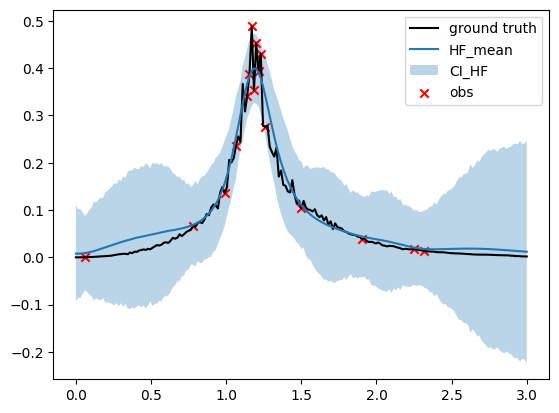

[52 71 66 77 84 81 79 78 76 80 82 83]


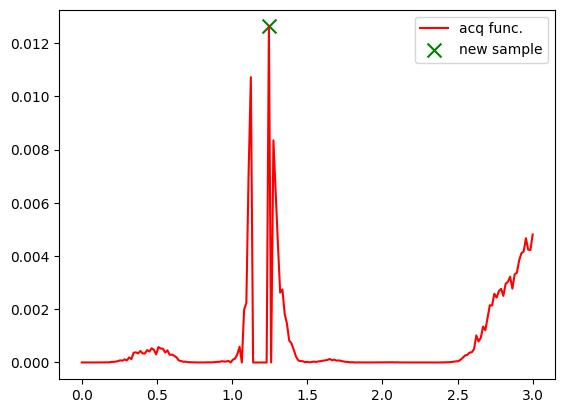

1.2449999999999999 1.2449999999999999
Evaluation 17 of 20

---Performing Equlibration---



100%|██████████| 500/500 [00:06<00:00, 74.49it/s]



---Finished...
----Performing MC Moves----



100%|██████████| 500/500 [00:17<00:00, 29.25it/s]


Completed. Saving
Time (s) to complete simulation 13: 23.81765341758728


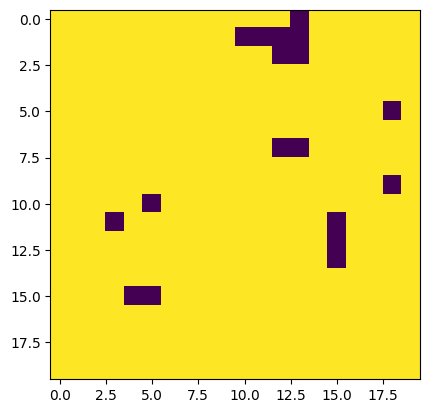

Step:13


/usr/local/lib/python3.10/dist-packages/gpax/models/gp.py:111: FutureWarning: `noise_prior` is deprecated and will be removed in a future version. Please use `noise_prior_dist` instead, which accepts an instance of a numpyro.distributions Distribution object, e.g., `dist.HalfNormal(scale=0.1)`, rather than a function that calls `numpyro.sample`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/gpax/models/gp.py:119: UserWarning: `kernel_prior` will remain available for complex priors. However, for modifying only the lengthscales, it is recommended to use `lengthscale_prior_dist` instead. `lengthscale_prior_dist` accepts an instance of a numpyro.distributions Distribution object, e.g., `dist.Gamma(2, 5)`, rather than a function that calls `numpyro.sample`.
  warnings.warn(
sample: 100%|██████████| 1000/1000 [03:16<00:00,  5.08it/s, 127 steps of size 2.02e-02. acc. prob=0.88]



                mean       std    median      5.0%     95.0%     n_eff     r_hat
         a      0.32      0.10      0.33      0.15      0.45     86.06      1.03
         b      1.13      0.28      1.18      0.60      1.40     48.66      1.04
         c      0.35      0.74      0.11      0.05      1.00     13.96      1.11
  k_length      0.57      0.29      0.63      0.03      0.92     15.62      1.10
   k_scale      0.11      0.16      0.05      0.01      0.29    105.60      1.03
     noise      0.00      0.00      0.00      0.00      0.01     66.78      1.01



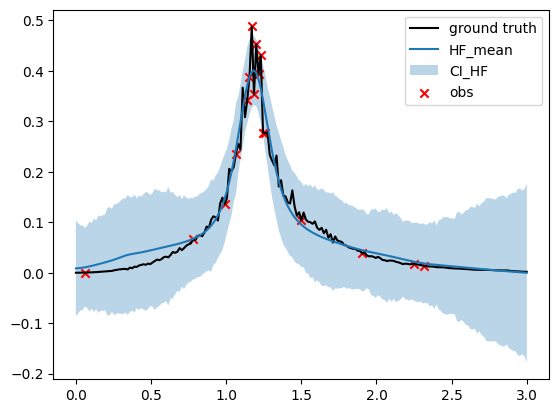

[52 71 66 77 84 81 79 78 76 80 82 83 75]


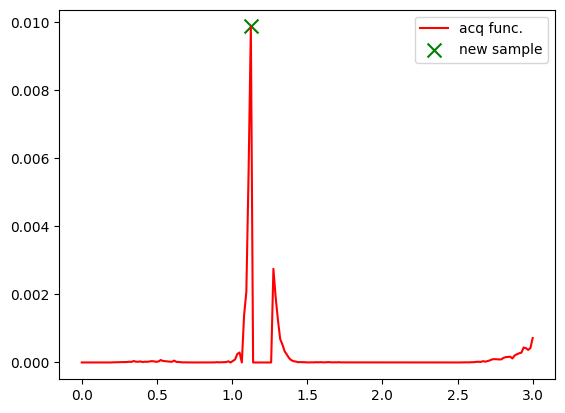

1.125 1.125
Evaluation 18 of 20

---Performing Equlibration---



100%|██████████| 500/500 [00:06<00:00, 72.08it/s]



---Finished...
----Performing MC Moves----



100%|██████████| 500/500 [00:17<00:00, 28.56it/s]


Completed. Saving
Time (s) to complete simulation 14: 24.45002508163452


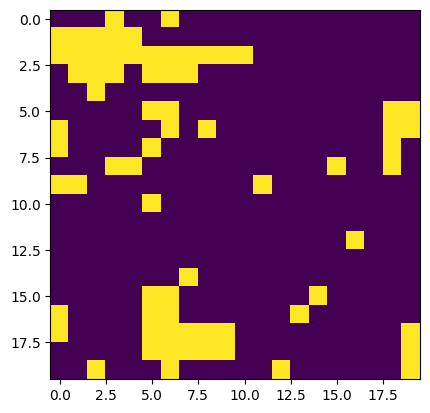

Step:14


/usr/local/lib/python3.10/dist-packages/gpax/models/gp.py:111: FutureWarning: `noise_prior` is deprecated and will be removed in a future version. Please use `noise_prior_dist` instead, which accepts an instance of a numpyro.distributions Distribution object, e.g., `dist.HalfNormal(scale=0.1)`, rather than a function that calls `numpyro.sample`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/gpax/models/gp.py:119: UserWarning: `kernel_prior` will remain available for complex priors. However, for modifying only the lengthscales, it is recommended to use `lengthscale_prior_dist` instead. `lengthscale_prior_dist` accepts an instance of a numpyro.distributions Distribution object, e.g., `dist.Gamma(2, 5)`, rather than a function that calls `numpyro.sample`.
  warnings.warn(
sample: 100%|██████████| 1000/1000 [01:26<00:00, 11.53it/s, 7 steps of size 4.52e-01. acc. prob=0.90]



                mean       std    median      5.0%     95.0%     n_eff     r_hat
         a      0.33      0.05      0.33      0.26      0.43    332.12      1.00
         b      1.19      0.02      1.19      1.16      1.21    183.63      1.01
         c      0.11      0.05      0.10      0.06      0.17    221.19      1.00
  k_length      0.70      0.22      0.72      0.39      1.00    452.70      1.00
   k_scale      0.13      0.19      0.05      0.01      0.43    315.09      1.00
     noise      0.00      0.00      0.00      0.00      0.01    206.12      1.00



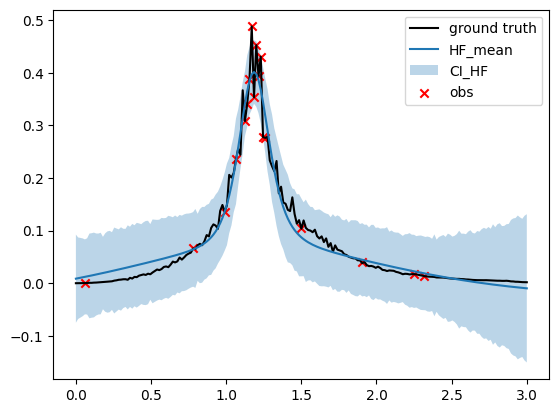

[52 71 66 77 84 81 79 78 76 80 82 83 75 74]


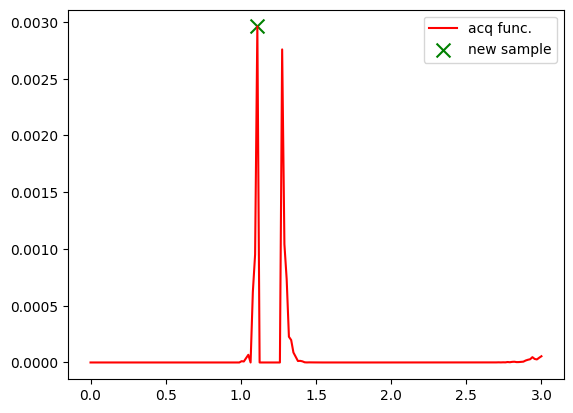

1.1099999999999999 1.1099999999999999
Evaluation 19 of 20

---Performing Equlibration---



100%|██████████| 500/500 [00:06<00:00, 72.27it/s]



---Finished...
----Performing MC Moves----



100%|██████████| 500/500 [00:17<00:00, 29.21it/s]


Completed. Saving
Time (s) to complete simulation 15: 24.0454683303833


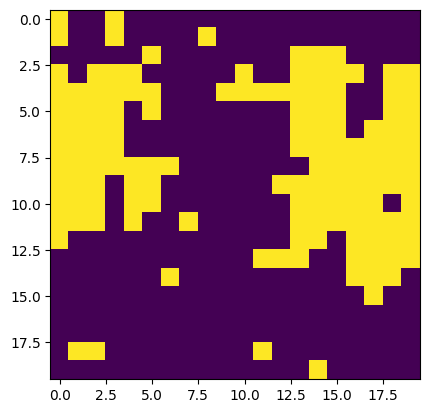

Step:15


/usr/local/lib/python3.10/dist-packages/gpax/models/gp.py:111: FutureWarning: `noise_prior` is deprecated and will be removed in a future version. Please use `noise_prior_dist` instead, which accepts an instance of a numpyro.distributions Distribution object, e.g., `dist.HalfNormal(scale=0.1)`, rather than a function that calls `numpyro.sample`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/gpax/models/gp.py:119: UserWarning: `kernel_prior` will remain available for complex priors. However, for modifying only the lengthscales, it is recommended to use `lengthscale_prior_dist` instead. `lengthscale_prior_dist` accepts an instance of a numpyro.distributions Distribution object, e.g., `dist.Gamma(2, 5)`, rather than a function that calls `numpyro.sample`.
  warnings.warn(
sample: 100%|██████████| 1000/1000 [01:34<00:00, 10.60it/s, 15 steps of size 9.25e-02. acc. prob=0.72]



                mean       std    median      5.0%     95.0%     n_eff     r_hat
         a      0.31      0.24      0.25      0.01      0.72     16.06      1.07
         b      1.12      0.64      1.19      0.02      1.99     87.19      1.01
         c      1.06      1.10      0.71      0.00      2.81     44.62      1.01
  k_length      0.19      0.16      0.15      0.02      0.41     79.49      1.00
   k_scale      0.17      0.20      0.07      0.01      0.47     46.17      1.10
     noise      0.01      0.00      0.01      0.00      0.01    125.49      1.04



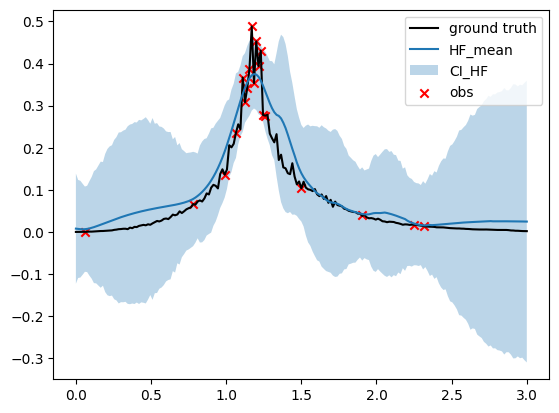

[52 71 66 77 84 81 79 78 76 80 82 83 75 74 91]


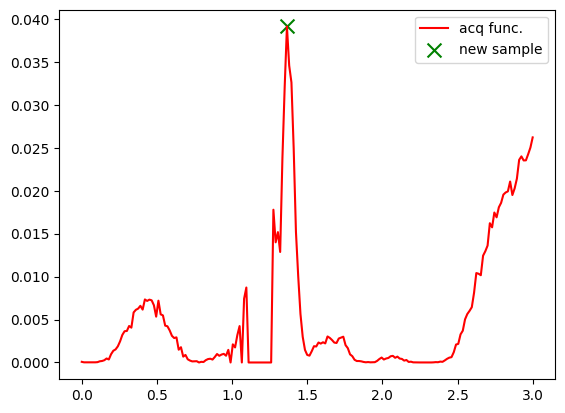

1.365 1.365
Evaluation 20 of 20

---Performing Equlibration---



100%|██████████| 500/500 [00:06<00:00, 76.83it/s]



---Finished...
----Performing MC Moves----



100%|██████████| 500/500 [00:17<00:00, 29.09it/s]


Completed. Saving
Time (s) to complete simulation 16: 23.70594835281372


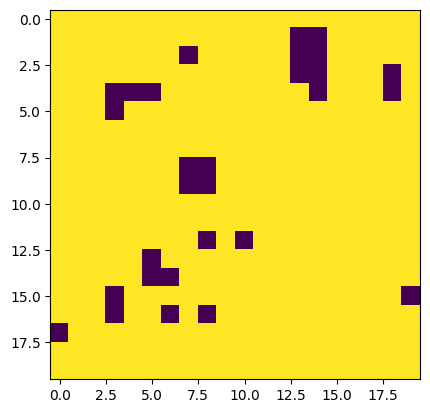

In [ ]:
N = 15
X_test =xs
X_test_full = xs
X_test_norm = (X_test-bounds[0])/(bounds[1]-bounds[0])

# Get random number generator keys for training and prediction
rng_key, rng_key_predict = gpax.utils.get_keys()
idx = []
for i in range(1, N+1):
    print("Step:"+str(i))


    # Initialize model
    gp_model = gpax.ExactGP(1, kernel='Matern', kernel_prior = kernel_prior, mean_fn= mean_func, mean_fn_prior=mf_priors,
                        noise_prior = lambda: numpyro.sample("noise", numpyro.distributions.HalfNormal(0.03)))
    # Run Hamiltonian Monte Carlo to obtain posterior samples for kernel parameters and model noise
    gp_model.fit(rng_key, train_x_full_norm, train_y, num_warmup=500, num_samples=500, num_chains=1)



    y_pred, y_sampled = gp_model.predict(rng_key_predict, X_test_norm)
    plt.plot(xs, true_ys_sq, "k", label="ground truth")
    pred_lower = y_pred - y_sampled.std(axis=(0,1))
    pred_upper = y_pred + y_sampled.std(axis=(0,1))
    plt.plot(xs, y_pred, label="HF_mean")
    plt.fill_between(
        xs.flatten(),
        pred_lower,
        pred_upper,
        alpha=0.3,
        label="CI_HF",
    )
    plt.scatter(train_x_full, train_y, c="r", marker="x", label="obs")

    plt.legend(loc="best")
    plt.show()
    # Compute the EI acq function
    acq = gpax.acquisition.EI(rng_key_predict, gp_model, X_test_norm, maximize=True, noiseless=False)
    acq = np.array(acq)
    acq[idx] = 0
    next_point_val = acq.max()
    next_point_idx = acq.argmax()
    idx = np.hstack((idx, next_point_idx))

    if len(idx) == 1:
        idx = int(idx)
        print(idx)
    else:
        idx = idx
        print(idx)


    if next_point_val == 0:
        print("Model sufficiently learned")
        break
    else:
        next_point = X_test[next_point_idx]
        next_point_norm = X_test_norm[next_point_idx]
        train_x_full = np.vstack((train_x_full, next_point))
        train_x_full_norm = np.vstack((train_x_full_norm, next_point_norm))

        #Plot acquistion function
        plt.plot(xs, acq, "r", label="acq func.")
        plt.scatter(next_point, next_point_val, c="g", marker="x", label="new sample", s= 100)
        plt.legend(loc="best")
        plt.show()

        Jx=train_x_full[:,0]
        print(next_point, Jx[-1])
        J_mat = np.array([[0,0,0,0,0],
                  [0,0,Jx[-1],0,0],
                  [0,Jx[-1],0,Jx[-1],0],
                  [0,0,Jx[-1],0,0],
                  [0,0,0,0,0]])
        print("Evaluation " +str (n+i) +" of " +str(n+N))
        start_time = time.time()
        np.random.seed(0)
        sq_sim = IsingSim(N = 20, J_mat = J_mat, T = 2.7, save_trajectories=True, eqSteps = 500, mcSteps = 500)  # Intializing the object
        sq_sim.performIsingSim()   # Running the sim
        end_time = time.time()
        #time_eval[i]= end_time-start_time
        print("Time (s) to complete simulation " +str(i+1)+ ": " +str(end_time-start_time))
        resultsBO_dict[n+i] = {'sim': sq_sim.results,}
        new_y = resultsBO_dict[n+i]['sim']['SpecificHeat']
        plt.imshow(resultsBO_dict[n+i]['sim']['config'][-1])
        plt.show()
        train_y = np.vstack((train_y, new_y))



# Final GP prediction

/usr/local/lib/python3.10/dist-packages/gpax/models/gp.py:111: FutureWarning: `noise_prior` is deprecated and will be removed in a future version. Please use `noise_prior_dist` instead, which accepts an instance of a numpyro.distributions Distribution object, e.g., `dist.HalfNormal(scale=0.1)`, rather than a function that calls `numpyro.sample`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/gpax/models/gp.py:119: UserWarning: `kernel_prior` will remain available for complex priors. However, for modifying only the lengthscales, it is recommended to use `lengthscale_prior_dist` instead. `lengthscale_prior_dist` accepts an instance of a numpyro.distributions Distribution object, e.g., `dist.Gamma(2, 5)`, rather than a function that calls `numpyro.sample`.
  warnings.warn(
sample: 100%|██████████| 1000/1000 [01:10<00:00, 14.27it/s, 7 steps of size 3.53e-01. acc. prob=0.93]



                mean       std    median      5.0%     95.0%     n_eff     r_hat
         a      0.32      0.06      0.32      0.23      0.40    207.23      1.00
         b      1.18      0.02      1.18      1.16      1.21    239.07      1.00
         c      0.12      0.06      0.11      0.07      0.17    107.69      1.00
  k_length      0.68      0.24      0.73      0.36      1.00    268.37      1.00
   k_scale      0.14      0.19      0.06      0.01      0.41    331.18      1.01
     noise      0.00      0.00      0.00      0.00      0.01    198.42      1.00



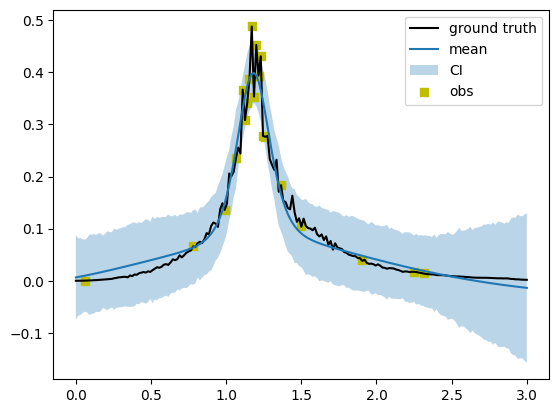

In [ ]:
# Initialize model
gp_model = gpax.ExactGP(1, kernel='Matern', kernel_prior = kernel_prior, mean_fn= mean_func, mean_fn_prior=mf_priors,
                    noise_prior = lambda: numpyro.sample("noise", numpyro.distributions.HalfNormal(0.03)))
# Run Hamiltonian Monte Carlo to obtain posterior samples for kernel parameters and model noise
gp_model.fit(rng_key, train_x_full_norm, train_y, num_warmup=500, num_samples=500, num_chains=1)


y_pred, y_sampled = gp_model.predict(rng_key_predict, X_test_norm)
plt.plot(xs, true_ys_sq, "k", label="ground truth")
pred_lower = y_pred - y_sampled.std(axis=(0,1))
pred_upper = y_pred + y_sampled.std(axis=(0,1))
plt.plot(xs, y_pred, label="mean")
plt.fill_between(
    xs.flatten(),
    pred_lower,
    pred_upper,
    alpha=0.3,
    label="CI",
)
plt.scatter(train_x_full, train_y, c="y", marker="s", label="obs")

plt.legend(loc="best")
plt.show()

0.000522904451080694 0.0003404844567369041


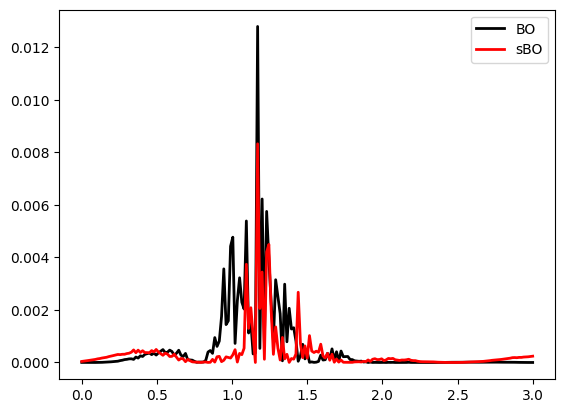

In [ ]:
# Calculate MSE between HF ground truth and prediction values
error2_sBO = (true_ys_sq-y_pred)**2
MSE_sBO = np.mean(error2_sBO)
print(MSE_BO, MSE_sBO)

plt.plot(xs, error2_BO, c="k", linewidth =2, label="BO")
plt.plot(xs, error2_sBO, c="r", linewidth =2, label="sBO")
plt.legend(loc="best")
plt.show()

sBO provides better convergence than BO with same computational cost, thus accelerate learning with physics knowledge injection